In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "anna.buch@uni-heidelberg.de"


AIM:
Clean survey dataset and do explore features
- unify commata to decimals
- clean columns from typos
- define correct datatype to the columns
- split records by event type (most recent, most severe) based on flood-related variables and flood times
- convert monetary variables to price level of 2020
- select columns which could be later needed for model development (feature selection, flood loss models)
- derive variable for relative content loss based on business values
- create feature spaces for relative content loss and for business interruption loss

# Data Preparation 
For reasons of reusability and comparability the workflow of the data preprocessing was kept similar to previous preprocessings of the same questionnaire. This was achieved by dealing with missing or erroneous values in a similar way likewise erroneous values with commas or points in the beginning were converted to decimal numbers beginning with zero. Furthermore some of the variables such as building age are constructed in the same way. And most important identical events are identifed in the same way and the records are splitted by their flood event types in the same way as done in other studies by the same working group

In [8]:
import sys, os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from collections import Counter
import matplotlib.pyplot as plt

import src.figures as f
import src.preprocessing as pp
import src.feature_selection as fs
import src.settings as s

import warnings

SRC_PATH = os.path.join(os.path.abspath(""), "../", "src")
OUTPATH_FIGURES = Path("../figures")

warnings.filterwarnings("ignore")


pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)


In [9]:
# load raw survey data

raw_data = pd.read_excel("../../input_survey_data/raw_data_vietnamese_geolocations_no_dublicates.xlsx") # HCMC dataset with vietnamese addresses and improved geolocations and building information
raw_data.tail(3)                                 

id_x           Q0.1 Q0.2.Ward Q0.2.District                     Q0.3   
249   251  8040020000000       NaN           NaN                8/27 ?p 3  \
250   252  8040020000000       NaN           NaN  1465/46/17 lê v?n l??ng   
251   253  8040020000000       NaN           NaN       1465/46/6 nh?n ??c   

     Q0.4             Q0.5      Q0.6  Q0.7  Pre.Q1  Pre.Q2  P1Q1 P1Q1.specify   
249     1       Võ Th? Hoa  14:00:00    16       1       1     4               \
250     1      Tô V?n D?ng  09:56:00    16       1       1     4                
251     1  Nguy?n Nh?t Tân  10:34:00    16       1       1     4                

                                  P1Q2.1.1    P1Q2.2.1 P1Q2.3.1  P1Q2.4.1   
249                              Ng?p 2017  08/99/2017        5        20  \
250  ??t ng?p do tri?u c??ng dâng cao 2019  10/99/2019        3         5   
251                                   2018  09/99/2018        1        20   

     P1Q2.5.1.0  P1Q2.5.1.1  P1Q2.5.1.2  P1Q2.5.1.3  P1Q2.5.1.4  P1Q2.5.1.88   
249           0           1           0           0           1            0  \
250           0           1           0           0           1            0   
251           0           1           0           0           0            1   

     P1Q2.5.1.99 P1Q2.5.1.specify  P1Q2.6.1  P1Q2.7.1.1  P1Q2.7.1.2   
249            0                          1           1           0  \
250            0                          2           1           0   
251            0         Bùn sình         3           1           0   

     P1Q2.7.1.3  P1Q2.7.1.88  P1Q2.7.1.99 P1Q2.7.1.specify  P1Q2.8.1.1   
249           0            0            0                            1  \
250           0            0            0                            1   
251           0            0            0                            1   

     P1Q2.8.1.2  P1Q2.8.1.3  P1Q2.8.1.4  P1Q2.8.1.5  P1Q2.8.1.6  P1Q2.8.1.7   
249           0           0           0           0           0           0  \
250           0           0           0           0           0           0   
251           0           0           0           0           0           0   

     P1Q2.8.1.8  P1Q2.8.1.9  P1Q2.8.1.10  P1Q2.8.1.99 P1Q2.8.1.specify   
249           0           0            0            0                   \
250           0           0            0            0                    
251           0           0            0            0                    

    P1Q2.9.1  P1Q2.10.1.1  P1Q2.10.1.2  P1Q2.10.1.3  P1Q2.10.1.4  P1Q2.10.1.5   
249       99            0            0            1            0            0  \
250       99            1            1            1            1            0   
251       99            0            0            0            0            0   

     P1Q2.10.1.6  P1Q2.10.1.7  P1Q2.10.1.8  P1Q2.10.1.9  P1Q2.10.1.88   
249            0            0            0            0             1  \
250            0            1            0            0             0   
251            0            0            0            1             0   

     P1Q2.10.1.99      P1Q2.10.1.specify  P1Q2.11.1.1  P1Q2.11.1.2   
249             0  Xây kè xung quanh nhà            0            1  \
250             0                                   0            1   
251             0                                   0            1   

     P1Q2.11.1.3  P1Q2.11.1.4  P1Q2.11.1.5  P1Q2.11.1.6  P1Q2.11.1.7   
249            1            1            0            0            0  \
250            0            1            0            1            0   
251            1            0            0            0            0   

     P1Q2.11.1.8  P1Q2.11.1.9  P1Q2.11.1.88  P1Q2.11.1.99 P1Q2.11.1.specify   
249            0            0             0             0                    \
250            0            0             0             0                     
251            0            0             0             0                     

     P1Q3.2.1  P1Q3.3.1  P1Q3.4.1  P1Q3.

### Overview

In [10]:
## Fix erroneous coordinate pair 
raw_data.GPS = raw_data.geometry.astype(str).replace(
    {"10.722.546,106.62888":"10.722546,106.62888",
    "10797626106701100":"10.797626,106.701100",  # idx 24
    "10722187106.63":"10.722187,106.63"})  # idx 152

In [11]:
# get coords in readable format for gpd
raw_data_geometry = raw_data

raw_data["geometry"] = raw_data["geometry"].str.findall(r"(\d+\.\d+)").astype(str)
geom_col = raw_data["geometry"].str.split(" ", n=1, expand=True)
geom_col

raw_data = gpd.GeoDataFrame(raw_data,  
           geometry=gpd.points_from_xy(
               geom_col[0].str.extract(r"(\d+\.\d+)")[0],
               geom_col[1].str.extract(r"(\d+\.\d+)")[0],
    ))
print(raw_data.shape)


## save shp locations to disk, 
# extract elevation based on shop locations in datapoints_vars_bui.shp via QGIS due to loading size and process with gdal
#print(raw_data_geometry.crs)
raw_data = raw_data.set_crs(4326) 
# raw_data_geometry.geometry.to_file("../input_survey_data/DEM_LiDAR/datapoints_vars_bui_tuebingen.shp")  

(252, 555)


In [12]:
## visual check of SMEs locations

glimpse = raw_data[~ raw_data.is_empty]   # drop emtpy geoms
glimpse.geometry.explore()  


Map shows spatial distribution of business locations from the HCMC survey dataset.
It can be seen that a few shops are probably outside the admininstrative area of HCMC. 

### rename columns

All variables based on the most recent event are ending with "_r", all variables for the most serious event since 2010 are ending with "_s".
"hh" is used as abbreviation for households, single "b" for building 



*Targets*

In [13]:
df = raw_data

# target var for direct cost on content loss [VND]
df.insert(0, "Target_contentloss_mVND_r", df.pop("P1Q5.6.1")) 
df.insert(1, "Target_contentloss_mVND_s", df.pop("P1Q5.6.2"))

# explanatory var: monthly reduction of business [%] 
df.insert(2, "Target_businessreduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "Target_businessreduction_s", df.pop("P1Q5.9.2"))



*possible relevant columns*
Including candidate predictors and features to derive certain predictors

In [14]:
## for candidate predictors: With which reason a certain candidate predictor is selected is written after # (more detailed description in master thesis)

col_names = {        "P1Q1":"flood_experience",  
                     "P1Q2.2.1":"flood_time_r", 
                     "P1Q2.2.2":"flood_time_s",
                     "P1Q2.3.1":"inundation_duration_h_r",
                     "P1Q2.3.2":"inundation_duration_h_s",
                     "P1Q2.4.1":"water_depth_cm_r",  
                     "P1Q2.4.2":"water_depth_cm_s",    
                     "P1Q2.5.1":"contaminations_r",    
                     "P1Q2.5.2":"contaminations_s",    
                     "P1Q2.6.1":"flowvelocity_r",     
                     "P1Q2.6.2":"flowvelocity_s",  
                     "P1Q2.7.1":"flood_type_r",      
                     "P1Q2.7.2":"flood_type_s",      
                     "P1Q2.9.1":"warning_time_h_r",   
                     "P1Q2.9.2":"warning_time_h_s",   
                     "P1Q2.10.1":"emergency_measures_r",   
                     "P1Q2.10.2":"emergency_measures_s",   
                     #"P1Q2.11.1.1":"overall_problem_house_r", # binary problem / no problem
                     #"P1Q2.11.2.1":"overall_problem_house_s",  
                     "P1Q2.11.1":"overall_problem_house_r", # multi class
                     "P1Q2.11.2":"overall_problem_house_s",  

                     "P1Q3.2.1":"damage_level_floor_r",
                     "P1Q3.2.2":"damage_level_floor_s",
                     "P1Q3.3.1":"damage_level_walls_r",
                     "P1Q3.3.2":"damage_level_walls_s",
                     "P1Q3.4.1":"damage_level_foundation_r",
                     "P1Q3.4.2":"damage_level_foundation_s",
                     "P1Q3.5.1":"damage_level_doors_r",
                     "P1Q3.5.2":"damage_level_doors_s",
                     "P1Q3.6.1":"damage_level_roof_r",
                     "P1Q3.6.2":"damage_level_roof_s",
                     "P1Q3.7.1":"damage_level_basement_r",
                     "P1Q3.7.2":"damage_level_basement_s",
                     "P1Q3.88.1":"damage_level_other_r",
                     "P1Q3.88.2":"damage_level_other_s",
                     
                     "P1Q3.88.1.specify":"damage_level_specify_r",
                     "P1Q3.88.2.specify":"damage_level_specify_s",
                     "P1Q3.8.1":"repair_costs_building_VND_r",
                     "P1Q3.8.2":"repair_costs_building_VND_s",
                     "P1Q3.10.1":"reason_why_not_repaired_business_r", 
                     "P1Q3.10.2":"reason_why_not_repaired_business_s",
                     "P1Q3.11.1":"repair_costs_building_complete_mVND_r",
                     "P1Q3.11.2":"repair_costs_building_complete_mVND_s",
                     "P1Q5.2.1":"shp_damage_level_furniture_r",
                     "P1Q5.3.1":"shp_damage_level_electronics_r",
                     "P1Q5.4.1":"shp_damage_level_equipment_r",
                     "P1Q5.5.1":"shp_damage_level_products_r",
                     "P1Q5.88.1":"shp_damage_level_others_r",
                     "P1Q5.2.2":"shp_damage_level_furniture_s",
                     "P1Q5.3.2":"shp_damage_level_electronics_s",
                     "P1Q5.4.2":"shp_damage_level_equipment_s",
                     "P1Q5.5.2":"shp_damage_level_products_s",
                     "P1Q5.88.2":"shp_damage_level_others_s",
                     "P1Q5.7.1":"shp_closed_d_r",
                     "P1Q5.7.2":"shp_closed_d_s",
                     "P1Q5.8.1":"shp_business_limitation_r",
                     "P1Q5.8.2":"shp_business_limitation_s", # needed for modelling monetary loss (abs. loss) of business reduction 
                     "P2Q1.1.implement":"protect_valuables_impl",
                     "P2Q1.1.spend":"protect_valuables_VND_spnd",
                     "P2Q1.2.implement":"water_barriers_impl",
                     "P2Q1.2.spend":"water_barriers_VND_spnd",
                     "P2Q1.3.implement":"pumping_equipment_impl",
                     "P2Q1.3.spend":"pumping_equipment_VND_spnd",
                     "P2Q1.4.implement":"elevation_building_impl",
                     "P2Q1.4.spend":"elevation_building_VND_spnd",
                     "P2Q1.5.implement":"resistant_material_building_impl",
                     "P2Q1.5.spend":"resistant_material_building_VND_spnd",
                     "P2Q1.6.implement":"electricity_higher_impl",
                     "P2Q1.6.spend":"electricity_higher_VND_spnd",
                     "P2Q1.7.implement":"flood_protections_impl",
                     "P2Q1.7.spend":"flood_protections_VND_spnd",
                     "P2Q2.1.1":"elevation_building_year",
                     "P2Q2.2":"elevation_building_height_cm",
                     "P2Q3.1.1":"insurance_building_VND",
                     "P2Q3.2.1":"insurance_business_VND",
                     
                     "P3Q1.1":"resilience_city_protection",
                     "P3Q1.2":"resilience_more_future_affected",
                     "P3Q1.3":"resilience_govern_warnings_helpful",
                     "P3Q1.4":"resilience_govern_careing",
                     "P3Q1.5":"resilience_govern_careing_increases",
                     "P3Q1.6":"resilience_left_alone",
                     "P3Q1.7":"resilience_neighbor_management",
                     "P3Q2.3":"perception_who_responsible4protection",  
                     "P3Q2.4":"perception_govern_support_past",  
                     "P3Q2.5":"perception_govern_support_future",  
                     "P3Q2.6":"perception_private_economy_future",  
  
                     "P4Q1.8":"hh_education",
                     "P4Q1.10":"hh_monthly_income_cat",
                     "P4Q2.1":"b_movingin",
                     "P4Q2.2":"b_year", 
                     "P4Q2.3":"b_area",
                     "P4Q2.5":"b_value_mVND",
                     "P4Q2.4":"lu_cert",
                     "P4Q3.1":"b_material_foundation", 
                     "P4Q3.2":"b_material_floor",
                     "P4Q3.3":"b_material_wall",
                     "P4Q3.4":"b_material_roof",
                     "P4Q3.5":"b_material_doors",
                     r"P4Q3.6$":"elevation_rel2surrounding_cat", 
                     "P4Q4.2.1":"ren1",  
                     "P4Q4.2.2":"ren2", 
                     "P4Q4.4.1":"b_renovation_reasons_r",   
                     "P4Q4.4.2":"b_renovation_reasons_s", 
                     "P4Q4.5.1":"b_renovation_cost_mVND_r", 
                     "P4Q4.5.2":"b_renovation_cost_mVND_s",  

                     r"P5Q1.1$":"shp_owner",
                     "P5Q1.3":"shp_sector", 
                     "P5Q1.4":"shp_employees",
                     "P5Q1.5":"shp_avgmonthly_sale_cat",
                     "P5Q1.6.1":"shp_finance_investments",
                     "P5Q1.7":"shp_registered_capital_mVND",
                     "P5Q1.9":"shp_suppliers_location",
                     "P5Q1.10":"shp_profits_last5years",
                     "P5Q1.11":"shp_risk_tolerance",
                     "P5Q1.12":"shp_monetary_resources4prevention",
                     
}

for k, v in col_names.items():
    df.rename(columns ={ i: re.sub(k, v, i) for i in  df.columns }, inplace=True )


In [15]:
df.shape #.hh_monthly_income_cat.value_counts()

(252, 555)

## Flood times 

If the month and the day of the flood time is missing only the year is selected. If only the day of a flood event is unknown it is set to the first day of the respective month.

Pandas datetime fills missing information by 01 which would change the original information e.g if only the year is known, datetime would set it to the first January of the year. Due to this reason and many incomplete dates, the flood times were kept as ojects in two possible formats: as month/day/year or as only the year 

In [16]:
## clean flood time by keeping unknown months, convert unknow days to first day of month
# a special treatment was done to keep as much time information as possible, due that many days and months are unknown, simple conversions could cause same dates for possibliy different flood events

for i, d in enumerate(df.flood_time_r):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime("%Y")
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime("%m/%d/%Y")


for i, d in enumerate(df.flood_time_s):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime("%Y")
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime("%m/%d/%Y")


## set flood times with unknown years to NAN, as well as for typos
df.flood_time_r = df.flood_time_r.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("08/20/2023", pd.NaT)


In [17]:
print("recent events for which days and months are unknown:", (df.flood_time_r.str.len()==4).sum())
print("serious events for which days and months are unknown:", (df.flood_time_s.str.len()==4).sum())

recent events for which days and months are unknown: 23
serious events for which days and months are unknown: 34


## Explore spatial distribution of certain variables such as flow veloctiy for recent and strongest events

In [18]:
# dff = df
# dff["geometry"] = dff["geometry"].str.findall(r"(\d+\.\d+)").astype(str)
# geom_col = dff["geometry"].str.split(" ", n=1, expand=True)
# geom_col
# dff.geometry
# dff = gpd.GeoDataFrame(dff,  
#           geometry=gpd.points_from_xy(
#                geom_col[0].str.extract(r"(\d+\.\d+)")[0],
#                geom_col[1].str.extract(r"(\d+\.\d+)")[0],
#           ))

dff = gpd.GeoDataFrame(df)
dff = dff.set_crs(4326) 

dff.tail(2)




Target_contentloss_mVND_r Target_contentloss_mVND_s   
250                         2                         2  \
251                         0                         0   

    Target_businessreduction_r  Target_businessreduction_s  id_x   
250                          0                           0   252  \
251                          0                           0   253   

              Q0.1 Q0.2.Ward Q0.2.District                     Q0.3  Q0.4   
250  8040020000000       NaN           NaN  1465/46/17 lê v?n l??ng     1  \
251  8040020000000       NaN           NaN       1465/46/6 nh?n ??c     1   

                Q0.5      Q0.6  Q0.7  Pre.Q1  Pre.Q2  flood_experience   
250      Tô V?n D?ng  09:56:00    16       1       1                 4  \
251  Nguy?n Nh?t Tân  10:34:00    16       1       1                 4   

    flood_experience.specify                               P1Q2.1.1   
250                           ??t ng?p do tri?u c??ng dâng cao 2019  \
251                                                            2018   

    flood_time_r inundation_duration_h_r  water_depth_cm_r   
250   10/01/2019                       3                 5  \
251   09/01/2018                       1                20   

     contaminations_r.0  contaminations_r.1  contaminations_r.2   
250                   0                   1                   0  \
251                   0                   1                   0   

     contaminations_r.3  contaminations_r.4  contaminations_r.88   
250                   0                   1                    0  \
251                   0                   0                    1   

     contaminations_r.99 contaminations_r.specify  flowvelocity_r   
250                    0                                        2  \
251                    0                 Bùn sình               3   

     flood_type_r.1  flood_type_r.2  flood_type_r.3  flood_type_r.88   
250               1               0               0                0  \
251               1               0               0                0   

     flood_type_r.99 flood_type_r.specify  P1Q2.8.1.1  P1Q2.8.1.2  P1Q2.8.1.3   
250                0                                1           0           0  \
251                0                                1           0           0   

     P1Q2.8.1.4  P1Q2.8.1.5  P1Q2.8.1.6  P1Q2.8.1.7  P1Q2.8.1.8  P1Q2.8.1.9   
250           0           0           0           0           0           0  \
251           0           0           0           0           0           0   

     P1Q2.8.1.10  P1Q2.8.1.99 P1Q2.8.1.specify warning_time_h_r   
250            0            0                                99  \
251            0            0                                99   

     emergency_measures_r.1  emergency_measures_r.2  emergency_measures_r.3   
250                       1                       1                       1  \
251                       0                       0                       0   

     emergency_measures_r.4  emergency_measures_r.5  emergency_measures_r.6   
250                       1                       0                       0  \
251                       0                       0                       0   

     emergency_measures_r.7  emergency_measures_r.8  emergency_measures_r.9   
250                       1                       0                       0  \
251                       0                       0                       1   

     emergency_measures_r.88  emergency_measures_r.99   
250                        0                        0  \
251                        0                        0   

    emergency_measures_r.specify  overall_problem_house_r.1   
250                                                       0  \
251                                                       0   

     overall_problem_house_r.2  overall_problem_house_r.3   
250                          1                          0  \
251                          1                     

In [19]:
# glimpse =  dff[~ dff.is_empty] 
# #glimpse = glimpse[glimpse.flowvelocity]
# glimpse.geometry.explore() 

dff["flowvelocity_r"] = dff["flowvelocity_r"].astype(float)
dff["flowvelocity_s"] = dff["flowvelocity_s"].astype(float)


## visual check of SMEs locations
import folium

glimpse = dff[~ dff.is_empty]   # drop emtpy geoms
glimpse_geolocations = dff[~ dff.is_empty]   # drop emtpy geoms
glimpse_geolocations = glimpse_geolocations[["geometry", "flowvelocity_r", "flowvelocity_s"]]
m = glimpse.geometry.explore(name="survey ds", color="red", k=10)  
m = glimpse_geolocations.explode(ignore_index=True).explore(
    m=m, 
    name="flowvelocity per event type",
    column="flowvelocity_s", 
    popup=True, 
    cmap="viridis"
)    

folium.LayerControl().add_to(m)
m

## 0.1 = calm velocity, 0.5 = turbulent velocity
## no spatial relationship between veloctiy strength and event type
## --> seems like flow velocity is infleunced by rather other flood sources like overwhelmed drainage systems 
# than by the strenght of the flood event

## Variables

### Damage Variables

Damage variables comprises hydrological variables, emergency measures,  variables about damage levels  of contents and binary information if a building was damaged or not,


In [20]:
## Caution: compared to the Rscript further variables are included in "vars_dam" such as flood time and damae levels of business contents
vars_dam = pd.concat([
    df.loc[ :, "flood_time_r":"flood_type_r.3"],
    df.loc[ :, "warning_time_h_r":"overall_problem_house_r.9"],
    df.loc[ :, "shp_damage_level_furniture_r":"shp_damage_level_products_r"],
    df.loc[ :, "flood_time_s":"flood_type_s.3"],
    df.loc[ :, "warning_time_h_s":"overall_problem_house_s.9"],
    df.loc[ :, "shp_damage_level_furniture_s":"shp_damage_level_products_s"],
], axis=1)

# drop string columns (all cols ending with 88, 99, specify)
vars_dam = pp.drop_object_columns(vars_dam)


In [21]:
## contamination

vars_dam["contaminations_r.0"] = vars_dam["contaminations_r.0"].replace(np.nan, 0)
vars_dam["contaminations_r.1"] = vars_dam["contaminations_r.1"].replace(np.nan, 0)
vars_dam["contaminations_r.2"] = vars_dam["contaminations_r.2"].replace(np.nan, 0)
vars_dam["contaminations_r.3"] = vars_dam["contaminations_r.3"].replace(np.nan, 0)
vars_dam["contaminations_r.4"] = vars_dam["contaminations_r.4"].replace(np.nan, 0)

vars_dam["contaminations_s.0"] = vars_dam["contaminations_s.0"].replace(np.nan, 0)
vars_dam["contaminations_s.1"] = vars_dam["contaminations_s.1"].replace(np.nan, 0)
vars_dam["contaminations_s.2"] = vars_dam["contaminations_s.2"].replace(np.nan, 0)
vars_dam["contaminations_s.3"] = vars_dam["contaminations_s.3"].replace(np.nan, 0)
vars_dam["contaminations_s.4"] = vars_dam["contaminations_s.4"].replace(np.nan, 0)

# warning time
vars_dam.warning_time_h_r = vars_dam.warning_time_h_r.replace(np.nan, 99)
vars_dam.warning_time_h_s = vars_dam.warning_time_h_s.replace(np.nan, 99)


Missing information about contamination type or warning time are set to 0 or 99 respectively.
Stronger contamination increases potentially the damage cost,  i.e. oil or petrol in the water and multiple contaminations

### Identical events

Same matrix indicates 
- 0 for a given damage variable when businesses have different values for most recent & the most serious event or different flood times, 
- 1 when businesses have same value for recent & serious event and identical flood times

In a subsequent step the information about same damage variables in combination with same flood times are used to identify identical events. 

1 = identical damage vars\
0 = different damage vars

In [22]:
## columns used to find identical events
# vars_dam.columns  #hydro, damage to building + inventory, flood time, emergency measures

In [23]:
## iterate over cols -> check if each value in col for recent events is identical with value in the other respective col for serious events

col_len = len(vars_dam.columns)//2
df_same = pd.DataFrame(index=range(len(vars_dam)), columns=range(col_len)) # init binary df - indicating if certain cols are the same

for c in range(col_len):
    for r in range(len(vars_dam)):
        if vars_dam.iloc[r, c] == vars_dam.iloc[r, c + col_len]:  # identical damage variabels or identical flood times
            df_same.iloc[r, c] = 1
        if vars_dam.iloc[r, c] != vars_dam.iloc[r, c + col_len]:  # different damage variables or flood times
            df_same.iloc[r, c] = 0


df_same.head(3)


0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24   
0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  \
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1   
2  0  0  0  1  1  1  1  1  0  0  1  1  0  0  0  0  1  1  0  1  1  0  1  1  0   

  25 26 27 28 29 30 31 32 33 34  
0  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  
2  0  0  0  1  1  1  1  1  1  1

In [24]:
## create indidcator in one col, showing if events are equal
vars_dam["same"] = pd.Series() # init column indicating if both events are the same

for r in range(len(vars_dam)):
    vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
#  vars_dam.same : True= identical events, False= different events


In [25]:
print("Cases with different damage variables and/or different flood times :", vars_dam.same[vars_dam.same==False].count())
print("Cases with identical damage variables and identical flood times:", vars_dam.same[vars_dam.same==True].count())


Cases with different damage variables and/or different flood times : 145
Cases with identical damage variables and identical flood times: 107


Including further variables ( flood time and damage levels of business contents) to the identification which events are identical reduces the number of identified identical events from 118 to 107.


### Precautionary measures 

Variables are transformed to binary values [0,1] 
- 0 when the measure is implemented before the event 
-  options 1 or 3 for the serious event and options 2 or 3 for the recent event. 
- Options 1, 2 or 3 if recent is also the serious event.


In [26]:
# initialize empty columns for precautionary measurment implementations
prec_measures_impl_colnames_r = []
prec_measures_impl_colnames_s = []

for c in  df.filter(regex="_impl$", axis=1).columns:
    prec_measures_impl_colnames_r.append(c + "_r")
    prec_measures_impl_colnames_s.append(c + "_s")

vars_dam[prec_measures_impl_colnames_r] = 0
vars_dam[prec_measures_impl_colnames_s] = 0


## add flood experience 
vars_dam["flood_experience"]  = df.flood_experience


In [27]:
## Precautionary measures   
## 1 - before serious, 2 - before recent, 3 - before both, 4 - after both, 5 - did not implement
pre_vars = df.filter(regex="_impl$", axis=1)


## different events 
## Recent   
vars_dam[prec_measures_impl_colnames_r] = pre_vars.replace( {2:1, 3:1}) # set precautionary measures to 1 before event happend
## Serious
vars_dam[prec_measures_impl_colnames_s] = pre_vars.replace({1:1, 3:1}) # set precautionary measures to 1 before event happend


# ## identical events [Options 1, 2 or 3]
idx_identical_events = vars_dam.loc[vars_dam.same==True, :].index
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_r] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values 
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_s] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values



In [28]:
vars_dam.loc[idx_identical_events, "flood_protections_impl_r"].value_counts()
# 	protect_valuables_impl_s	water_barriers_impl_s	pumping_equipment_impl_s	elevation_building_impl_s	resistant_material_building_impl_s	electricity_higher_impl_s	flood_protections_impl_

flood_protections_impl_r
5    104
1      2
4      1
Name: count, dtype: int64

array([[<Axes: title={'center': 'protect_valuables_impl_s'}>,
        <Axes: title={'center': 'water_barriers_impl_s'}>,
        <Axes: title={'center': 'pumping_equipment_impl_s'}>],
       [<Axes: title={'center': 'elevation_building_impl_s'}>,
        <Axes: title={'center': 'resistant_material_building_impl_s'}>,
        <Axes: title={'center': 'electricity_higher_impl_s'}>],
       [<Axes: title={'center': 'flood_protections_impl_s'}>, <Axes: >,
        <Axes: >]], dtype=object)

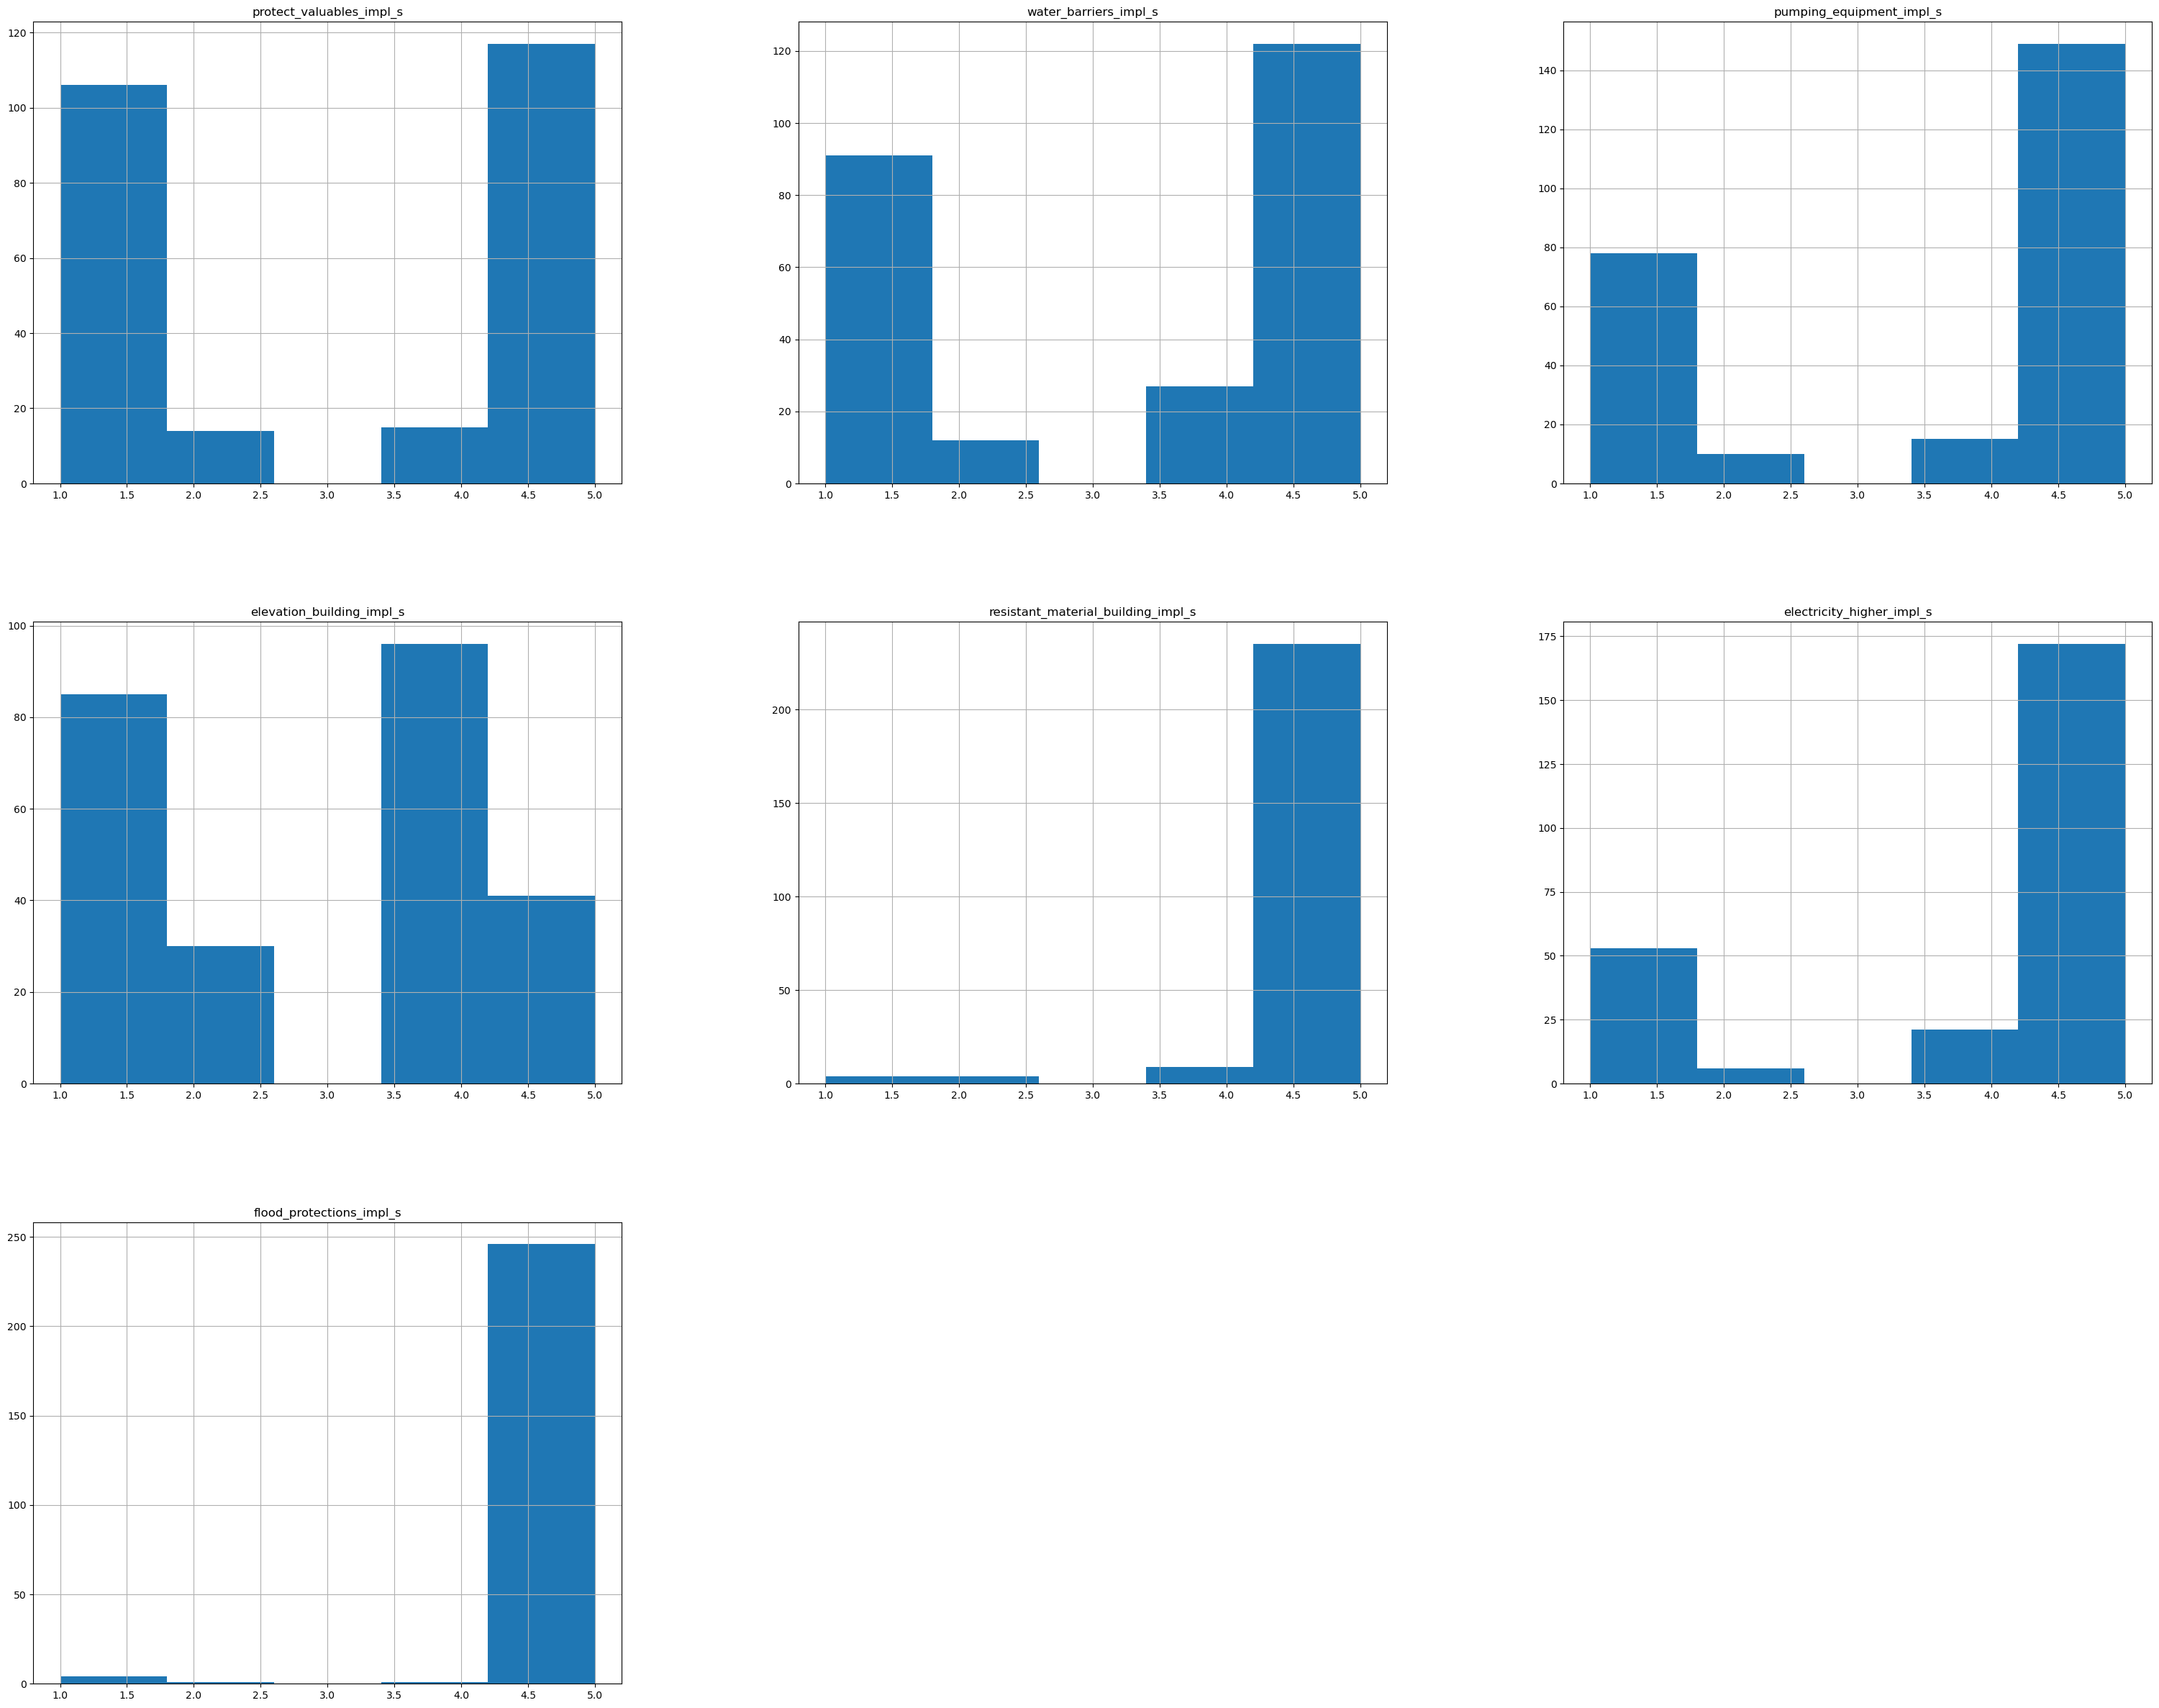

In [29]:
#vars_dam["flood_protections_impl_s"].value_counts() # 2
vars_dam[prec_measures_impl_colnames_s].hist(bins=5, figsize=(38, 30))

# pumping_equipment_impl_s	elevation_building_impl_s	resistant_material_building_impl_s	electricity_higher_impl_s	flood_protections_impl_r

### Socio-economic variables


In [30]:
part4Q1_cols_list = [r"Target_contentloss_*", r"Target_businessreduction_*", 
                        r"^hh_monthly_income_cat",  # = e.g.  "hh_monthly_income_cat"
                        r"^shp_*",  # = e.g "shp_closed_d*", r"shp_sector$", "shp_owner",
                    ]

pattern_part4Q1_cols = re.compile("|".join(part4Q1_cols_list))
vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)

## keep sectors
# shp_sector

## data cleaning
vars_soc = pp.drop_object_columns(vars_soc)
vars_soc = pp.drop_typos(vars_soc).astype("Float64")

#For building variables - during serious and recent events - building age; how long has the 
#householder lived in the location. LU certificate, building cost.
vars_bui = df.loc[:,["lu_cert","b_value_mVND"]]
vars_bui["b_area"] = pp.drop_typos(df.b_area)
vars_bui["b_area"]  = pd.to_numeric(vars_bui["b_area"])
flood_year_r = pd.to_datetime(df["flood_time_r"], format="mixed").dt.strftime("%Y")
flood_year_s = pd.to_datetime(df["flood_time_s"], format="mixed").dt.strftime("%Y")
 
vars_bui["flood_year_r"] = flood_year_r
vars_bui["flood_year_s"] = flood_year_s

In [31]:
vars_soc

Target_contentloss_mVND_r  Target_contentloss_mVND_s   
0                       0.0000                     0.0000  \
1                       0.0000                     0.0000   
2                       0.0000                     0.0000   
3                       0.0000                     0.0000   
4                       0.0000                     0.0000   
..                         ...                        ...   
247                     0.0000                     0.0000   
248                     0.0000                     0.0000   
249                     0.0000                     0.0000   
250                     2.0000                     2.0000   
251                     0.0000                     0.0000   

     Target_businessreduction_r  Target_businessreduction_s   
0                        0.0000                      0.0000  \
1                        0.0000                      0.0000   
2                        0.0000                      0.0000   
3                       99.0000                     99.0000   
4                        0.0000                      0.0000   
..                          ...                         ...   
247                     99.0000                     99.0000   
248                      0.0000                      0.0000   
249                      0.0000                      0.0000   
250                      0.0000                      0.0000   
251                      0.0000                      0.0000   

     shp_damage_level_furniture_r  shp_damage_level_electronics_r   
0                          1.0000                          1.0000  \
1                          1.0000                          1.0000   
2                          1.0000                          1.0000   
3                          1.0000                          1.0000   
4                          1.0000                          1.0000   
..                            ...                             ...   
247                        1.0000                          1.0000   
248                        1.0000                          1.0000   
249                        1.0000                          1.0000   
250                        1.0000                          1.0000   
251                        1.0000                          1.0000   

     shp_damage_level_equipment_r  shp_damage_level_products_r   
0                          1.0000                       1.0000  \
1                          1.0000                       1.0000   
2                          1.0000                       1.0000   
3                          1.0000                       1.0000   
4                          1.0000                       1.0000   
..                            ...                          ...   
247                        1.0000                       1.0000   
248                        1.0000                       1.0000   
249                        1.0000                       1.0000   
250                        1.0000                       4.0000   
251                        1.0000                       1.0000   

     shp_closed_d_r  shp_business_limitation_r  shp_damage_level_furniture_s   
0            0.0000                     0.0000                        1.0000  \
1            0.0000                     0.0000                        1.0000   
2            0.0000                     0.0000                        1.0000   
3            1.0000                     1.0000                        1.0000   
4            0.0000                     0.0000                        1.0000   
..              ...                        ...                           ...   
247          0.0000                     0.0000                        1.0000   
248          0.0000                     0.0000                        1.0000   
249          0.0000                     0.0000                        1.0000   
250          0.0000                     0.0000                        1.0000   
251          

In [32]:
pd.to_datetime(df["flood_time_r"], format="mixed")#.dt.strftime("%Y")

0     2015-01-01
1     2017-09-01
2     2020-08-01
3     2020-07-01
4     2020-07-01
         ...    
247   2019-10-01
248   2019-09-01
249   2017-08-01
250   2019-10-01
251   2018-09-01
Name: flood_time_r, Length: 252, dtype: datetime64[ns]

### Perception variables
The individual perception influences if meaurues for flood protection and prevention are implemented

In [33]:
part3Q1Q2_cols_list = [r"resilience_*", r"^perception_*"] 

pattern_part3Q1Q2_cols = re.compile("|".join(part3Q1Q2_cols_list))
vars_perception = df.filter(regex=pattern_part3Q1Q2_cols, axis=1)
vars_perception = pp.drop_object_columns(vars_perception)


## order ranks
# 1: Maintained  -> 2
# 2: Reduced  -> 1
# 3: Increased -> 3
vars_perception["perception_govern_support_past"] = vars_perception["perception_govern_support_past"].replace({2:1, 1:2})
vars_perception["perception_govern_support_future"] = vars_perception["perception_govern_support_future"].replace({2:1, 1:2})

# 1: Richer (e.g. for preparing and repairing your house) --> 3
# 2: Poorer --> 1
# 3: Same --> 2
vars_perception["perception_private_economy_future"] = vars_perception["perception_private_economy_future"].replace({2:1, 3:2, 1:3})

## replace 88 = others and typos
vars_perception = vars_perception.replace({88: np.nan, 98: np.nan})

vars_soc = pd.concat([vars_soc, vars_perception], axis=1)

### building variables

In [34]:
df.b_movingin = df.b_movingin.replace(99, np.nan)  # P4Q2.1  
df.b_year = df.b_year.replace(99, np.nan)  # P4Q2.2: when was the house constructed [year]?
# flood_year_r : year of (recent) flood event [year]

## extract cases where building construction or moving in of the households was after the flood event
vars_bui["occ_yrs_r"] = flood_year_r.astype("Int64") - df.b_movingin.astype("Int64")  
vars_bui["occ_yrs_s"] = flood_year_s.astype("Int64") - df.b_movingin.astype("Int64")

## NOTE ["bage"] is relative: its the b.age at the time of flood event
vars_bui["bage_r"] = flood_year_r.astype("Int64") - df.b_year.astype("Int64")  # building age at time of flood event
vars_bui["bage_s"] = flood_year_s.astype("Int64") - df.b_year.astype("Int64")


print((vars_bui.occ_yrs_r < 0.0).sum(), "cases in which moving is after recent flood events")
print((vars_bui.occ_yrs_s < 0.0).sum(), "cases in which moving is after serious flood events")
print((vars_bui.bage_r < 0.0).sum(), "cases in which building was constructed after the recent flood event")
print((vars_bui.bage_s < 0.0).sum(), "cases in which building was constructed after the serious flood event")

#For physical damage, if the householder did not live 
#in this house during the reported flood events, we remove those records from further analysis.
#Valid = 1; not valid = 0
vars_bui["valid_r"] = 1
vars_bui["valid_s"] = 1

vars_bui.loc[vars_bui.occ_yrs_r < 0.0, "valid_r"] = 0  # set all cases which moved in or where building was constructed after event to zero
vars_bui.loc[vars_bui.occ_yrs_s < 0.0, "valid_s"] = 0



0 cases in which moving is after recent flood events
0 cases in which moving is after serious flood events
7 cases in which building was constructed after the recent flood event
7 cases in which building was constructed after the serious flood event


In [35]:
## add further building related variables likewise about elevation

#df.filter(regex="elevatio", axis=1)#.value_counts()
vars_bui[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]] = df[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]]
vars_bui = gpd.GeoDataFrame(vars_bui)

##  elevation height relatve to surrounding 
## 1 - same level, 2- house floor is lower, 3 - house floor is higher 
## for case 1 and 2 -> 0, case 3 --> 1
vars_bui["elevation_rel2surrounding_cat"] = df.elevation_rel2surrounding_cat.replace({1:0, 2:0, 3:1})


In [36]:
## add number of floors and building type
vars_bui["address"]  = df["housenumber_street"] 
vars_bui["floors"]  = df["Nr_Floors"] 
vars_bui["buildingtype_moon"]  = df["BT_Moon"] 
vars_bui["buildingtype_moon"]  = vars_bui["buildingtype_moon"].replace({"Shop-Traditional":0, "Shop-New":1, "Doppel/Rowhouse":2, "Rudimental":3, "Villa-Individual":4, "other":5})



### Geolocations
Add geolocations from which a few are improved by Tuebing dataset

In [37]:
vars_bui["geometry"] = df["geometry"]

### Building age at time of flooding

In [38]:
vars_bui.bage_r[vars_bui.bage_r < 0] = np.nan
vars_bui.bage_s[vars_bui.bage_s < 0] = np.nan


In [39]:
vars_bui[["bage_r", "bage_s"]].describe()

bage_r   bage_s
count 235.0000 234.0000
mean   19.8213  18.6709
std    13.6091  13.5877
min     0.0000   0.0000
25%    10.5000  10.0000
50%    19.0000  17.0000
75%    24.0000  23.7500
max   100.0000 100.0000

### Content and building value

Building damage variables

Absolute and relative building loss are not calculated due that they seem to be less important for content loss modelling. 

#### Building value


In [40]:
vars_bui["b_value_mVND"] = df["b_value_mVND"].astype("Int64")  # = P4Q2.5: building value if sell or rebuild completely
vars_bui.b_value_mVND[vars_bui.b_value_mVND == 99.0] = np.nan


#### Content value

Derive content value (cv) from building value (bv)

Registered capital is based on bv + cv (if interviewee is owner)  
US HAZUS uses bv = 100% cv (trade, serivces), bv =150% cv (light+heavy industry, food and metall) 

similar work regarding cv: Chinh 2015, Paprotny2020

In [41]:
## due that only a few buildings have now floor info, the missing floor values are filled by the constant of 2 floors per building
print(vars_bui.floors.describe() )

vars_bui["floors"] = vars_bui["floors"].replace({np.nan:2, 0:2}).astype(int) # replace buildings with missing or unreasonable height
#print(vars_bui.floors.describe() )


count   13.0000
mean     1.4615
std      0.5189
min      1.0000
25%      1.0000
50%      1.0000
75%      2.0000
max      2.0000
Name: floors, dtype: float64


In [42]:
vars_soc.shp_registered_capital_mVND[vars_soc.shp_registered_capital_mVND == 99.0] = np.nan

## total bv an bv of commercial part in mVND in 2020
vars_bui["shp_building_value_mVND"] = vars_bui.b_value_mVND / vars_bui.floors
vars_bui["shp_building_value_mVND"] = vars_bui["shp_building_value_mVND"].astype("Int64")  # Int64 = keep nan
print("Number of businesses for which registered capital is less than value for commercial building part:", (vars_soc.shp_registered_capital_mVND < vars_bui.shp_building_value_mVND).sum())
#print("No building value information: ", vars_bui.shp_building_value_mVND.isna().sum())
#print("No registered capital information: ", vars_soc.shp_registered_capital_mVND.isna().sum())

# ## quick check number of business owner
print(vars_soc.shp_owner.value_counts())  # 1- owner , 2- manager 3 - both, 88 - other


vars_bui["shp_building_value_mVND"].describe()

Number of businesses for which registered capital is less than value for commercial building part: 185
shp_owner
3.0000     125
1.0000     108
2.0000      14
88.0000      5
Name: count, dtype: Int64


count    216.0000
mean     463.7037
std      567.5868
min       30.0000
25%      200.0000
50%      350.0000
75%      500.0000
max     5500.0000
Name: shp_building_value_mVND, dtype: Float64

Due that registered capital can not be used to derive content losses, another apporach is utilitized. 
Business content values are estimated based on the value of the commercial used part of the building (building value / floor number)

In [43]:
# # Alternative approach: 

## Assigne 1/4 of shp_building_value as = shp_content_value
vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND  / vars_bui.floors.astype(int) * 0.25 # shop cv as the ration between bv and number of floors
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 
vars_bui["shp_content_value_mVND"].describe()



count    216.0000
mean     115.6806
std      141.9600
min        7.0000
25%       50.0000
50%       87.0000
75%      125.0000
max     1375.0000
Name: shp_content_value_mVND, dtype: Float64

<!-- Test: is building area a better source to derive content vaule than floor number? -->

In [44]:
vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND / vars_bui.floors.astype(int)  * 0.25 # shop cv as the ration between bv and building footprint
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 

vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"]

vars_bui["shp_content_value_mVND"].describe()
## idea: capital investment * sqrm  = cv 

# HCMC: median in euro (no inflation correction): 13 471 €

# ## with divide by floor number
# # count         216.0
# # mean     496.319444
# # std      601.118519
# # min            30.0
# # 25%           200.0
# # 50%           350.0
# # 75%           500.0
# # max          5500.0

## HCMC new cv (no inflation corrected): median : 3300 €, mean: 4750 € , 1Quantile_ 1916 €

count    216.0000
mean     115.6806
std      141.9600
min        7.0000
25%       50.0000
50%       87.0000
75%      125.0000
max     1375.0000
Name: shp_content_value_mVND, dtype: Float64

In [45]:
vars_bui.buildingtype_moon.value_counts()

buildingtype_moon
0.0000    6
5.0000    3
1.0000    2
2.0000    1
3.0000    1
Name: count, dtype: int64

### Spatial variable
*Currently not used due to the high discrepancy between geolocation from the survey and the actual locations of the shops, derived by the comaprison of HCMC reported geolocations with gmaps and OSM.*

<!-- Add information about terrain height above sea level as a predictor. This is a common approach for geograpihc related issues to improve the predictive power of multi-variate models by adding spatial information. -->

In [46]:
# dem__lufi_pts = gpd.read_file("../input_survey_data/DEM_LiDAR/HCMC_Lidar_2020_DEM_4326_LuFi_points.shp")  # shop locations including elevation height based on original and interpolated DEM

# dem__lufi_pts = gpd.GeoDataFrame(dem__lufi_pts,  
#             geometry=gpd.points_from_xy( 
#                      dem__lufi_pts["geometry"].x,  # lon
#                      dem__lufi_pts["geometry"].y, #lat
#             )
#         )

# ## crs of 4326 is in degree unit

In [47]:
# ## assigne DEM point locations to shp location of dataframe, silght differences in coordinates due to conversion
# vars_bui = gpd.sjoin_nearest(vars_bui, dem__lufi_pts, how="left")
# vars_bui = vars_bui.set_geometry("geometry")
# vars_bui = vars_bui.drop(["index_right"], axis=1)


In [48]:
# ## replace locations with missing elevation by interpolated DEM (all locations with missing elevation height have value 0.0 )
# #print(vars_bui[vars_bui.HCMC_Lidar==0.0])
# vars_bui.HCMC_Lidar = np.where(vars_bui.HCMC_Lidar==0.0, vars_bui.LuFIDEMInt, vars_bui.HCMC_Lidar)

In [49]:
# vars_bui = vars_bui.rename(columns={"HCMC_Lidar":"elevation_m"})
# vars_bui = vars_bui.drop("LuFIDEMInt", axis =1)
# vars_bui.insert(len(vars_bui.columns)-2, "elevation_m", vars_bui.pop("elevation_m"))


## Timeline: direct and indiect flood damage [€] for all flood events 

x axis= years
y = reported damage to inventory and calc. loss due to business reduction 

dont seperate by flood events (count severe and recent ) 

## Compare severe and most recent floods

In [50]:
## merge all vars ending with _r or _s into on df for plotting


df_recent = pd.concat(
    [vars_bui["bage_r"],
        vars_dam[["inundation_duration_h_r", "water_depth_cm_r",  "flowvelocity_r", 
                "contaminations_r.0", "contaminations_r.1",	"contaminations_r.2", "contaminations_r.3", "contaminations_r.4",
                "emergency_measures_r.1", "emergency_measures_r.2", "emergency_measures_r.3", "emergency_measures_r.4", "emergency_measures_r.7", "emergency_measures_r.8" ]],
        vars_soc[["Target_contentloss_mVND_r", "Target_businessreduction_r"]]], 
    axis=1)

df_severe = pd.concat(
    [vars_bui["bage_s"],
        vars_dam[["inundation_duration_h_s", "water_depth_cm_s",  "flowvelocity_s", 
                "contaminations_s.0", "contaminations_s.1",	"contaminations_s.2", "contaminations_s.3", "contaminations_s.4",
                "emergency_measures_s.1", "emergency_measures_s.2", "emergency_measures_s.3", "emergency_measures_s.4", "emergency_measures_s.7", "emergency_measures_s.8" ]],
        vars_soc[["Target_contentloss_mVND_s", "Target_businessreduction_s"]]], 
    axis=1)


## remove endings
df_recent.columns = df_recent.columns.str.replace("_r", "")
df_recent.columns = df_recent.columns.str.replace("_1$", "", regex=True)

df_severe.columns = df_severe.columns.str.replace("_s", "")
# sev.columns = sev.columns.str.replace("2$", "", regex=True) 
df_severe.columns = df_severe.columns.str.replace("_2$", "", regex=True) 



(468, 18)


Text(1120.2881944444443, 0.5, '')

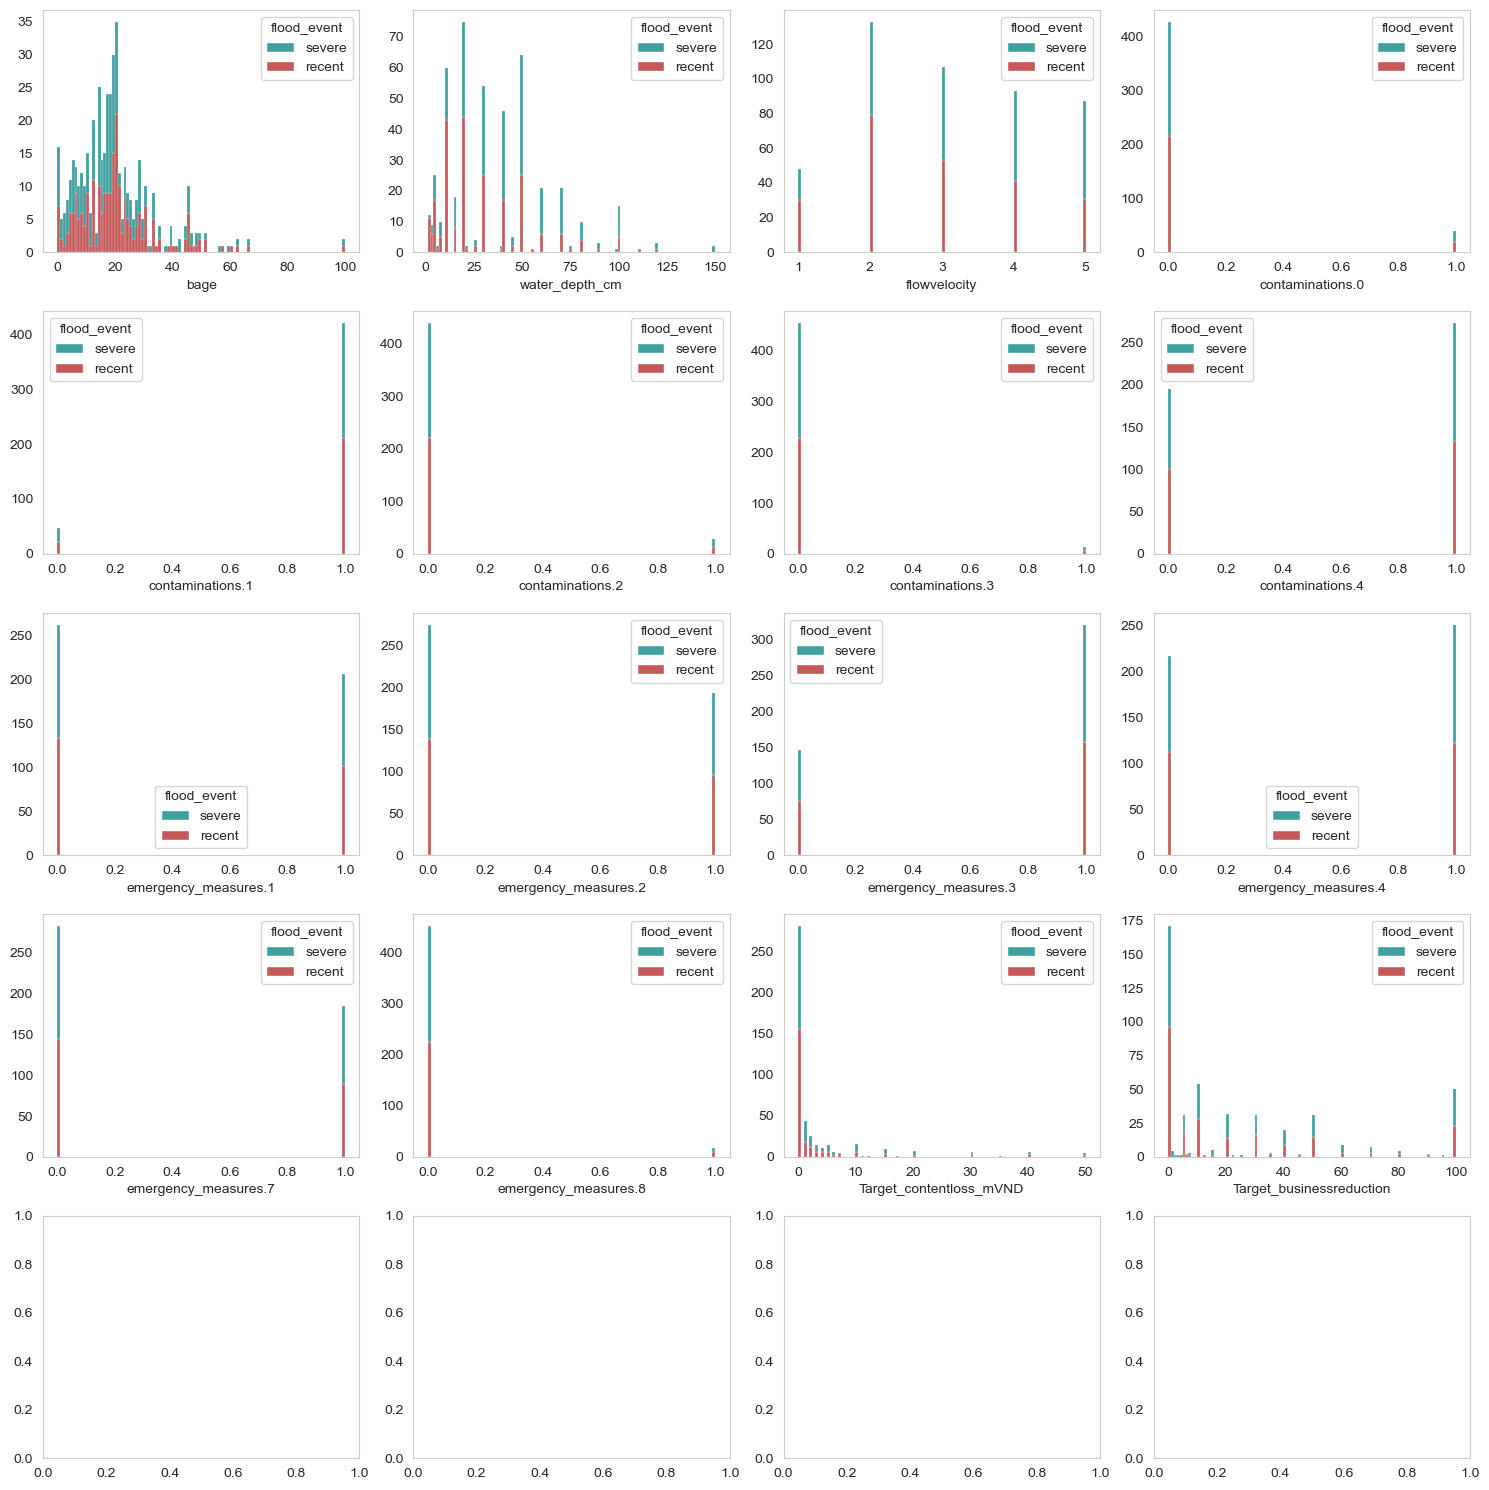

In [51]:
import seaborn as sns
from matplotlib.colors import to_rgba


# df_cantho_p = df_cantho[df_hcmc_p.columns]

## add col for hue plotting
df_severe["flood_event"] = "severe"
df_recent["flood_event"] = "recent"

# merge df for plotting
df_merged_p = pd.concat([df_severe, df_recent], axis=0).reset_index(drop=True)
df_merged_p = df_merged_p.dropna()

## fix miss spellings and NAN handling by changing data type
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace(",2", "2")
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace(",5", "5")
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace("1,5", "1")
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace("", np.nan)
df_merged_p["inundation_duration_h"] = df_merged_p["inundation_duration_h"].astype(float)
df_merged_p["inundation_duration_h"] = df_merged_p["inundation_duration_h"].astype("int64")

df_merged_p["bage"] = df_merged_p["bage"].astype("int64")
df_merged_p["Target_contentloss_mVND"] = df_merged_p["Target_contentloss_mVND"].astype("int64")
df_merged_p["Target_businessreduction"] = df_merged_p["Target_businessreduction"].astype("int64")

# df_merged_p.info()  # check that datatypes are plotable 
print(df_merged_p.shape)

## style settings
sns.set_style("whitegrid", {"axes.grid" : False})
hue_colors=("teal", "firebrick")
alpha=0.3
color_dict = {"severe": to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        "recent": to_rgba(hue_colors[1], alpha)}
numcols = 4
legend = True
bins = 100 # np.linspace(0, 10, 100)


# ## shorten vlaue ranges of few vars for better plotting
df_merged_p.Target_contentloss_mVND[df_merged_p["Target_contentloss_mVND"] > 60] = np.nan   # 9 cases (3 cases recent + 6 serious) 


## plot
fig, axes = plt.subplots( 1 + len(df_merged_p.columns)//numcols, numcols, figsize=(15, 15), constrained_layout=True)
# bage inundation_duration_h
l = ['bage', 'water_depth_cm', 'flowvelocity',
       'contaminations.0', 'contaminations.1', 'contaminations.2',
       'contaminations.3', 'contaminations.4', 'emergency_measures.1',
       'emergency_measures.2', 'emergency_measures.3', 'emergency_measures.4',
       'emergency_measures.7', 'emergency_measures.8',
       'Target_contentloss_mVND', 'Target_businessreduction']
## plot histos
for col, ax in zip(df_merged_p[l].columns, axes.flat):
    # print(col)
    p = sns.histplot(
        df_merged_p,  
        x=col, 
        hue="flood_event", stat="count",
        bins=bins,
        multiple='stack',
        palette=color_dict, 
        legend=legend,
        # binwidth=.5,
        ax=ax).set_ylabel("")
    plt.tight_layout()
    # if legend is True:
    #     plt.setp(p.get_legend().get_texts(), fontsize="12")  
    #     plt.setp(p.get_legend().get_title(), fontsize="15")

#fig.get_figure().savefig("../figures/histo_severe_recent.png", dpi=300, bbox_inches="tight")
p

## Select predictors and merge identical events


In [52]:
vars_bui = vars_bui.drop(["occ_yrs_r", "occ_yrs_s", "valid_r", "valid_s"],axis=1)


In [53]:
vars_dam["id"] = range(len(df))

vars_dam = pp.drop_typos(vars_dam)

## select cases with recent events and non specific cols
data_ip1 = pd.concat(
  [vars_dam.loc[:, "flood_time_r":"overall_problem_house_r.9"],  # flood vars, damage vars
    vars_dam.loc[:,"same":"flood_protections_impl_r"],  #  same, precaution measures, 
    vars_dam.loc[:,["flood_experience"]], 
    #vars_dam.loc[:, ["rloss_1", "bloss_1"]], 
 ], axis=1
)

print(f"Identical events are: {(vars_dam.same==True).sum()}")

## drop unique endings to obtain identical column names in both dfs
data_ip1.columns = data_ip1.columns.str.replace("_r", "")
data_ip1.columns = data_ip1.columns.str.replace("_1", "") 



## if not identical event select serious events
for i in range(len(data_ip1.loc[:,:])):  
  if (data_ip1.same[i]==False):   #  events are different, select also serious event
    sev = pd.concat(
        [vars_dam.loc[i, "flood_time_s" : "overall_problem_house_s.9"],  # flood-vars, damage-vars
         vars_dam.loc[i, ["same"]],
         vars_dam.loc[i, "protect_valuables_impl_s": "flood_experience"],  # precaution measures, flood experience
         #vars_dam.loc[i, ["rloss_2", "bloss_2"]]
        ]
    )

    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns =sev.columns.str.replace("_s", "") 
    sev.columns =sev.columns.str.replace("_2", "") 
    sev[1:] = sev[1:].apply(pd.to_numeric)  # exclude datetime-column: flood_time

    ## append events which are not identical to a recent event
    data_ip1 = pd.concat([data_ip1, sev], ignore_index=True)



Identical events are: 107


In [54]:
vars_bui["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip2 = pd.concat(
  [vars_bui.loc[:, ["flood_year_r", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
    vars_bui.loc[:, ["bage_r", "b_area", "geometry"]],
    vars_bui.loc[:, ["floors", "buildingtype_moon"]], 
    vars_bui.loc[:, "shp_building_value_mVND": "id"],
    ], axis=1
)
data_ip2.columns = data_ip2.columns.str.replace("1","")
data_ip2.columns = data_ip2.columns.str.replace("_r$", "", regex=True) 

## if not identical event select serious events
for i in range(len(data_ip2.loc[:,:])): 
  if (vars_dam.same[i]==False):
    sev = pd.concat(
        [vars_bui.loc[i, ["flood_year_s", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
            vars_bui.loc[i, ["bage_s", "b_area", "geometry"]], 
            vars_bui.loc[i, ["floors", "buildingtype_moon"]], 
            vars_bui.loc[i, "shp_building_value_mVND": "id"]
        ]
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace("_s", "")
    sev.columns = sev.columns.str.replace("2$", "", regex=True) 

    ## append events which are not identical to a recent event
    data_ip2 = pd.concat([data_ip2, sev], ignore_index=True)


In [55]:
vars_soc["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip3 = pd.concat(
  [vars_soc.loc[:, ["Target_contentloss_mVND_r", "Target_businessreduction_r", "shp_business_limitation_r"]],#[:,:4],
    vars_soc.loc[:, "hh_monthly_income_cat":] #  monthly_income, firm specific variables eg. ownership, monthly sale.., resilience and perception vars
      ], axis=1
)

#sev_list = []
data_ip3.columns = data_ip3.columns.str.replace("_r$", "", regex=True) 

## if not identical event select serious events
for i in range(len(data_ip3.loc[:,:])): 
  if (vars_dam.same[i]==False):  
    sev = pd.concat(
        [vars_soc.loc[i, ["Target_contentloss_mVND_s", "Target_businessreduction_s", "shp_business_limitation_s"]],
            vars_soc.loc[i, "hh_monthly_income_cat":]
        ], 
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace("_s$", "", regex=True) 

    #sev_list.append(sev)
    ## append not identical events to end of df
    data_ip3 = pd.concat([data_ip3, sev], ignore_index=True)


In [56]:
## Business sectors per microbusiness


## combine business sectors into two or three main casses to see if they are importnat for rloss quantification
vars_soc.shp_sector.value_counts()

vars_soc["shp_sector"] = vars_soc["shp_sector"].replace(
    {
        11.0 : 1,     # 1. Shop/Retailer
        12.0 : 1, 
        13.0 : 1, 
        14.0 : 1, 
        15.0 : 1, 
        16.0 : 1, 
        17.0 : 1, 
        11.0 : 1, 
        11.0 : 1, 
        11.0 : 1, 
        21.0 : 2,     # 2. Services 
        22.0 : 2, 
        23.0 : 2, 
        24.0 : 2,
        31.0 : 3,     # 3. Production
        32.0 : 3, 
        33.0 : 3, 
        34.0 : 3, 
        35.0 : 3, 
        88.0 : np.nan,
    }
)
vars_soc.shp_sector.value_counts()

shp_sector
1.0000    182
2.0000     40
3.0000     18
Name: count, dtype: Int64

In [57]:

## check how many microbuinesses reported one [False] or two [True] flood events
mb_events = pd.concat([vars_dam, vars_soc], axis=1)
mb_events.loc[(mb_events.shp_employees < 10.0), :].same.value_counts()

same
False    145
True     105
Name: count, dtype: int64

In [58]:
## add geometries for creation of Maps (e.g. FP,TN,TP, FN map for classification and BN modelling)
data_ip4 = df.geometry

### Combine all important variabels 

In [59]:
## merged cases
all_input = pd.concat(
        [data_ip1.loc[:, data_ip1.columns != "id"], 
        data_ip2.loc[:, data_ip2.columns != "id"],
        data_ip3,
        data_ip4
        ], axis=1
)
all_input.shape

(397, 88)

Number of cases is larger than from Rscript, due that col "same" incoporates flood times and more varibles are used.

 2*145 + 1 * 107 = 397 cases [count different events twice, identical events once]

In [60]:
## check ratio of  many event reported one or two flood events
all_input.loc[~(all_input.shp_employees >= 10.0), :].same.value_counts()

same
False    290
True     105
Name: count, dtype: int64

## Microbusinesses
Use only microbusineess for flood loss estimation and identification of drivers, due that small and medium shops have a too different structure in the processes that caused content losses and business reductions

In [61]:
print( len(df.loc[df.shp_employees < 10.0, :]))
df = df.loc[~(df.shp_employees >= 10.0), :]
print(df.shape)
df.shp_employees.describe()

df.shp_employees.value_counts()

250
(250, 555)


shp_employees
1    120
2     91
3     18
4     12
6      4
7      2
5      2
9      1
Name: count, dtype: int64

# Feature reduction and transformation


Simple approaches to reduce Multicollinearity:
- zero variance features
- Remove some of the highly correlated independent variables - Not APPLIED yet in subsequent part of the script - their influence in FS models is tested first and than they will be removed here and a combined indicator for resilience features will be tested on model performance
- Linearly combine the independent variables, such as adding them together - APPLIED in subsequent part of the script
- Partial least squares regression uses principal component analysis to create a set of uncorrelated components to include in the model.
- apply regularized linear models such as elastic net - APPLIED in Feature selection section
Some features might be less important for model performance, they are left in feature space so far.


#### Minor cleaning 

Fix commas and 99, empty columns, spatial drop

Empty cells or the interviewee could not answer the question (“I don’t know”) were all set to missing number (not a number: NaN) and for dates to missing date (not a date: NaT). Nulls were left unchanged, ie. for the target variables for which it is assumed that the interviewee had no direct or indirect content losses.

In [62]:
all_input["shp_employees"] = all_input["shp_employees"].astype("Int64")
all_input["shp_employees"].describe()


count   397.0000
mean      1.9370
std       2.0396
min       1.0000
25%       1.0000
50%       2.0000
75%       2.0000
max      34.0000
Name: shp_employees, dtype: Float64

In [63]:
# fix data types
all_input.flood_time = pd.to_datetime(all_input.flood_time, format="mixed")


## fix obj columns - convert to numeric by keeping nan values
all_input_obj = all_input.select_dtypes(include=object)  # all obj cols
all_input_obj =all_input_obj.drop("geometry", axis=1)

for c in all_input_obj.columns:
    all_input[c]  =  pp.drop_typos(all_input_obj[c]).apply(pd.to_numeric)  # convert to int or float,  handles NAN

all_input = all_input.replace(99, np.nan)

### Variance and collinearity of features before Feature Reduction

Remove features with zero or near zero variance or merge them into indicators. Do this in respect to the amount of missing data stored in the features. Reduce colinearity between similar features by mergin them into indicators

In [64]:
## drop of columns which were only needed to develop the datasets

all_input = all_input.drop(
    [
        "flood_time", "flood_year", "id", "same", #"geometry",  # keep geoms for results to plot in MAPs
    ],  
    axis=1
    )

In [65]:
## move targets to beginning
all_input.insert(0, "Target_contentloss_mVND", all_input.pop("Target_contentloss_mVND"))
all_input.insert(1, "Target_businessreduction", all_input.pop("Target_businessreduction"))

# plt.figure(figsize=(18,18))
# f.plot_spearman_rank(all_input.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)


In [66]:
# pp.percentage_of_nan(all_input_p)

In [67]:


X_scaled = MinMaxScaler().fit_transform(
    all_input.drop(
        ["Target_contentloss_mVND", "Target_businessreduction", "geometry"], 
        axis=1
    )
)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=all_input.drop(["Target_contentloss_mVND", "Target_businessreduction", "geometry"], axis=1).columns
)


df_variance = X_scaled.var()
df_variance = np.round(df_variance, 5)
print(pd.DataFrame({"variance":df_variance}).sort_values("variance").head(25))

var = []
for i in range(0, len(df_variance)):
    if df_variance[i] != 0.00000:
            var.append(X_scaled.columns[i])
df_variance = pd.DataFrame({"variance":df_variance}).sort_values("variance")

                                             variance
shp_suppliers_location.6                       0.0000
perception_who_responsible4protection.Rank5    0.0000
perception_who_responsible4protection.Rank7    0.0000
perception_who_responsible4protection.Rank6    0.0000
shp_registered_capital_mVND                    0.0031
shp_business_limitation                        0.0032
shp_employees                                  0.0038
inundation_duration_h                          0.0049
shp_suppliers_location.5                       0.0050
shp_building_value_mVND                        0.0085
shp_content_value_mVND                         0.0085
b_area                                         0.0098
shp_suppliers_location.4                       0.0100
overall_problem_house.9                        0.0149
flood_protections_impl                         0.0188
shp_owner                                      0.0194
bage                                           0.0196
elevation_building_height_cm

In [68]:
pp.percentage_of_nan(all_input)

01-15-2025 04:47:41 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 perception_who_responsible4protection.Rank7   99.0000
perception_who_responsible4protection.Rank6   99.0000
perception_who_responsible4protection.Rank5   99.0000
buildingtype_moon                             94.0000
perception_who_responsible4protection.Rank4   91.0000
warning_time_h                                78.0000
perception_who_responsible4protection.Rank3   69.0000
perception_who_responsible4protection.Rank2   39.0000
perception_govern_support_past                38.0000
geometry                                      37.0000
perception_govern_support_future              34.0000
elevation_building_height_cm                  16.0000
shp_content_value_mVND                        16.0000
shp_building_value_mVND                       16.0000
resilience_govern_careing_increases           14.0000
dtype: float64


In [69]:
## drop frther columns which were only needed to develop the datasets, are qualitative features or are empty

all_input = all_input.drop(
    [
        "warning_time_h", # less importnat for a flood-proven society and contains many missing values 
        "shp_suppliers_location.1", "shp_suppliers_location.2", "shp_suppliers_location.3",   #  qualitative variables not usable for Bayesian Network
        "shp_suppliers_location.4", "shp_suppliers_location.5", "shp_suppliers_location.6",
        #"shp_sector",  # qualitative variable not usable in NPBN for continous variables
        "shp_owner",   # qualitative variable not usable in NPBN for continous variables
        "perception_who_responsible4protection.Rank7",   # empty features + qualitative feature
        "perception_who_responsible4protection.Rank6", "perception_who_responsible4protection.Rank5", # empty features + qualitative feautre
        "perception_who_responsible4protection.Rank4", "perception_who_responsible4protection.Rank3",
        "perception_who_responsible4protection.Rank2", "perception_who_responsible4protection.Rank1",
        "buildingtype_moon",  #  rather qualitative variables not usable for Bayesian Network
        "shp_finance_investments", # qualitative variable
        "shp_building_value_mVND", # not seen as potential predictor, used to derive content value
        "overall_problem_house.1",  # only inidcating if a problem on the building occured or not -> its infomration is captured by similar features
        "shp_risk_tolerance",       # remove to remove collinearity, it"s imfornation is potenitally caputred in applied/not applied precautioin and emergency meausres
    ], axis=1
)

Based on the variance of the features, collineraties and the amount of missing values er feature following decisions are done:

**Merge**
- merge contamination to one or two indicators (if two indicators: one for light and one for heavy contamination)
- merge emergency measures to ratio of implemented / potentially implemented
- merge resilience predictors or remove them, due that no monotonic relation could be seen to both target variables
- merge perception predictors if possible
- combine damages on the building into a single predictor ("overall_problem_house"). stronger damage on walls/floor -> can influence flood-losses on shop content . Cracks, mold, stronger damage on walls/floor  --> the length of business reduction.
It is assumed that stronger building damages influence content loss and business reduction much more than minor building damages. Minor damages might not at all influence the resposne variables 

**Remove**

--> remove all features for perception_who_repsonsible4protection due that the only remaining Rank is binary and wouldnt be usable in the final Bayesian network version which relys on continous data. Moreover the Ranks are qualitative

--> remove warning_time_h : assumed that it is less important predictor for a flood-proven society

--> remove shp_supplier_locations due that they are qualitative e.g. the distance to a supplier outside the city can be shorter than to another supplier located inside the city but in a far away district

**Keep**

Keep following features with low variation due that they are seen in other studies as important predictors. 
Likewise socio-economic features and predictors describing the shop characteristics seemst to be potential important flood-loss influencing variables 
- b_area, 
- shp_registered_capital_mVND, 
- shp_employees, 
- inundation_duration_h, 
- shp_content_value_mVND 


Keep all resilience related features. they are potentially captured by implemented precaution and emergency measures, but this relation can be tested in the Bayesian network if needed [ "resilience_city_protection", "resilience_left_alone",
      "resilience_neighbor_management", "resilience_more_future_affected","resilience_govern_careing", "resilience_govern_careing_increases",
]

*Some features might be less important for model performance, they are left in feature space so far*

In [70]:
all_input.shape

(397, 64)

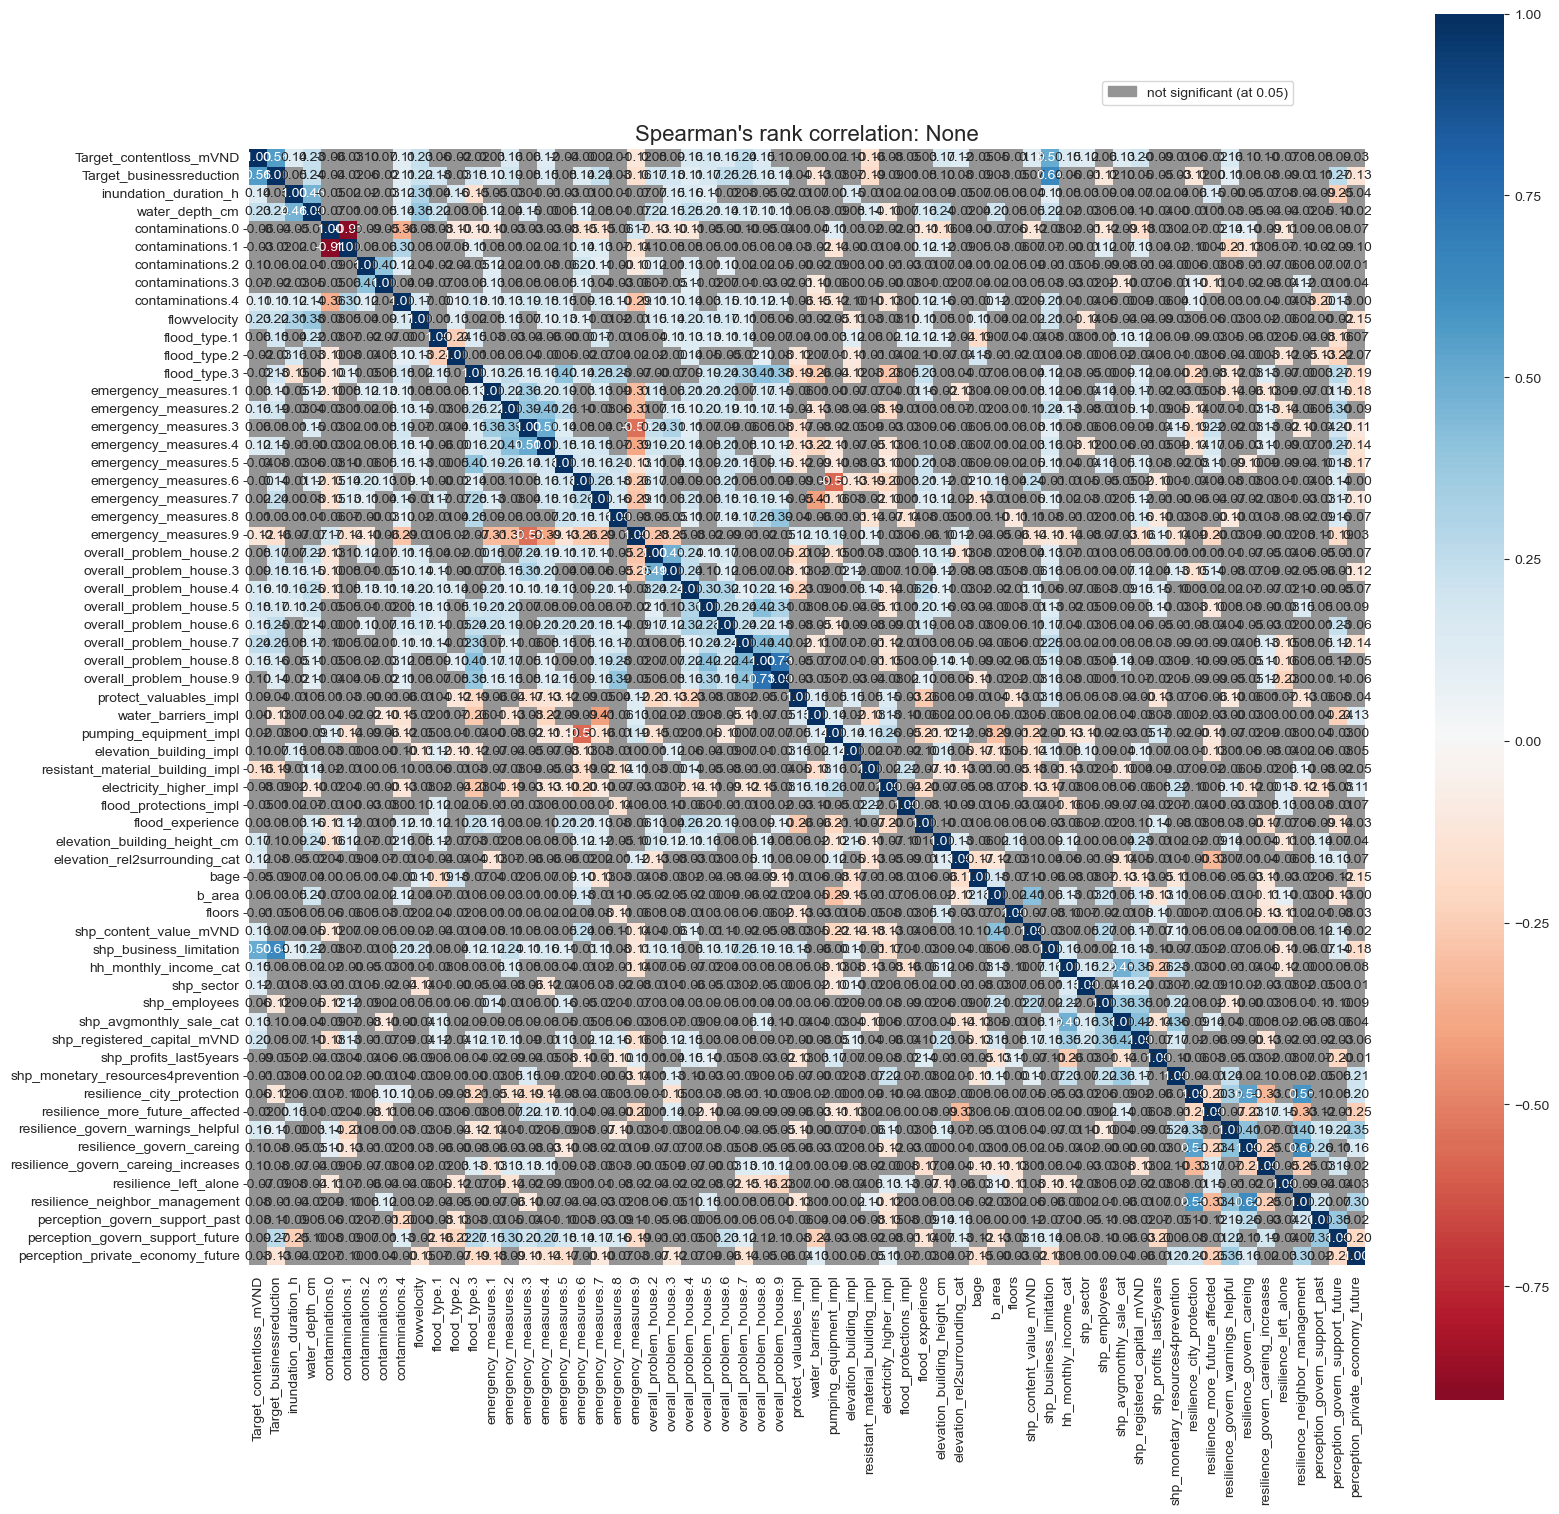

In [71]:
plt.figure(figsize=(18,18))
f.plot_spearman_rank(all_input.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)


### Multicollinearity

- VIF >10 : high correlation with other features
- VIF <5: medium correlation

**Mulitcollinear features are only explored -> the results from the exploration are implemented in chapter "Indicators"** 

In [72]:
## first reduce multicollineary in predictor set by normalization
## Our goal is to have less multicollineary in our model training
## Note normalization already reduces the avarge VIF score remarkably 

X = all_input.drop(["Target_contentloss_mVND", "Target_businessreduction", "geometry"], axis=1)
## reset index due that some samples are removed
X = X.reset_index(drop=True)

scaler = MinMaxScaler()
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=X.columns)
X_scaled.head(5)

inundation_duration_h  water_depth_cm  contaminations.0  contaminations.1   
0                 0.0030          0.0604            1.0000            0.0000  \
1                 0.0030          0.0940            0.0000            1.0000   
2                 0.0013          0.0067            1.0000            0.0000   
3                 0.0047          0.0604            1.0000            0.0000   
4                 0.0047          0.0268            0.0000            1.0000   

   contaminations.2  contaminations.3  contaminations.4  flowvelocity   
0            0.0000            0.0000            0.0000        0.2500  \
1            0.0000            0.0000            0.0000        0.2500   
2            0.0000            0.0000            0.0000        0.2500   
3            0.0000            0.0000            0.0000        0.0000   
4            0.0000            0.0000            1.0000        0.5000   

   flood_type.1  flood_type.2  flood_type.3  emergency_measures.1   
0        1.0000        0.0000        0.0000                0.0000  \
1        1.0000        1.0000        0.0000                0.0000   
2        0.0000        1.0000        0.0000                0.0000   
3        0.0000        1.0000        0.0000                0.0000   
4        0.0000        1.0000        0.0000                0.0000   

   emergency_measures.2  emergency_measures.3  emergency_measures.4   
0                0.0000                0.0000                0.0000  \
1                0.0000                0.0000                0.0000   
2                0.0000                0.0000                0.0000   
3                0.0000                0.0000                0.0000   
4                0.0000                0.0000                0.0000   

   emergency_measures.5  emergency_measures.6  emergency_measures.7   
0                0.0000                0.0000                0.0000  \
1                0.0000                0.0000                0.0000   
2                0.0000                0.0000                0.0000   
3                0.0000                0.0000                0.0000   
4                0.0000                0.0000                0.0000   

   emergency_measures.8  emergency_measures.9  overall_problem_house.2   
0                0.0000                1.0000                   0.0000  \
1                0.0000                1.0000                   0.0000   
2                0.0000                1.0000                   1.0000   
3                0.0000                1.0000                   1.0000   
4                0.0000                1.0000                   1.0000   

   overall_problem_house.3  overall_problem_house.4  overall_problem_house.5   
0                   0.0000                   0.0000                   0.0000  \
1                   0.0000                   0.0000                   0.0000   
2                   0.0000                   0.0000                   0.0000   
3                   1.0000                   1.0000                   0.0000   
4                   0.0000                   0.0000                   0.0000   

   overall_problem_house.6  overall_problem_house.7  overall_problem_house.8   
0                   1.0000                   0.0000                   0.0000  \
1                   0.0000                   1.0000                   0.0000   
2                   0.0000                   0.0000                   0.0000   
3                   0.0000                   0.0000                   0.0000   
4                   0.0000                   0.0000                   0.0000   

   overall_problem_house.9  protect_valuables_impl  water_barriers_impl   
0                   0.0000                  1.0000               1.0000  \
1                   0.0000                  1.0000               1.0000   
2                   0.0000                  0.0000               1.0000   
3                   0.0000                  0.0000               0.0000   
4                   0.0000      

In [73]:
# print("Percentage of missing values per feature [%]\n", round(X_scaled.isna().mean().sort_values(ascending=False)[:20]  * 100), 2) 
pp.percentage_of_nan(X_scaled)

01-15-2025 04:48:48 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 perception_govern_support_past        38.0000
perception_govern_support_future      34.0000
elevation_building_height_cm          16.0000
shp_content_value_mVND                16.0000
resilience_govern_careing_increases   14.0000
shp_registered_capital_mVND           12.0000
bage                                   7.0000
perception_private_economy_future      7.0000
hh_monthly_income_cat                  6.0000
resilience_govern_careing              6.0000
resilience_govern_warnings_helpful     5.0000
shp_monetary_resources4prevention      5.0000
resilience_more_future_affected        4.0000
resilience_city_protection             4.0000
shp_profits_last5years                 4.0000
dtype: float64


In [74]:
df_vif = pd.DataFrame()
df_vif["X_features"] =  X_scaled.columns

## fill features with the most of missing values with median, only for VIF calculation
for feature in ["shp_registered_capital_mVND", "elevation_building_height_cm",  
                "shp_content_value_mVND", "resilience_govern_careing_increases",
                "perception_govern_support_future", "perception_govern_support_past"]:
    X_scaled[f"{feature}"] = X_scaled[f"{feature}"].replace(np.nan, np.nanmedian(X_scaled[f"{feature}"]))


X_scaled_drop_nan = X_scaled.dropna()
X_scaled_drop_nan = X_scaled_drop_nan.reset_index(drop=True)

print(X_scaled.shape)
print(X_scaled_drop_nan.shape)

df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )


(397, 60)
(262, 60)


01-15-2025 04:48:49 - __feature_selection__ - INFO - averaged VIF score is around: 12.0


                               names  vif_scores
0                   contaminations.1    144.7569
1             flood_protections_impl     90.5806
2   resistant_material_building_impl     47.1633
3              resilience_left_alone     44.1359
4                             floors     38.2929
5   perception_govern_support_future     32.7202
6                   flood_experience     17.0725
7                   contaminations.0     16.9694
8              hh_monthly_income_cat     14.8149
9        shp_registered_capital_mVND     13.5443
10           overall_problem_house.2     12.9772
11    perception_govern_support_past     11.6879
12   resilience_more_future_affected     10.8706
13           shp_business_limitation     10.5739
14    resilience_neighbor_management     10.4322


In [75]:
X_scaled_drop_nan = X_scaled_drop_nan.drop([
      "shp_profits_last5years", "shp_monetary_resources4prevention",# information can be captured in e.g. precuationary measures, e.g. increased profits --> purchased more precautionry meausres
      "emergency_measures.5", # saving elderly and kids -> not important for commercial sector
      "emergency_measures.6", # pumping eq captured in Precautionary measures, 
      "emergency_measures.9", # action/no action
      #"elevation_building_height_cm",  # keep it due its small multicollinearity, still its information is included in elevation_impl 
      "elevation_rel2surrounding_cat",  # remove due that its information is covered in other elevation features
      #"geometry",
      ], axis=1
)
X_scaled_drop_nan.shape

(262, 54)

The average degree of Multicollinearity is quite high with a score of around 10.

As already seen in the previous Spearman Rank Order matrics, some features should be merged into a single indicator or alternatively should be removed from feature space if they are not important.
- contaminiations into one or two indicators 
- overall_problem_house features: merge into indicator
-  perception features: merge into indicator
-  resilience features: merge into indicator


Other strong collinear features are left unchanged .e.g precuationary measures (*_impl) in the dataset due that they seem to be important

*Merge the aforementioned feautres and check the VIF scores again*

In [76]:
X_scaled_drop_nan["contaminations"] = None
X_scaled_drop_nan["overall_problem_house"] = None
X_scaled_drop_nan["emergency_measures"] = None


# rank contamination according to their occurence and damage potential: 0:no contamination, 1:light contamination and 2:heavy contamination
## light contamination
X_scaled_drop_nan.contaminations = np.where( 
    (X_scaled_drop_nan["contaminations.1"]==1) | 
    (X_scaled_drop_nan["contaminations.4"]==1) ,
    1, 0
) 
## heavy contamination
idx_heavy_contamination = np.where(
    (X_scaled_drop_nan["contaminations.2"]==1) |
    (X_scaled_drop_nan["contaminations.3"]==1)
)
X_scaled_drop_nan.contaminations[idx_heavy_contamination[0].tolist()] = 2


## overall problem building
X_scaled_drop_nan.overall_problem_house = np.where( (X_scaled_drop_nan["overall_problem_house.2"]==1), 1, 0) 

idx = np.where(X_scaled_drop_nan["overall_problem_house.3"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 2

idx = np.where(X_scaled_drop_nan["overall_problem_house.4"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 3

idx = np.where(X_scaled_drop_nan["overall_problem_house.5"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 4

idx = np.where(X_scaled_drop_nan["overall_problem_house.6"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 5

idx = np.where(
    (X_scaled_drop_nan["overall_problem_house.7"]==1) | 
    (X_scaled_drop_nan["overall_problem_house.8"]==1) |
    (X_scaled_drop_nan["overall_problem_house.9"]==1)
)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 6


## emergency easures - merged binray feautres into on multiclass inidcator 
pattern = [r"emergency_measures.?"] 
pattern_cols = re.compile("|".join(pattern))
df_emergency = X_scaled_drop_nan.filter(regex=pattern_cols, axis=1)
## create indicator as ratio between implemented and potentially implemented emergency measures
X_scaled_drop_nan["emergency_measures"] = df_emergency.eq(1).sum(axis=1) #/ len(df_emergency.columns)



X_scaled_drop_nan = X_scaled_drop_nan.drop([
            "contaminations.0", "contaminations.1", "contaminations.4", 
            "contaminations.2", "contaminations.3",
            "overall_problem_house.2", "overall_problem_house.3", "overall_problem_house.4",
            "overall_problem_house.5", "overall_problem_house.6", "overall_problem_house.7", "overall_problem_house.8",
            "overall_problem_house.9",
            "emergency_measures.1", "emergency_measures.2", "emergency_measures.3", "emergency_measures.4",
            "emergency_measures.7", "emergency_measures.8",
            ], axis=1)


In [77]:
df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )

01-15-2025 04:48:49 - __feature_selection__ - INFO - averaged VIF score is around: 10.1


                               names  vif_scores
0             flood_protections_impl     65.5236
1              resilience_left_alone     36.9447
2   resistant_material_building_impl     36.8038
3                             floors     28.1997
4   perception_govern_support_future     27.6942
5                   flood_experience     14.2207
6              hh_monthly_income_cat     11.6434
7        shp_registered_capital_mVND     10.7999
8     perception_govern_support_past     10.0838
9    resilience_more_future_affected      9.2753
10    resilience_neighbor_management      8.6698
11           shp_business_limitation      8.0232
12                    contaminations      7.9641
13                     shp_employees      7.6748
14         resilience_govern_careing      6.9646


The again applied VIF score shows that merging contaminations, overall problem of the house and emergency measures into single indicators  reduces the average VIF score slightly under 10.

--> perception and resilience featues should be combined as inidcators or be removed 

*Be aware* : By merging feautres into indicators, information can be lost or remarkable characteristics of one feature are less expressive in a combined indicator than compared to nth single features

*Be aware* : removing features with high collinearity from the dataset changes the VIF score of the remaining feautres, so only removing feautres is not a good solution to reduce multicollinearity

- VIF >10 : high correlation with other features
- VIF <5: medium correlation


(262, 38)

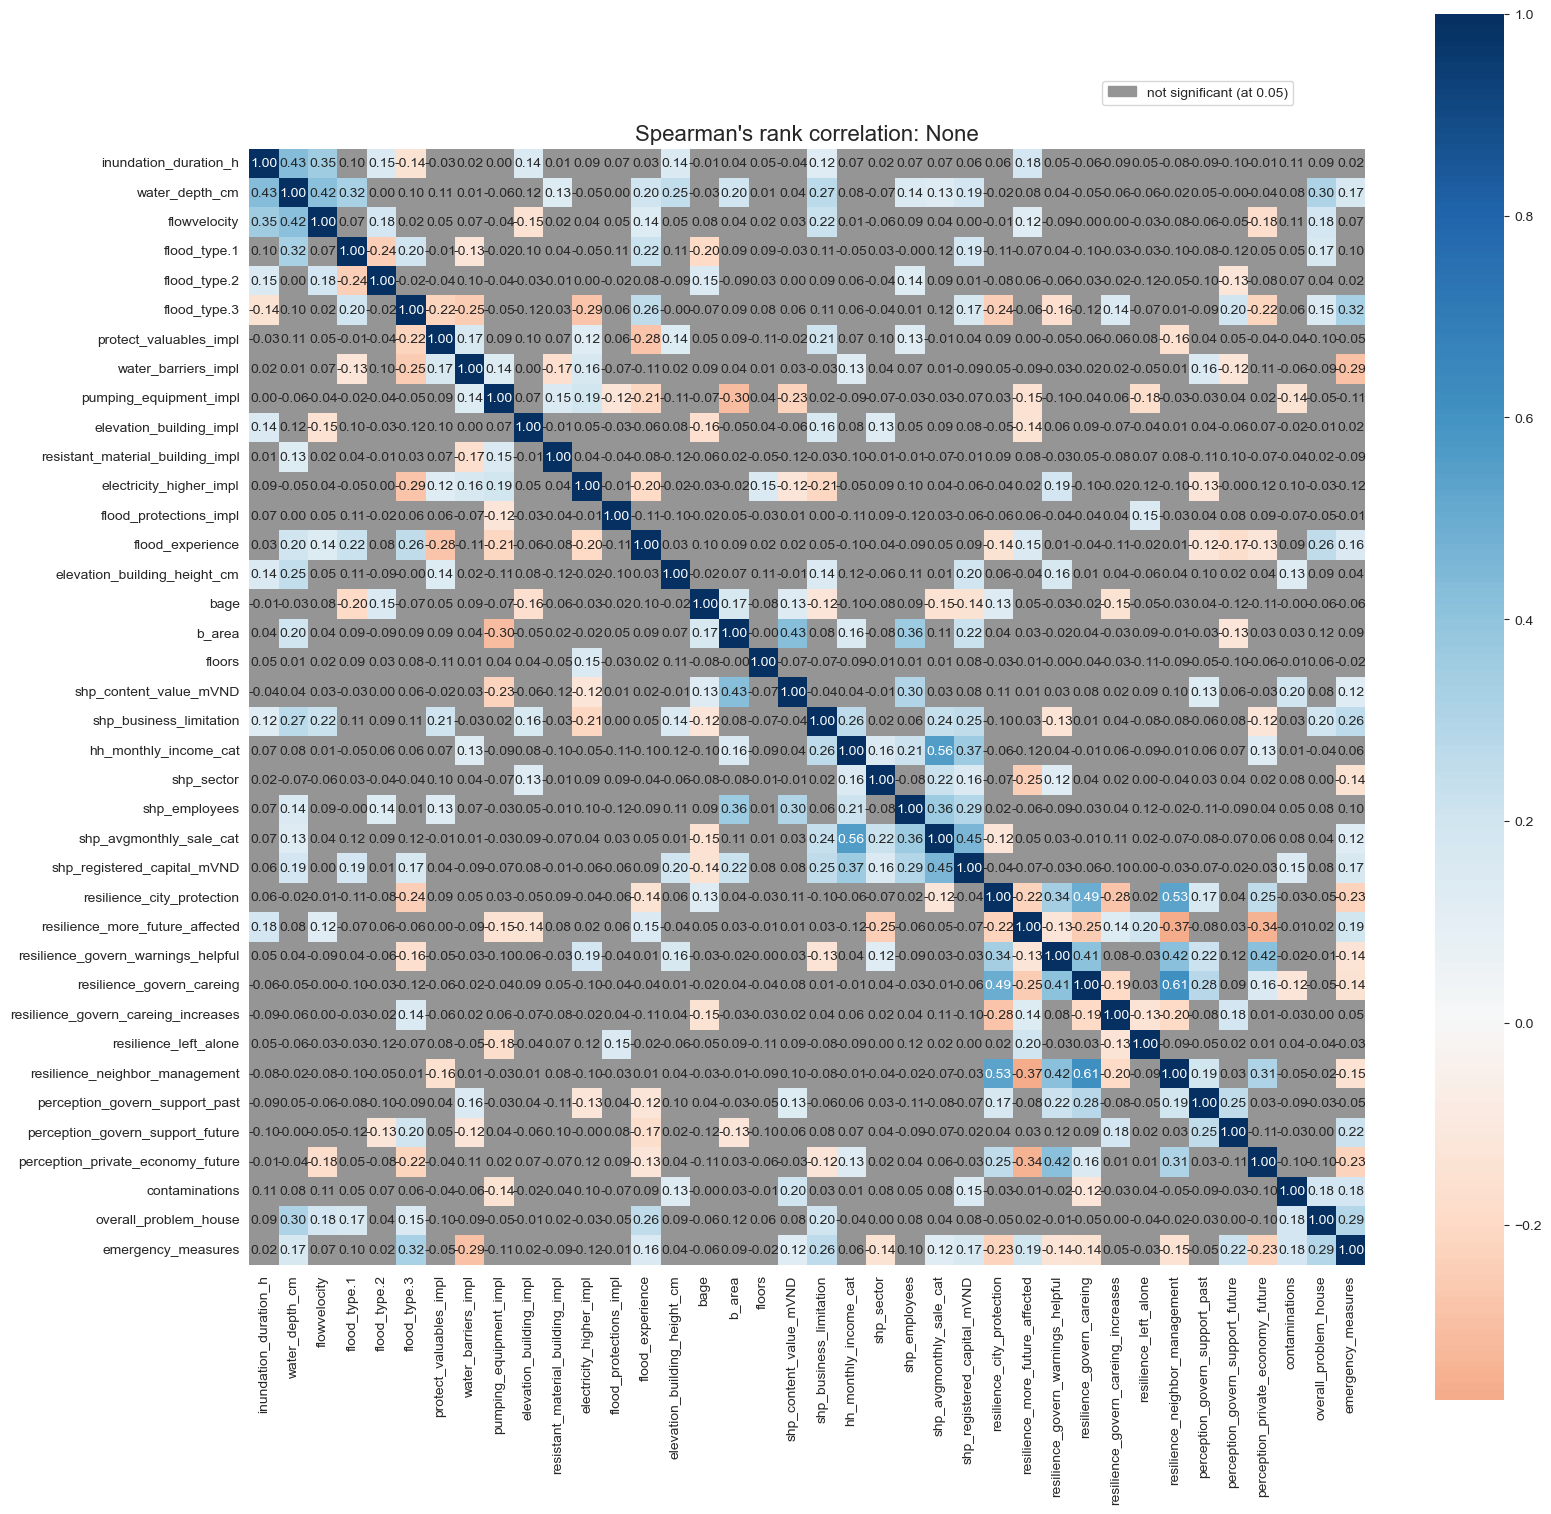

In [78]:
plt.figure(figsize=(18,18))
f.plot_spearman_rank(X_scaled_drop_nan, min_periods=50, signif=True, psig=0.05)
X_scaled_drop_nan.shape

Correlations between the candidate predictors could be removed remarkably, espcially the strongest correlations were removed.
Still features describing shop characteristics such as number of employees, registered capital etc, show a higher multicollinearity in this subgroup. Similar subgroups with higher collinearites are the feautres for resilience and perception 

In [79]:
## drop itendtified variables
all_input = all_input.drop(
    [
     "shp_profits_last5years", "shp_monetary_resources4prevention",# information can be captured in e.g. precuationary measures, e.g. increased profits --> purchased more precautionry meausres
      "emergency_measures.5", # saving elderly and kids -> not important for commercial sector
      "emergency_measures.6", # pumping eq captured in Precautionary measures, 
      "emergency_measures.9", # action/no action
      #"elevation_building_height_cm",  # keep it due its small multicollinearity, still its information is included in elevation_impl 
      "elevation_building_height_cm", "elevation_rel2surrounding_cat",  # remove due that its information is covered in other elevation features
    ], axis=1
)
all_input.shape

(397, 57)

### PCA on subset of features

*Find out if perception and resilience features could be merged into indicators* 
Maybe the loadings from the PCA can give some ideas how these features could be merged \\
Due on variables which are continuous or ordinal scaled


In [80]:
## define set for target and explanatory variables
# df_perception_resilience = all_input[list(all_input.filter(regex=f"^resilience*|^percept*"))]  # only explanatory vars
df_perception_resilience = all_input[list(all_input.filter(regex=f"_impl|"))]  # only explanatory vars
# df_perception_resilience.columns

# df_perception_resilience.resilience_govern_careing_increases = df_perception_resilience.resilience_govern_careing_increases.replace(
#     {1:5, 2:4, 3:3, 4:2, 5:1}
# )

df_perception_resilience = df_perception_resilience.dropna()
df_perception_resilience_X = df_perception_resilience # .drop("Target_contentloss_mVND", axis=1)^b
# df_perception_resilience_Y = df_perception_resilience["Target_contentloss_mVND"]

In [81]:
df_perception_resilience_X.describe()

Target_contentloss_mVND  Target_businessreduction   
count                  88.0000                   88.0000  \
mean                   11.7716                   17.9773   
std                    74.9256                   24.0531   
min                     0.0000                    0.0000   
25%                     0.0000                    0.0000   
50%                     0.0000                    8.5000   
75%                     2.0000                   30.0000   
max                   700.0000                  100.0000   

       inundation_duration_h  water_depth_cm  contaminations.0   
count                88.0000         88.0000           88.0000  \
mean                  3.3125         24.1591            0.1250   
std                   3.6776         21.8863            0.3326   
min                   0.5000          1.0000            0.0000   
25%                   2.0000         10.0000            0.0000   
50%                   3.0000         20.0000            0.0000   
75%                   3.0000         32.2500            0.0000   
max                  30.0000        100.0000            1.0000   

       contaminations.1  contaminations.2  contaminations.3  contaminations.4   
count           88.0000           88.0000           88.0000           88.0000  \
mean             0.8750            0.0909            0.0568            0.5455   
std              0.3326            0.2891            0.2328            0.5008   
min              0.0000            0.0000            0.0000            0.0000   
25%              1.0000            0.0000            0.0000            0.0000   
50%              1.0000            0.0000            0.0000            1.0000   
75%              1.0000            0.0000            0.0000            1.0000   
max              1.0000            1.0000            1.0000            1.0000   

       flowvelocity  flood_type.1  flood_type.2  flood_type.3   
count       88.0000       88.0000       88.0000       88.0000  \
mean         2.7614        0.6932        0.6705        0.1023   
std          1.2034        0.4638        0.4727        0.3047   
min          1.0000        0.0000        0.0000        0.0000   
25%          2.0000        0.0000        0.0000        0.0000   
50%          3.0000        1.0000        1.0000        0.0000   
75%          4.0000        1.0000        1.0000        0.0000   
max          5.0000        1.0000        1.0000        1.0000   

       emergency_measures.1  emergency_measures.2  emergency_measures.3   
count               88.0000               88.0000               88.0000  \
mean                 0.5227                0.4545                0.6364   
std                  0.5023                0.5008                0.4838   
min                  0.0000                0.0000                0.0000   
25%                  0.0000                0.0000                0.0000   
50%                  1.0000                0.0000                1.0000   
75%                  1.0000                1.0000                1.0000   
max                  1.0000                1.0000                1.0000   

       emergency_measures.4  emergency_measures.7  emergency_measures.8   
count               88.0000               88.0000               88.0000  \
mean                 0.5455                0.4091                0.0455   
std                  0.5008                0.4945                0.2095   
min                  0.0000                0.0000                0.0000   
25%                  0.0000                0.0000                0.0000   
50%                  1.0000                0.0000                0.0000   
75%                  1.0000                1.0000                0.0000   
max                  1.0000                1.0000                1.0000   

       overall_problem_house.2  overall_problem_house.3   
count                  88.0000                  88.0000  \
mean                    0.8295                   0.5682   
std                     0.

In [82]:
pattern = [r"^resilience"] 
# pattern = [r"_impl$"] 
pattern_cols = re.compile("|".join(pattern))
df_precautionary = all_input.filter(regex=pattern_cols, axis=1)

df_perception_resilience_X = df_precautionary
df_perception_resilience_X.tail(2)

# fill NA  or drop it for PCA
# df_perception_resilience_X = df_perception_resilience_X.apply(lambda x: x.fillna(x.median()),axis=0)
df_perception_resilience_X = df_perception_resilience_X.dropna()
df_perception_resilience_X.shape

(318, 7)

In [83]:
## normalize data 
X = MinMaxScaler().fit_transform(df_perception_resilience_X)
X = pd.DataFrame(X, columns=df_perception_resilience_X.columns)
print(X.shape, X.columns)

(318, 7) Index(['resilience_city_protection', 'resilience_more_future_affected',
       'resilience_govern_warnings_helpful', 'resilience_govern_careing',
       'resilience_govern_careing_increases', 'resilience_left_alone',
       'resilience_neighbor_management'],
      dtype='object')


In [84]:
##Start by using only 2 principal components, then explore 3 principal components and 4 principal components.

# pca = PCA(n_components=2)
pca = PCA(n_components=3)
# pca = PCA(n_components=4)

PC = pca.fit_transform(X)
# principalDF = pd.DataFrame(data=PC, columns=["pc1","pc2"])
principalDF = pd.DataFrame(data=PC, columns=["pc1","pc2", "pc3"])
# principalDF = pd.DataFrame(data=PC, columns=["pc1","pc2", "pc3", "pc4"])
df_pca = principalDF
# df_pca = pd.concat([principalDF, df_perception_resilience_Y], axis = 1)
# df_pca.head(10)
#X.columns.tolist()
#components #=components[9:21]


#### explained variance
explained variance tells us how much information (variance) can be attributed to each of the principal components

In [85]:
pca.explained_variance_ratio_


array([0.43611556, 0.15495708, 0.1403501 ])

In [86]:
# eigenvalues, eigenvectors = np.linalg.eig(np.corrcoef(X.T))

# tot = sum(eigenvalues)
# var_exp = [(i / tot)*100 for i in sorted(eigenvalues, reverse=True)]
# cum_var_exp = np.cumsum(var_exp)
# cum_var_exp  --> eigenvaules and cum. proportions are later examined 

### Loadings with varimax rotation

In [87]:
# loadings without rotation
PC_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
components = df_perception_resilience_X.columns.tolist()  # use X before standarized

# loadingdf = pd.DataFrame(PC_loadings, columns=("PC1","PC2"))
loadingdf = pd.DataFrame(PC_loadings, columns=("PC1","PC2", "PC3"))
# loadingdf = pd.DataFrame(PC_loadings, columns=("PC1","PC2", "PC3", "PC4"))
loadingdf["variable"] = components
loadingdf


PC1     PC2     PC3                             variable
0  0.2907 -0.0361 -0.0818           resilience_city_protection
1 -0.1530 -0.2436 -0.1484      resilience_more_future_affected
2  0.1758 -0.1591  0.1098   resilience_govern_warnings_helpful
3  0.2418 -0.0467  0.0110            resilience_govern_careing
4 -0.1385 -0.1018  0.2124  resilience_govern_careing_increases
5 -0.0013 -0.0157 -0.0478                resilience_left_alone
6  0.2481 -0.0066  0.0342       resilience_neighbor_management

**Varimax rotation for better interpretation of variables**
By the rotation or adjustment the variance shared among the variables should be maximized

Code snippets were modified based on: https://scikit-learn.org/stable/auto_examples/decomposition/plot_varimax_fa.html (and https://www.kaggle.com/code/gianinamariapetrascu/pca-varimax-rotation#var)

In [88]:
# fit factor analyzer with principal components and varimax rotation
n_factors = 3
fa = FactorAnalyzer(rotation="varimax", n_factors=n_factors, method="principal")
fa.fit(X)

# get the rotated factor pattern
loadings2 = pd.DataFrame(
    fa.loadings_, 
    index=df_perception_resilience_X.columns,
    columns=[f"Factor{i+1}" for i in range(n_factors)]
)
rotated_factor_pattern = loadings2[abs(loadings2) >= 0.2].dropna(how="all")  # drop loadings with less explanatory power
# # rotated_factor_pattern = loadings2[abs(loadings2) >= 0.4].dropna(how="all")  # drop loadings with less explanatory power

rotated_factor_pattern.reset_index()
#loadings2


index  Factor1  Factor2  Factor3
0           resilience_city_protection   0.7050  -0.3800      NaN
1      resilience_more_future_affected      NaN   0.4696   0.5957
2   resilience_govern_warnings_helpful   0.8102   0.3021      NaN
3            resilience_govern_careing   0.7736  -0.2294      NaN
4  resilience_govern_careing_increases      NaN   0.8307      NaN
5                resilience_left_alone      NaN  -0.2358   0.8444
6       resilience_neighbor_management   0.7647  -0.2807  -0.2073

In [89]:
pp.percentage_of_nan(df_precautionary)# resilience_govern_warnings_helpful

01-15-2025 04:49:40 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 resilience_govern_careing_increases   14.0000
resilience_govern_careing              6.0000
resilience_govern_warnings_helpful     5.0000
resilience_city_protection             4.0000
resilience_more_future_affected        4.0000
resilience_neighbor_management         3.0000
resilience_left_alone                  0.0000
dtype: float64


In [90]:
loadings2

Factor1  Factor2  Factor3
resilience_city_protection            0.7050  -0.3800   0.0242
resilience_more_future_affected      -0.1932   0.4696   0.5957
resilience_govern_warnings_helpful    0.8102   0.3021   0.0334
resilience_govern_careing             0.7736  -0.2294  -0.0568
resilience_govern_careing_increases  -0.1517   0.8307  -0.1104
resilience_left_alone                 0.0176  -0.2358   0.8444
resilience_neighbor_management        0.7647  -0.2807  -0.2073

####  Summarize Varimax rotation
*Interpretation of factors*

By applying varimax rotation it is easier which features can be combined with each other into one indicator.
- One indicator for resilinece could be created by nearly all resilience features except "resilinece_left_alone" and eventually "resilience_govern_warnings_helpful"
- One indicator for "perception" may created with "perception_govern_support_past" and "perception_govern_support_future", but maybe this would be a quite weak variable due that similarities between both variables are weak


TODO interprete eigenvectors of first feautres -> am meiste nausagekraft== highest eigenvector?


PCA produces Linear combination of the features with the highest variance (first PCA component) and so on


### Eigenvectors and eigenvalues
Code snippets were taken from: https://www.kaggle.com/code/gianinamariapetrascu/pca-varimax-rotation#var

In [91]:
## calc Eigenvector and eigenvalues

eigenvalues, eigenvectors = np.linalg.eig(np.corrcoef(X.T))

# sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# convert to dataframes
eigenvalues_df = pd.DataFrame({"Eigenvalue": eigenvalues}, index=df_perception_resilience_X.columns)
eigenvalues_df["Proportion"] = eigenvalues_df["Eigenvalue"] / eigenvalues_df["Eigenvalue"].sum()
eigenvalues_df["Cumulative Proportion"] = eigenvalues_df["Proportion"].cumsum()

display(eigenvalues_df.style.format({"Eigenvalue": "{:.4f}", "Proportion": "{:.4f}", "Cumulative Proportion": "{:.4f}"}))

## Explore correlations before creation of indicators and removal of furhter variables


In [92]:
all_input["emergency_measures.8"].value_counts()
all_input["flood_protections_impl"].value_counts()

# all_input["protect_valuables_impl"].value_counts()

flood_protections_impl
5    388
1      7
4      1
2      1
Name: count, dtype: int64

In [93]:
# DONE check ob shop who did em1 and em4 also impl prec_1  -> rm "protect_valuables_impl"-eher from cheap precaution or from emergency.4 and emerg.1 - wo less PCA or mehr NAN
all_input.describe()#[["emergency_measures.1", "emergency_measures.4", "protect_valuables_impl"]].loc[all_input.protect_valuables_impl <=1,:].describe()

Target_contentloss_mVND  Target_businessreduction   
count                 393.0000                  361.0000  \
mean                   23.2361                   18.4654   
std                   306.2933                   25.2277   
min                     0.0000                    0.0000   
25%                     0.0000                    0.0000   
50%                     0.0000                   10.0000   
75%                     2.0000                   30.0000   
max                  6000.0000                  100.0000   

       inundation_duration_h  water_depth_cm  contaminations.0   
count               388.0000        396.0000          397.0000  \
mean                 13.3124         34.3359            0.0907   
std                  42.1480         25.9181            0.2875   
min                   0.2000          1.0000            0.0000   
25%                   2.0000         15.0000            0.0000   
50%                   3.0000         30.0000            0.0000   
75%                   7.0000         50.0000            0.0000   
max                 600.0000        150.0000            1.0000   

       contaminations.1  contaminations.2  contaminations.3  contaminations.4   
count          397.0000          397.0000          397.0000          397.0000  \
mean             0.8917            0.0680            0.0252            0.5642   
std              0.3112            0.2521            0.1569            0.4965   
min              0.0000            0.0000            0.0000            0.0000   
25%              1.0000            0.0000            0.0000            0.0000   
50%              1.0000            0.0000            0.0000            1.0000   
75%              1.0000            0.0000            0.0000            1.0000   
max              1.0000            1.0000            1.0000            1.0000   

       flowvelocity  flood_type.1  flood_type.2  flood_type.3   
count      397.0000      397.0000      397.0000      397.0000  \
mean         3.0277        0.7783        0.7280        0.0957   
std          1.2700        0.4159        0.4456        0.2946   
min          1.0000        0.0000        0.0000        0.0000   
25%          2.0000        1.0000        0.0000        0.0000   
50%          3.0000        1.0000        1.0000        0.0000   
75%          4.0000        1.0000        1.0000        0.0000   
max          5.0000        1.0000        1.0000        1.0000   

       emergency_measures.1  emergency_measures.2  emergency_measures.3   
count              397.0000              397.0000              397.0000  \
mean                 0.4131                0.4081                0.6801   
std                  0.4930                0.4921                0.4670   
min                  0.0000                0.0000                0.0000   
25%                  0.0000                0.0000                0.0000   
50%                  0.0000                0.0000                1.0000   
75%                  1.0000                1.0000                1.0000   
max                  1.0000                1.0000                1.0000   

       emergency_measures.4  emergency_measures.7  emergency_measures.8   
count              397.0000              397.0000              397.0000  \
mean                 0.5164                0.3678                0.0403   
std                  0.5004                0.4828                0.1969   
min                  0.0000                0.0000                0.0000   
25%                  0.0000                0.0000                0.0000   
50%                  1.0000                0.0000                0.0000   
75%                  1.0000                1.0000                0.0000   
max                  1.0000                1.0000                1.0000   

       overall_problem_house.2  overall_problem_house.3   
count                 397.0000                 397.0000  \
mean                    0.8438                   0.7280   
std                     0.

In [94]:
# # plt.boxplot(all_input.)
# # print(all_input.precautionary_measures_lowcost[all_input_p.shp_sector == 1.].describe() )

# all_input.boxplot(column="precautionary_measures_lowcost", by=["shp_sector"])
# # all_input.boxplot(column="shp_avgmonthly_sale_mVND", by=["shp_sector"])
# print(all_input.shp_sector.value_counts())

# ## higher sale rates in shops with Electricity equipment, in porduction sites: metal products have higher sales (but sample sizes are for all bus.types  too small)

**What are the most common business tyopes  across the sectors?**

In [95]:
all_input["shp_sector"].value_counts()  # 1x shops, 2x: services, 3x: manufactoring

## shops
# food/beverage [152], other type of shops [116]

## services
## hair salon [25], repairing [21]

## manufactoring
## gamrnets [10], paper printing [9]

shp_sector
11.0000    152
17.0000    116
22.0000     25
24.0000     21
88.0000     17
21.0000     13
31.0000     10
33.0000      9
14.0000      8
23.0000      6
12.0000      4
15.0000      4
35.0000      4
13.0000      3
32.0000      2
16.0000      2
34.0000      1
Name: count, dtype: int64

**How owns buildings with larger floor areas - are these manufacturing firms?**

In [96]:
# all_input.loc[all_input["b_area"] > 0, : ]["shp_sector"].value_counts()
all_input.loc[all_input["b_area"] > 100, : ]["shp_sector"].value_counts()

## -> no, many busiensses in buildigns with larger floor areas are shops/retailers, only 5 from 26 manufcaturing firms are in larger buidligns (>100sqm)

shp_sector
11.0000    42
17.0000    22
24.0000     7
21.0000     6
88.0000     5
31.0000     3
23.0000     3
15.0000     2
33.0000     2
13.0000     1
22.0000     1
Name: count, dtype: int64

## Indicators and transform categorical variables
Based on the above findings from VIF and spearman correlation plot certain features from the original feature space will be merged into indicators:

The later applied Bayesian Network uses continous variables, therfore categorical variables are transformed to continous scales if possible.
Ordered categories can be easily transformed when they are in quantitative values, while binary or qualitative variables can not be used in the Bayesian Network


#### Variables to modify:

binary vars: --> remove or modify
- contaminaitions : modify to indicator



In [97]:
all_input.shape

(397, 57)

##### Transform categorical (quantitative) vairables

In [98]:
## flow velocity: categories 1:calm - 5:torrential
## Paprotny 2021:  As for flow velocity, the respondents assessed is based on a qualitative scale, 
# providing a value from 1 to 6, with half-points possible (Thieken et al. 2005). 
# A value of 0.1 m/s was assigned to each full step of this qualitative scale. 


all_input.flowvelocity.describe()

all_input.flowvelocity = all_input.flowvelocity.replace(
    {
        1:0.1, 
        2:0.2, 
        3:0.3, 
        4:0.4, 
        5:0.5
    }
)


In [99]:
## flood experience: mean of ranges
all_input.flood_experience.describe()

all_input.flood_experience = all_input.flood_experience.replace(
    {
      1:3,     # less than once a year , freq: 1
      2:8,     # about once a year, freq: 14
      3:16,      # twice a year, freq: 37
      4:36,      # 4 times a year, freq: 58
      5:76,      # 8 times a year, freq: 98
      6:151     # 15 times a year - used range 100-200, freq: 112 (more than 10 times a year, 100 times since 2010)
    }
)
all_input.flood_experience.value_counts()

flood_experience
151    133
76     109
36      88
16      42
8       18
3        7
Name: count, dtype: int64

In [100]:
## avg monthly sale (million VND/month)
all_input.shp_avgmonthly_sale_cat.value_counts()

all_input["shp_avgmonthly_sale_mVND"] = None
all_input["shp_avgmonthly_sale_mVND"] = all_input.shp_avgmonthly_sale_cat.replace(
    {
      1:2.5,     # < 5m , freq: 126
      2:7.5,     # 5m – 10m , freq: 129
      3:20,      # 10m – 30m , freq: 54
      4:40,      # 30m – 50m , freq: 7
      5:75,      # 50m – 100m , freq: 8
    }
)

In [101]:
## avg monthly income
#print(all_input.hh_monthly_income_cat.value_counts())

all_input["hh_monthly_income_mVND"] = None
all_input.hh_monthly_income_mVND = all_input.hh_monthly_income_cat.replace(
    {
      1:0.5,     # < 1m , freq: 4
      2:3,     # 1m – 5m , freq: 68
      3:8,     # 5m – 10m , freq: 153
      4:15,    # 10m – 20m , freq: 111
      5:25,    # 20m – 30m , freq: 26
      6:40,    # 30m – 50m , freq: 4
      7:65,    # 50m – 80m , freq: 4
      8:90,    # 80m – 100m , freq: 3
    }
)

all_input.drop(["hh_monthly_income_cat", "shp_avgmonthly_sale_cat"], axis=1, inplace=True)

**Test if business secotrs are important predictive variablesduring feature extraction**
--> No, they have minor or moderate importance for degree of loss and bred

In [102]:
## combine business sectors into two or three main casses to see if they are importnat for rloss quantification
all_input.shp_sector.value_counts()

all_input["shp_sector"] = all_input["shp_sector"].replace(
    {
        11.0 : 1,     # 1. Shop/Retailer
        12.0 : 1, 
        13.0 : 1, 
        14.0 : 1, 
        15.0 : 1, 
        16.0 : 1, 
        17.0 : 1, 
        11.0 : 1, 
        11.0 : 1, 
        11.0 : 1, 
        21.0 : 2,     # 2. Services 
        22.0 : 2, 
        23.0 : 2, 
        24.0 : 2,
        31.0 : 3,     # 3. Production
        32.0 : 3, 
        33.0 : 3, 
        34.0 : 3, 
        35.0 : 3, 
        88.0 : np.nan,
    }
)
all_input.shp_sector.value_counts()

shp_sector
1.0000    289
2.0000     65
3.0000     26
Name: count, dtype: int64

#### Indicators
indictator for severla multiple choice answers e..g emergency and precautionary measures

as a ratio between b measures implemented prior to the flood (nI) divided by the nb measures potentailly could have implemented (nP)
(https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027649)

\
\
Maybe for socio-economic status indicator:

according to Plapp 2003, applied by Thieken et al 2005
indicator of warning information, indicator of emergency measures, perception of efficiency of private precaution, building quality, building/content value

In [103]:
df = all_input
df.columns

df = df.reset_index(drop=True)

In [104]:
## emergency measures as indicator : range: 0:no measures - 6: applied all measures 
# em.1 = save documents
# em.2 = move vehicles
# em.3 = move furnuture
# em.4 = relocate products (dry-proofing)
# em.7 = sand bags or other temporary+small scale protection
# em.8 = sealing doors or windows

pattern = [r"emergency_measures.?"] 
pattern_cols = re.compile("|".join(pattern))
df_emergency = df.filter(regex=pattern_cols, axis=1)

## create indicator as ratio between implemented and potentially implemented emergency measures
df["emergency_measures"] = None
df["emergency_measures"] = df_emergency.eq(1).sum(axis=1) / len(df_emergency.columns)

# keep only indicator in final df
df.drop(
    df_emergency.filter(
        regex=r"^(?:.+\d)$"
        ).columns, 
    axis=1, inplace=True
)

In [105]:
df_emergency.columns

Index(['emergency_measures.1', 'emergency_measures.2', 'emergency_measures.3',
       'emergency_measures.4', 'emergency_measures.7', 'emergency_measures.8'],
      dtype='object')

In [106]:
# ## precautionary measures as indicator
# ## --> test first as seperate feautres to keep as much information as possible

pattern = [r"_impl$"] 
pattern_cols = re.compile("|".join(pattern))
df_precautionary = df.filter(regex=pattern_cols, axis=1)

## prec 1 : dry-proofing valuables (elelctronics, products)
## prec 2 : acquire water barriers
## prec 3 : pumping eq.
## prec 4 : builidng elelvation
## prec 5 : water-resistant builidng material
## prec 6 : electrity control system at higher level
## prec 7 : install flood protection (sealed basement, doors..)



df_precautionary = df_precautionary.replace(
    {
        1:1,    # impl before 
        2:0,    # impl after event (but before recent )
        4:0,    # impl after 
        5:0     # not at all  
    }
)
# ## devide into expensive and low cost precautionary measures due that expensive meausres seems to be better in flood-loss-reduction
## df_precautionary_expensive: comprises all meausres for which the building has to be fundamentally changes (eg. during major renovation) 
df_precautionary_expensive = df_precautionary[["elevation_building_impl", "resistant_material_building_impl"]]#, "flood_protections_impl"]]
df_precautionary_low = df_precautionary[["protect_valuables_impl", "water_barriers_impl", "electricity_higher_impl", "pumping_equipment_impl"]]
# NOTE "protect_valuables_impl" use dry-proofing (need acquisition before flood) vs emegency measure: save valuables shortly before flood
# NOTE "flood_protections_impl" - drop due that partly incoporated in emergency meausres (EM: 8)
# add water_barriers_impl + electrity_higher_impl to cheap meausres (due that building has not be fundamentally be changed)
# NOTE prec. waterbariers (permanently installed)  ~ em: temporay like sand bags (not permantently installed)

# create indicator as ratio between implemented and potentially implemented measures (in total 7 measures exist)
# range: 0.0: no measure wa implemented before the flood event - 1.0: all potential measures were implemented before the reported flood
# --> splitting in low and expensive precaution measures reduces the importance of the feautres for the models remarkable
df["precautionary_measures_lowcost"] = None
df["precautionary_measures_lowcost"] = df_precautionary_low.sum(axis=1) / len(df_precautionary_low.columns)
df["precautionary_measures_expensive"] = None
df["precautionary_measures_expensive"] = df_precautionary_expensive.sum(axis=1) / len(df_precautionary_expensive.columns)


## keep only indicator in final df
df.drop(
    df_precautionary.columns, 
    axis=1, inplace=True
)
print(df.columns)


Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'flood_type.1', 'flood_type.2',
       'flood_type.3', 'overall_problem_house.2', 'overall_problem_house.3',
       'overall_problem_house.4', 'overall_problem_house.5',
       'overall_problem_house.6', 'overall_problem_house.7',
       'overall_problem_house.8', 'overall_problem_house.9',
       'flood_experience', 'bage', 'b_area', 'geometry', 'floors',
       'shp_content_value_mVND', 'shp_business_limitation', 'shp_sector',
       'shp_employees', 'shp_registered_capital_mVND',
       'resilience_city_protection', 'resilience_more_future_affected',
       'resilience_govern_warnings_helpful', 'resilience_govern_careing',
       'resilience_govern_careing_increases', 'resilience_left_alone',
       'resilience_neighbor_management', 'perception_

In [107]:
## resilience as indicator:

## 1 : strong disagree - 5 : strong agree
## currently would leave at it is and see if its included in final Feature space
## TEST: as merged indcator and as seperate features
## o	Orderer rank okay as long its  quantitative

## select based on findings from PCA
df_resilience = df[["resilience_city_protection", "resilience_govern_careing","resilience_neighbor_management", "resilience_govern_warnings_helpful"]]
print(df_resilience.columns)

df["resilience"] = None
df["resilience"] = df_resilience.sum(axis=1) / len(df_resilience.columns)


## keep only indicator in final df
df.drop(
    df.filter(like="resilience_").columns,
    axis=1, inplace=True
)
print(df.columns)
# ## 1: disagree, 5: agree


Index(['resilience_city_protection', 'resilience_govern_careing',
       'resilience_neighbor_management', 'resilience_govern_warnings_helpful'],
      dtype='object')
Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'flood_type.1', 'flood_type.2',
       'flood_type.3', 'overall_problem_house.2', 'overall_problem_house.3',
       'overall_problem_house.4', 'overall_problem_house.5',
       'overall_problem_house.6', 'overall_problem_house.7',
       'overall_problem_house.8', 'overall_problem_house.9',
       'flood_experience', 'bage', 'b_area', 'geometry', 'floors',
       'shp_content_value_mVND', 'shp_business_limitation', 'shp_sector',
       'shp_employees', 'shp_registered_capital_mVND',
       'perception_govern_support_past', 'perception_govern_support_future',
       'perception_privat

In [108]:
df[["Target_contentloss_mVND", "Target_businessreduction", "resilience"]].corr(method="spearman")


Target_contentloss_mVND  Target_businessreduction   
Target_contentloss_mVND                    1.0000                    0.5556  \
Target_businessreduction                   0.5556                    1.0000   
resilience                                 0.1261                    0.0586   

                          resilience  
Target_contentloss_mVND       0.1261  
Target_businessreduction      0.0586  
resilience                    1.0000

In [109]:
## drop perception variables
df.drop(
    df.filter(like="perception_").columns, 
    axis=1, inplace=True
)


In [110]:
## contaminations
## rank contamination according to their occurence and damage potential: 0:no contamination, 1:light contamination and 2:heavy contamination

df["contaminations"] = None
df_contaminations = df.filter(like="contaminations", axis=1)


## light contamination
df.contaminations = np.where( 
    (df_contaminations["contaminations.1"]==1) | 
    (df_contaminations["contaminations.4"]==1) ,
    1, 0
) 
## heavy contamination
idx_heavy_contamination = np.where(
    (df_contaminations["contaminations.2"]==1) |
    (df_contaminations["contaminations.3"]==1)
)
df.contaminations[idx_heavy_contamination[0].tolist()] = 2


## keep only indicator in final df
df.drop(
    df_contaminations.filter(like="contaminations.").columns, 
    axis=1, inplace=True
)
#print(df.columns)

In [111]:
## overall_problem_house

# 0 if no damage occured, (# 1 if building was damaged )
# 2.	moisture penetration of walls and ceilings              freq: 207
# 3.	mold and contamination;                                 freq: 175
# 4.	small cracks in walls, doors, windows                   freq: 86
# 5.	larger cracks in walls, doors, windows                  freq: 31
# 6.	subsidence of the building                              freq: 76
# 7.	replacement of building components necessary            freq: 19
# 8.	collapse of load-bearing walls, replacement necessary   freq: 6
# 9.	collapse of large building parts, demolition necessary  freq: 3

# --> test overall_problem_house as multiclass 
df["overall_problem_house"] = None

pattern = [r"overall_problem_house.*(?<!1)$"] # get all columns but not overall_problem_house_r.1: no problem/ problem 
pattern_cols = re.compile("|".join(pattern))
df_problem_house = df.filter(regex=pattern_cols, axis=1)

## create indicator
df.overall_problem_house = np.where( (df_problem_house["overall_problem_house.2"]==1), 1, 0) 

idx = np.where(df_problem_house["overall_problem_house.3"]==1)
df.overall_problem_house[idx[0].tolist()] = 2

idx = np.where(df_problem_house["overall_problem_house.4"]==1)
df.overall_problem_house[idx[0].tolist()] = 3

idx = np.where(df_problem_house["overall_problem_house.5"]==1)
df.overall_problem_house[idx[0].tolist()] = 4

idx = np.where(df_problem_house["overall_problem_house.6"]==1)
df.overall_problem_house[idx[0].tolist()] = 5

idx = np.where(
    (df_problem_house["overall_problem_house.7"]==1) | 
    (df_problem_house["overall_problem_house.8"]==1) |
    (df_problem_house["overall_problem_house.9"]==1)
)
df.overall_problem_house[idx[0].tolist()] = 6



## keep only indicator in final df
df.drop(
    df_problem_house.filter(like="overall_problem_house.").columns, 
    axis=1, inplace=True
)
print(df.columns)


Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_type.1', 'flood_type.2', 'flood_type.3', 'flood_experience',
       'bage', 'b_area', 'geometry', 'floors', 'shp_content_value_mVND',
       'shp_business_limitation', 'shp_sector', 'shp_employees',
       'shp_registered_capital_mVND', 'geometry', 'shp_avgmonthly_sale_mVND',
       'hh_monthly_income_mVND', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'resilience', 'contaminations', 'overall_problem_house'],
      dtype='object')


In [112]:
df[["precautionary_measures_lowcost", "precautionary_measures_expensive"]].describe()

precautionary_measures_lowcost  precautionary_measures_expensive
count                        397.0000                          397.0000
mean                           0.3621                            0.2217
std                            0.2909                            0.2706
min                            0.0000                            0.0000
25%                            0.2500                            0.0000
50%                            0.2500                            0.0000
75%                            0.5000                            0.5000
max                            1.0000                            1.0000

In [113]:
print(df.columns)
all_input = df

Index(['Target_contentloss_mVND', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_type.1', 'flood_type.2', 'flood_type.3', 'flood_experience',
       'bage', 'b_area', 'geometry', 'floors', 'shp_content_value_mVND',
       'shp_business_limitation', 'shp_sector', 'shp_employees',
       'shp_registered_capital_mVND', 'geometry', 'shp_avgmonthly_sale_mVND',
       'hh_monthly_income_mVND', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'resilience', 'contaminations', 'overall_problem_house'],
      dtype='object')


<Axes: title={'center': 'precautionary_measures_lowcost'}, xlabel='shp_sector'>

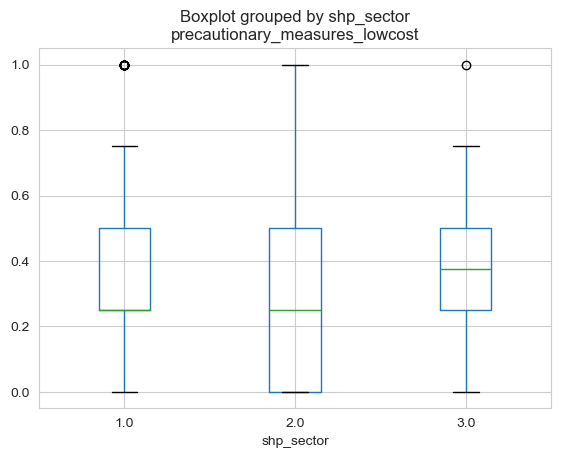

In [114]:
all_input.boxplot(column="precautionary_measures_lowcost", by="shp_sector")

In [115]:
# TODO boxplot cheap prec grouped by seco

In [116]:
all_input["shp_sector"].value_counts()  # 1x shops, 2x: services, 3x: manufactoring


shp_sector
1.0000    289
2.0000     65
3.0000     26
Name: count, dtype: int64

#### variance of features after Feature Reduction
Remove features with zero or near zero variance or merge them into indicators

##### Drop of further variables whose information is captured in other variables

In [117]:

# ## keep only indicator in final df
# all_input.drop(
#     ["overall_problem_house", "shp_registered_capital_mVND"],
#     axis=1, inplace=True
# )


In [118]:
X_scaled = MinMaxScaler().fit_transform(
    all_input.drop(
        ["Target_contentloss_mVND", "Target_businessreduction", "geometry"], 
        axis=1
    )
)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=all_input.drop(["Target_contentloss_mVND", "Target_businessreduction", "geometry"], axis=1).columns
)


df_variance = X_scaled.var()
df_variance = np.round(df_variance, 5)
#print(pd.DataFrame({"variance":df_variance}).sort_values("variance").head(25))

var = []
for i in range(0, len(df_variance)):
    if df_variance[i] != 0.00000:
            var.append(X_scaled.columns[i])
print(var)
#df_variance = pd.DataFrame({"variance":df_variance}).sort_values("variance")

['inundation_duration_h', 'water_depth_cm', 'flowvelocity', 'flood_type.1', 'flood_type.2', 'flood_type.3', 'flood_experience', 'bage', 'b_area', 'floors', 'shp_content_value_mVND', 'shp_business_limitation', 'shp_sector', 'shp_employees', 'shp_registered_capital_mVND', 'shp_avgmonthly_sale_mVND', 'hh_monthly_income_mVND', 'emergency_measures', 'precautionary_measures_lowcost', 'precautionary_measures_expensive', 'resilience', 'contaminations', 'overall_problem_house']


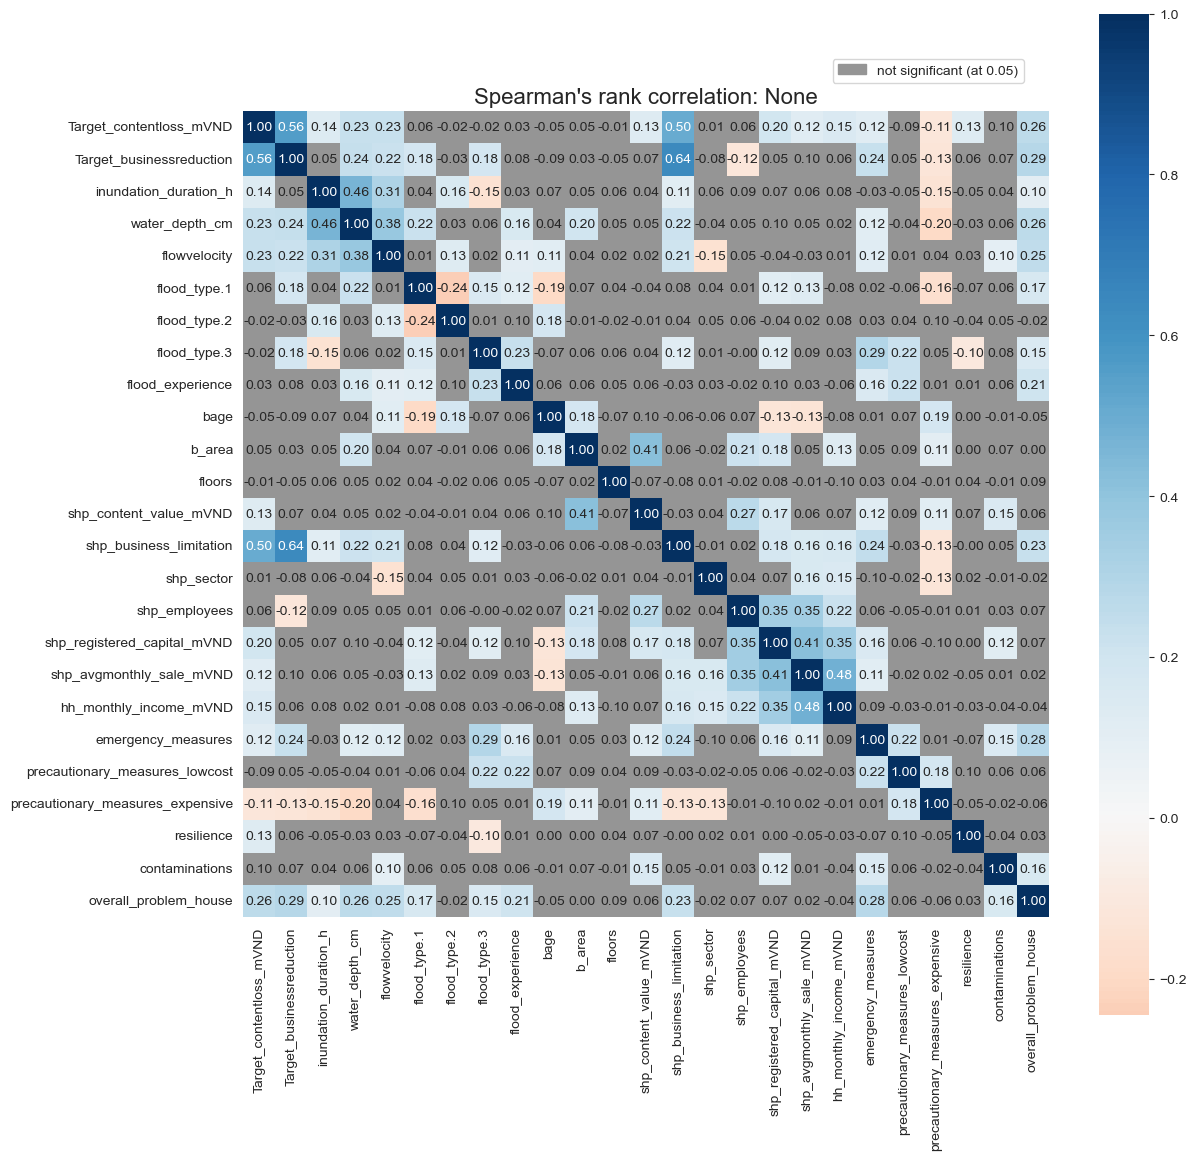

In [119]:
plt.figure(figsize=(13,13))
f.plot_spearman_rank(all_input.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)

In [120]:
all_input.hh_monthly_income_mVND.value_counts()

hh_monthly_income_mVND
8.0000     153
15.0000    111
3.0000      68
25.0000     26
65.0000      4
0.5000       4
40.0000      4
90.0000      3
Name: count, dtype: int64

In [121]:
df_vif = fs.vif_score(all_input.drop("geometry", axis=1).dropna())
print(df_vif.sort_values("vif_scores", ascending=False)  )

01-15-2025 04:51:10 - __feature_selection__ - INFO - averaged VIF score is around: 5.5


                               names  vif_scores
0                             floors     33.8394
1                       flowvelocity     10.4748
2                         resilience      8.9607
3                         shp_sector      8.8125
4                     contaminations      7.1253
5                       flood_type.1      5.4536
6                      shp_employees      5.3325
7              overall_problem_house      5.2527
8                 emergency_measures      5.1315
9                   flood_experience      4.8035
10                      flood_type.2      4.4894
11                    water_depth_cm      4.1666
12                              bage      3.8212
13            hh_monthly_income_mVND      3.4152
14                            b_area      3.4023
15    precautionary_measures_lowcost      3.3324
16          Target_businessreduction      3.0406
17            shp_content_value_mVND      2.5927
18           shp_business_limitation      2.3823
19  precautionary_me

## Unify monetary values

*list of all monetary vars*

- b_value_mVND	- price level for 2020 (year when survey was done)
- shp_building_value_mVND	- price level for 2020
- shp_content_value_mVND	- price level for 2020
- Target_contentloss_mVND	- price levels based on flood time
- shp_registered_capital_mVND  - price level for 2020
- hh_monthly_income_mVND     - continous [value ranges in mVND], # price level for 2020
- shp_avgmonthly_sale_mVND   - continous [value ranges in mVND], # price level for 2020

All other vars are inflation corrected based on flood time or when survey was done 
cpi_2020 = 168.8    ,  2020 = year when the survey was done



In [124]:
## check for very small registered capital
vars_money = all_input.filter(regex="_mVND", axis=1)


## covnert all columns with million VND --> VND

vars_money = np.where( (vars_money.values != np.nan),
            vars_money.values * 1000000, # convert to VND
            vars_money.values)

## rename columns
new_cols = all_input.filter(regex="_mVND", axis=1).columns.str.replace("_mVND", "_VND")
vars_money = pd.DataFrame(vars_money, columns=new_cols)


*Conversion of VND to euro (or US$)*

Based on JRC, p.8 and Paprotny2018, eg.p245
The reported damage values have been converted to Euro using the the exchange rate for the year 2020 (mean annual value)

*Source:* 
- www.oanda.com/currency/historical-rates
-  www.ecb.europa.eu/stats/exchange/eurofxref/html/eurofxref-graph-idr.en.html
- https://jp.tradingeconomics.com/vietnam

In [125]:
gdp_price_index_year_of_issue = {
    2011: 121.26,
    2012: 134.51,
    2013: 140.91,
    2014: 146.07,
    2015: 145.80,
    2016: 147.41,
    2017: 153.44,
    2018: 158.65,
    2019: 161.49,
    2020: 163.58
}
# GDP deflator source : https://jp.tradingeconomics.com/vietnam/gdp-deflator


gdp_price_index_2020 = 163.58 
gdp_price_index_year = data_ip2["flood_year"].astype("Int64").map(gdp_price_index_year_of_issue)  # series of cpi for each year of flood event

exchange_rate = 1 / 27155  # ~ 3.68e-05  dong-> euro in 2020 
## (based on https://www.oanda.com/currency-converter/de/?from=VND&to=EUR&amount=1 )

*Inflation correction via GDP-deflator*


\begin{equation}
\begin{align*}

&uninflated_{2020} = losses_y * exchangerate_{2020} \\
&inflationrate = uninflated_{2020} * pindex_{2020} / pindex_y\\

\end{align*}
\end{equation}

where:
- losses_y : losses in VND for year y
- uninflated_{2020} : uninflated losses in euro for 2020
- exchangerate_{2020} : exchang erate for VND to euro in year 20202 
- pindex_{2020} : price index from GDP-deflator for 2020 
- pindex_y : price index from GDP-deflator in year y

Given that inflation is the percentage change in the overall price of an item in an economy, we can use the GDP deflator to calculate the inflation rate since its a measure of the price level.


*Further sources*
Paprotny 2018: also used country-level GDP deflators for adjusting nomnal to real losses in 2011 prices , p153, p244
Sairam et al. 2020


In [126]:
## GDP-deflator

vars_money["Target_contentloss_VND_gdp"] = None

##  only direct losses needs inflation correction in respect to flood time
for r in range(len(vars_money.Target_contentloss_VND)):
    ## exchange rate: convert VND in certain year to € in the same year
    uninflated_losses = (vars_money.Target_contentloss_VND[r] * exchange_rate) # get uninflated losses in euros for year 2020
    ## price index from GDP-deflator
    vars_money["Target_contentloss_VND_gdp"][r] = round(uninflated_losses * gdp_price_index_2020 / gdp_price_index_year[r], 1)



# ##  for all other monetary continous vars: only need exchange conversion
for c in vars_money.drop(["Target_contentloss_VND_gdp","Target_contentloss_VND"], axis=1).columns:
    vars_money[c] = vars_money[c].apply(pd.to_numeric)
    for r in range(len(vars_money[c])):
        ## convert VND_2020 to €_2020
        vars_money[c][r] = round((vars_money[c][r] * exchange_rate), 1)#.astype(int)


## rename columns
new_cols = vars_money.filter(regex="_VND", axis=1).columns.str.replace("_VND", "_euro")
vars_money.columns = new_cols



In [127]:
vars_money.Target_contentloss_euro_gdp = vars_money.Target_contentloss_euro_gdp.apply(pd.to_numeric)

In [128]:
# update all_input with unified and inflated currencies
all_input.drop(all_input.filter(regex="_mVND", axis=1).columns, axis=1, inplace=True) 
all_input = pd.concat([all_input, vars_money], axis=1)
all_input.drop("Target_contentloss_euro", axis=1, inplace=True)
all_input.rename(columns={"Target_contentloss_euro_gdp" : "Target_contentloss_euro"}, inplace=True)

all_input.filter(regex="euro", axis=1).columns


Index(['shp_content_value_euro', 'shp_registered_capital_euro',
       'shp_avgmonthly_sale_euro', 'hh_monthly_income_euro',
       'Target_contentloss_euro'],
      dtype='object')

Check if inundation duration of 600 hours is a spellign mistake or reasonable

In [129]:
all_input.loc[all_input.inundation_duration_h > 300, :]  ## 600h == ~13 days of inundation

Target_businessreduction  inundation_duration_h  water_depth_cm   
87                   10.0000               600.0000         30.0000  \

    flowvelocity  flood_type.1  flood_type.2  flood_type.3  flood_experience   
87        0.4000             1             1             0               151  \

      bage  b_area                      geometry  floors   
87 19.0000 74.0000  POINT (106.602888 10.724609)       2  \

    shp_business_limitation  shp_sector  shp_employees   
87                   0.0000      1.0000              2  \

                      geometry  emergency_measures   
87  POINT (106.60289 10.72461)              0.3333  \

    precautionary_measures_lowcost  precautionary_measures_expensive   
87                          0.2500                            0.0000  \

    resilience  contaminations  overall_problem_house  shp_content_value_euro   
87      1.2500               1                      5               4603.2000  \

    shp_registered_capital_euro  shp_avgmonthly_sale_euro   
87                    2946.1000                  276.2000  \

    hh_monthly_income_euro  Target_contentloss_euro  
87                552.4000                 265.8000

In [130]:
all_input.Target_contentloss_euro.describe()

count      382.0000
mean       915.5353
std      11658.5576
min          0.0000
25%          0.0000
50%          0.0000
75%         77.8500
max     223813.4000
Name: Target_contentloss_euro, dtype: float64

In [131]:
all_input.Target_businessreduction.describe()

count   361.0000
mean     18.4654
std      25.2277
min       0.0000
25%       0.0000
50%      10.0000
75%      30.0000
max     100.0000
Name: Target_businessreduction, dtype: float64

## Relative Content loss
Content loss dataset: create new Target for relative content loss
Derive relative content loss as a ratio between the absoulte loss and the estimated content value of each business

In [132]:
all_input[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="spearman")


Target_contentloss_euro  shp_content_value_euro
Target_contentloss_euro                   1.0000                  0.1037
shp_content_value_euro                    0.1037                  1.0000

(0.0, 1000.0)

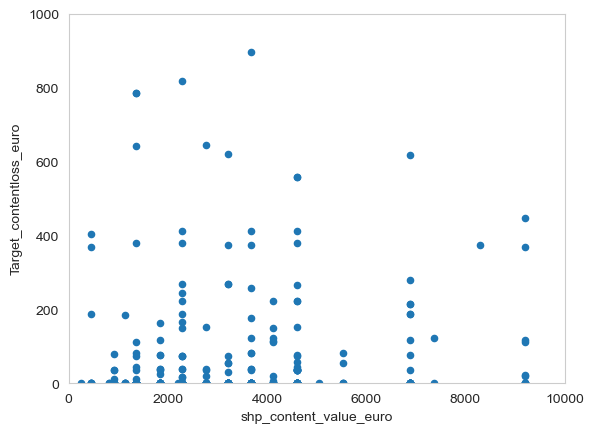

In [133]:
all_input.plot.scatter("shp_content_value_euro", "Target_contentloss_euro")
plt.xlim(0, 10000)
plt.ylim(0, 1000)


In [134]:
all_input.Target_contentloss_euro.describe()

count      382.0000
mean       915.5353
std      11658.5576
min          0.0000
25%          0.0000
50%          0.0000
75%         77.8500
max     223813.4000
Name: Target_contentloss_euro, dtype: float64

In [135]:
all_input[all_input.shp_employees> 9]

Target_businessreduction  inundation_duration_h  water_depth_cm   
97                        NaN               168.0000          8.0000  \
151                  100.0000                70.0000        100.0000   

     flowvelocity  flood_type.1  flood_type.2  flood_type.3  flood_experience   
97         0.2000             1             1             0                36  \
151        0.5000             1             0             0                76   

       bage    b_area                      geometry  floors   
97   0.0000   80.0000  POINT (106.612201 10.723339)       2  \
151 14.0000 1000.0000   POINT (106.63001 10.722066)       2   

     shp_business_limitation  shp_sector  shp_employees   
97                    7.0000      3.0000             10  \
151                 365.0000         NaN             34   

                       geometry  emergency_measures   
97   POINT (106.61220 10.72334)              0.0000  \
151  POINT (106.63001 10.72207)              0.0000   

     precautionary_measures_lowcost  precautionary_measures_expensive   
97                           0.2500                            0.0000  \
151                          0.5000                            0.0000   

     resilience  contaminations  overall_problem_house   
97       2.2500               1                      6  \
151      3.0000               1                      6   

     shp_content_value_euro  shp_registered_capital_euro   
97               13809.6000                    1841.3000  \
151              50635.2000                  699687.0000   

     shp_avgmonthly_sale_euro  hh_monthly_income_euro  Target_contentloss_euro  
97                   736.5000                     NaN                 373.0000  
151                 2761.9000               3314.3000              223813.4000

In [136]:
all_input["Target_contentloss_euro"] = all_input["Target_contentloss_euro"].apply(pd.to_numeric)
# all_input = all_input.loc[ ~(all_input.Target_contentloss_euro > 10000), :]
all_input.Target_contentloss_euro.describe()
# --> 4 cases


count      382.0000
mean       915.5353
std      11658.5576
min          0.0000
25%          0.0000
50%          0.0000
75%         77.8500
max     223813.4000
Name: Target_contentloss_euro, dtype: float64

In [137]:
## calc fraction of content loss on total content value inside business

all_input[["Target_contentloss_euro", "shp_content_value_euro"]] = all_input[["Target_contentloss_euro", "shp_content_value_euro"]].apply(pd.to_numeric)
all_input["Target_relative_contentloss_euro"] =  all_input["Target_contentloss_euro"] / all_input["shp_content_value_euro"]

# make rcloss range comparable with Bred range
all_input["Target_relative_contentloss_euro"] = all_input["Target_relative_contentloss_euro"] * 100  

print(all_input["Target_relative_contentloss_euro"].describe())


count   324.0000
mean     10.4870
std      46.3855
min       0.0000
25%       0.0000
50%       0.0000
75%       2.7216
max     537.5391
Name: Target_relative_contentloss_euro, dtype: float64


In [138]:
all_input[["Target_contentloss_euro", "Target_relative_contentloss_euro", "shp_content_value_euro", "Target_businessreduction"]].describe()

Target_contentloss_euro  Target_relative_contentloss_euro   
count                 382.0000                          324.0000  \
mean                  915.5353                           10.4870   
std                 11658.5576                           46.3855   
min                     0.0000                            0.0000   
25%                     0.0000                            0.0000   
50%                     0.0000                            0.0000   
75%                    77.8500                            2.7216   
max                223813.4000                          537.5391   

       shp_content_value_euro  Target_businessreduction  
count                335.0000                  361.0000  
mean                4252.7516                   18.4654  
std                 4638.2084                   25.2277  
min                  257.8000                    0.0000  
25%                 1841.3000                    0.0000  
50%                 3203.8000                   10.0000  
75%                 4603.2000                   30.0000  
max                50635.2000                  100.0000

#### Cases for which content loss exceeds estimated inventory value
Set relative losses which excede content value to 1, indicating relativ losses as high as the entire content value of the business

In [139]:
print(len(all_input.loc[(all_input.Target_contentloss_euro > 10000), :]),  "buinesses with absolute loss higher than 10.000€")
print("For all these cases high content damages occured and the losses exceed the estimated value of the inventory")


# all_input.loc[(all_input.Target_contentloss_euro > 10000), :] # four shops with valueable euqipemnts
all_input.Target_relative_contentloss_euro[all_input.Target_relative_contentloss_euro > 100.0] # 7 shops wehre closs > content value


4 buinesses with absolute loss higher than 10.000€
For all these cases high content damages occured and the losses exceed the estimated value of the inventory


47    109.5119
149   226.8987
151   442.0115
177   251.8140
280   112.9378
339   196.8816
347   537.5391
Name: Target_relative_contentloss_euro, dtype: float64

In [140]:
print("Records with relative content loss exceeding the content values for businesses:", sum(all_input.Target_relative_contentloss_euro >100.0) )

all_input.Target_relative_contentloss_euro[all_input.Target_relative_contentloss_euro > 100.0]  = np.nan #1.0
all_input.Target_relative_contentloss_euro.describe()

Records with relative content loss exceeding the content values for businesses: 7


count   317.0000
mean      4.7956
std      13.8468
min       0.0000
25%       0.0000
50%       0.0000
75%       2.3004
max      91.6723
Name: Target_relative_contentloss_euro, dtype: float64

# Data exploration

## Compare CanTho and HCMC key statistics
verify if CanTho and HCMC have similar socio-economic condtions, ahve similar flood-conditions etc
Verify or improve CV calcalculatoin for HCMC, by CV values from Can THo

In [141]:
# all_input["Target_contentloss_euro"] = all_input["Target_contentloss_euro"].apply(pd.to_numeric)
all_input[["Target_contentloss_euro", "shp_content_value_euro", "Target_relative_contentloss_euro", "Target_businessreduction"]].describe()

Target_contentloss_euro  shp_content_value_euro   
count                 382.0000                335.0000  \
mean                  915.5353               4252.7516   
std                 11658.5576               4638.2084   
min                     0.0000                257.8000   
25%                     0.0000               1841.3000   
50%                     0.0000               3203.8000   
75%                    77.8500               4603.2000   
max                223813.4000              50635.2000   

       Target_relative_contentloss_euro  Target_businessreduction  
count                          317.0000                  361.0000  
mean                             4.7956                   18.4654  
std                             13.8468                   25.2277  
min                              0.0000                    0.0000  
25%                              0.0000                    0.0000  
50%                              0.0000                   10.0000  
75%                              2.3004                   30.0000  
max                             91.6723                  100.0000

In [142]:
all_input.water_depth_cm.describe()  
## water depth HCMC
# medina: 0.30m , mean: 0.33m,  max 1.5m 

## water depth CanTho
# median: 0.20cm, mean: 0.25m, max: 0.80m

## --> similar water depth in HCMC and Can THo

count   396.0000
mean     34.3359
std      25.9181
min       1.0000
25%      15.0000
50%      30.0000
75%      50.0000
max     150.0000
Name: water_depth_cm, dtype: float64

In [143]:
## socio economic status - similar between HCMC and Cantho ?
all_input[["hh_monthly_income_euro", "shp_employees", "shp_avgmonthly_sale_euro"]].describe()




hh_monthly_income_euro  shp_employees  shp_avgmonthly_sale_euro
count                373.0000       397.0000                  397.0000
mean                 437.8635         1.9370                  377.1741
std                  411.7081         2.0396                  449.3612
min                   18.4000         1.0000                   92.1000
25%                  294.6000         1.0000                   92.1000
50%                  294.6000         2.0000                  276.2000
75%                  552.4000         2.0000                  276.2000
max                 3314.3000        34.0000                 2761.9000

In [144]:
df_recent["flood_event"].value_counts()

df_merged_p[df_merged_p["Target_contentloss_mVND"] > 50]

Empty DataFrame
Columns: [bage, inundation_duration_h, water_depth_cm, flowvelocity, contaminations.0, contaminations.1, contaminations.2, contaminations.3, contaminations.4, emergency_measures.1, emergency_measures.2, emergency_measures.3, emergency_measures.4, emergency_measures.7, emergency_measures.8, Target_contentloss_mVND, Target_businessreduction, flood_event]
Index: []

(468, 18)


Text(1120.2881944444443, 0.5, '')

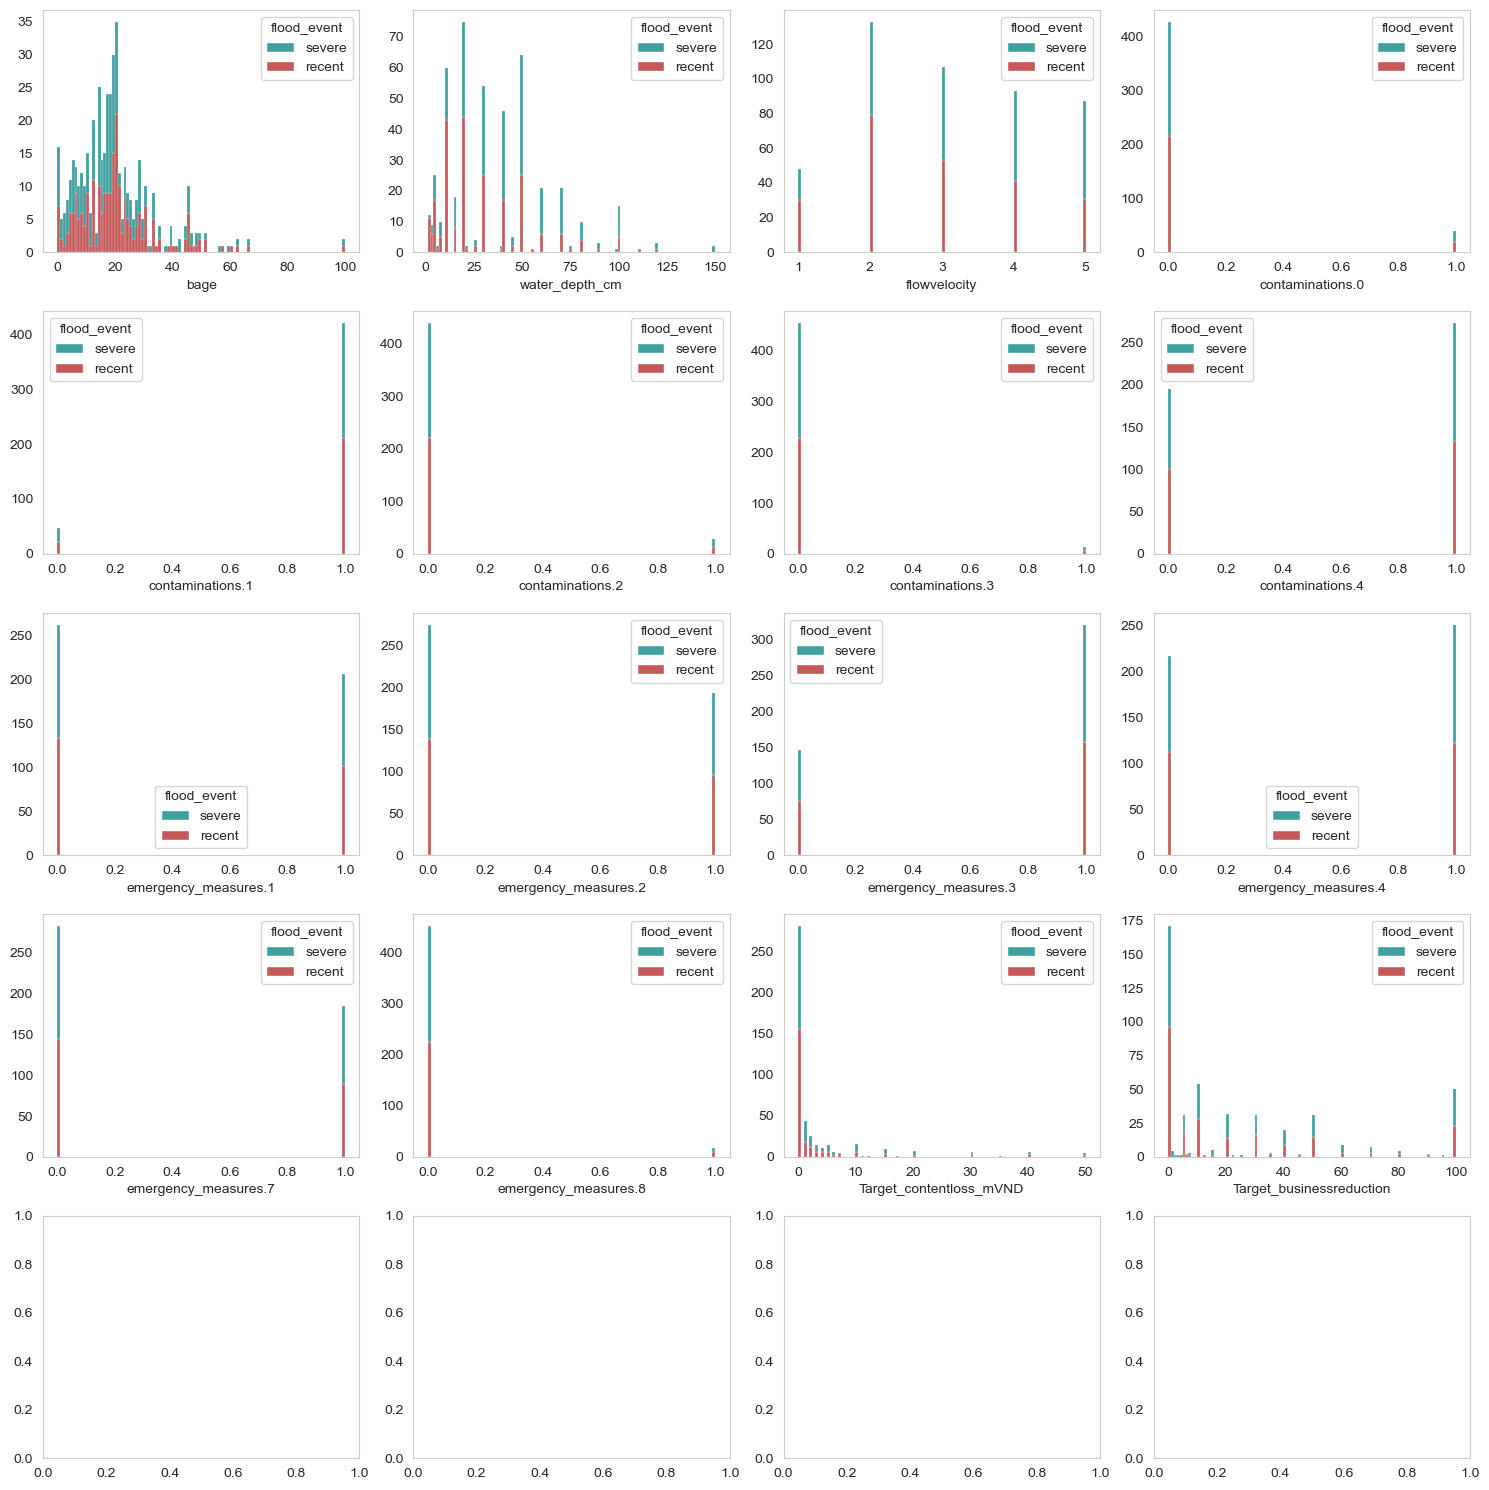

In [145]:
import seaborn as sns
from matplotlib.colors import to_rgba


# df_cantho_p = df_cantho[df_hcmc_p.columns]

## add col for hue plotting
df_severe["flood_event"] = "severe"
df_recent["flood_event"] = "recent"

# merge df for plotting
df_merged_p = pd.concat([df_severe, df_recent], axis=0).reset_index(drop=True)
df_merged_p = df_merged_p.dropna()

## fix miss spellings and NAN handling by changing data type
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace(",2", "2")
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace(",5", "5")
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace("1,5", "1")
df_merged_p["inundation_duration_h"] = df_merged_p.inundation_duration_h.replace("", np.nan)
df_merged_p["inundation_duration_h"] = df_merged_p["inundation_duration_h"].astype(float)
df_merged_p["inundation_duration_h"] = df_merged_p["inundation_duration_h"].astype("int64")

df_merged_p["bage"] = df_merged_p["bage"].astype("int64")
df_merged_p["Target_contentloss_mVND"] = df_merged_p["Target_contentloss_mVND"].astype("int64")
df_merged_p["Target_businessreduction"] = df_merged_p["Target_businessreduction"].astype("int64")

# df_merged_p.info()  # check that datatypes are plotable 
print(df_merged_p.shape)

## style settings
sns.set_style("whitegrid", {"axes.grid" : False})
hue_colors=("teal", "firebrick")
alpha=0.3
color_dict = {"severe": to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        "recent": to_rgba(hue_colors[1], alpha)}
numcols = 4
legend = True
bins = 100 # np.linspace(0, 10, 100)


# ## shorten vlaue ranges of few vars for better plotting
df_merged_p.Target_contentloss_mVND[df_merged_p["Target_contentloss_mVND"] > 60] = np.nan   # 9 cases (3 cases recent + 6 serious) 


## plot
fig, axes = plt.subplots( 1 + len(df_merged_p.columns)//numcols, numcols, figsize=(15, 15), constrained_layout=True)
# bage inundation_duration_h
l = ['bage', 'water_depth_cm', 'flowvelocity',
       'contaminations.0', 'contaminations.1', 'contaminations.2',
       'contaminations.3', 'contaminations.4', 'emergency_measures.1',
       'emergency_measures.2', 'emergency_measures.3', 'emergency_measures.4',
       'emergency_measures.7', 'emergency_measures.8',
       'Target_contentloss_mVND', 'Target_businessreduction']
## plot histos
for col, ax in zip(df_merged_p[l].columns, axes.flat):
    # print(col)
    p = sns.histplot(
        df_merged_p,  
        x=col, 
        hue="flood_event", stat="count",
        bins=bins,
        multiple='stack',
        palette=color_dict, 
        legend=legend,
        # binwidth=.5,
        ax=ax).set_ylabel("")
    plt.tight_layout()
    # if legend is True:
    #     plt.setp(p.get_legend().get_texts(), fontsize="12")  
    #     plt.setp(p.get_legend().get_title(), fontsize="15")

#fig.get_figure().savefig("../figures/histo_severe_recent.png", dpi=300, bbox_inches="tight")
p

Number of cases is larger than from Rscript, due that col "same" incoporates flood times and more varibles are used.

 2*145 + 1 * 107 = 397 cases [count different events twice, identical events once]

## Explore correlations 
Visualize correlations between candidate predictors and targets incl rloss, abs loss, business reduction

In [146]:
all_input.columns

Index(['Target_businessreduction', 'inundation_duration_h', 'water_depth_cm',
       'flowvelocity', 'flood_type.1', 'flood_type.2', 'flood_type.3',
       'flood_experience', 'bage', 'b_area', 'geometry', 'floors',
       'shp_business_limitation', 'shp_sector', 'shp_employees', 'geometry',
       'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'resilience', 'contaminations',
       'overall_problem_house', 'shp_content_value_euro',
       'shp_registered_capital_euro', 'shp_avgmonthly_sale_euro',
       'hh_monthly_income_euro', 'Target_contentloss_euro',
       'Target_relative_contentloss_euro'],
      dtype='object')

21
52
29
10
5
3
2


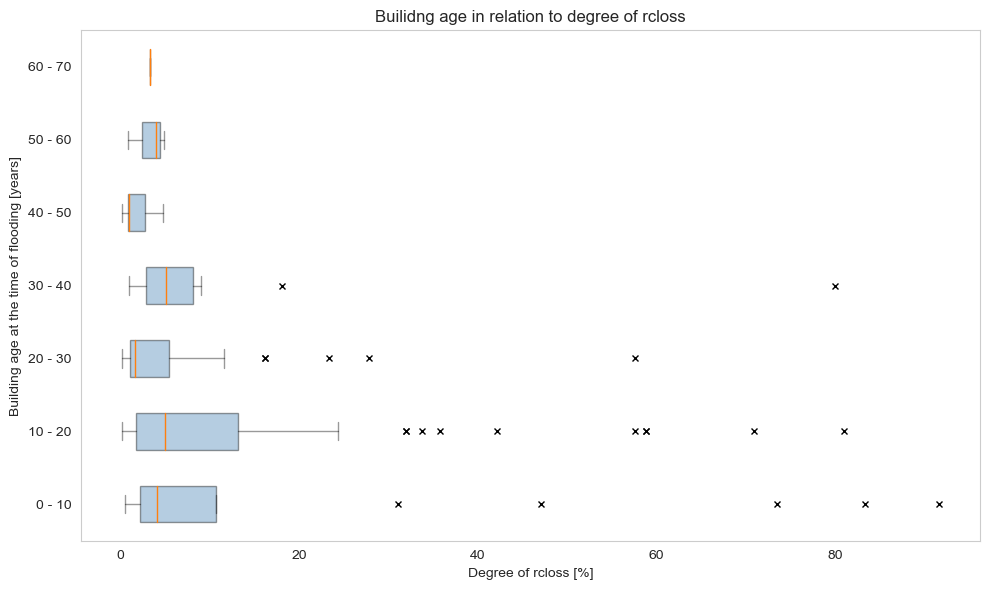

In [147]:
## bage ~ rcloss
## -> builidings built before 80s have much lower closses than newer buis built in late 80s-2010


# column = "Target_businessreduction"
column = "Target_relative_contentloss_euro"
group = "bage_categ"
# scatterpoints = "shp_sector"
scatterpoints = "bage_categ"


all_input_p = all_input#.copy()
all_input_p = all_input_p.loc[ ~all_input_p["bage"].isna(), :]
all_input_p = all_input_p.loc[all_input_p[column] > 0.0, :]


## group businesses by the decade of their construction
all_input_p["bage_categ"] = [f"{int(i//10*10)} - {int(i//10*10+10)}" for i in all_input_p["bage"]] # apply modulo operator and multiply by 10
# all_input_p["bage_categ"] = [ i//10*10+1 for i in all_input_p["bage"]]  # apply modulo operator and multiply by 10

grouped = all_input_p.groupby(group)
categories = np.unique(all_input_p[scatterpoints])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  
all_input_p[scatterpoints] = all_input_p[scatterpoints].apply(lambda x: colordict[x])

names, vals, xs, colrs = [], [] ,[], []

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
    colrs.append(subdf[scatterpoints].tolist())


fig = plt.figure(figsize=(10, 6),  constrained_layout=True)
ax = fig.add_subplot(111)
sns.set_style("whitegrid", {"axes.grid" : False})# {"grid.linestyle": ""})

# p = ax.violinplot(
#     vals, #labels=names,
#     showextrema=False,
#     showmedians=True,
#     vert=False,)

p = ax.boxplot(
    vals, labels=names,
    # showfliers=True,
    showfliers=True,
    patch_artist=True,
    # showmeans=True,
    # showmedians=False,
    vert=False,
    flierprops={"marker":"x", "markersize":5},
    boxprops={"facecolor":"steelblue", "alpha":0.4},
    whiskerprops={"color":"k", "alpha":0.4},
    capprops={"color":"k", "alpha":0.4},
    )
for patch, color in zip(p["boxes"], colors):
        patch.set_facecolor("steelblue",)
        patch.set_edgecolor("black")


for x, val, colr in zip(xs, vals, colrs):
    print(len(colr))


# plt.rcParams.update({"font.size": 15})
plt.rc("axes", titlesize=12)     # fontsize of the axes title
plt.rc("axes", labelsize=12)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=12)    # fontsize of the tick labels
plt.rc("ytick", labelsize=12)    # fontsize of the tick labels

# plt.xlabel(f"Rbred [%]")
plt.xlabel(f"Degree of rcloss [%]")
plt.ylabel(f"Building age at the time of flooding [years]")
plt.title("Builidng age in relation to degree of rcloss")
# plt.title("Builidng age in relation to degree of business reudction")


plt.tight_layout()
#plt.savefig(OUTPATH_FIGURES / "boxplot_bage_degree.png", dpi=300, bbox_inches="tight") 
# plt.savefig(OUTPATH_FIGURES / "boxplot_bage_degree_of_bred.png", dpi=300, bbox_inches="tight") 



**Employee ~ target ~ sector**

shp_sector
1.0000    94
2.0000    19
3.0000     8
Name: count, dtype: int64
43
52
24
2


Text(0.5, 1.0, 'Number of employees in relation to business reduction and sector type')

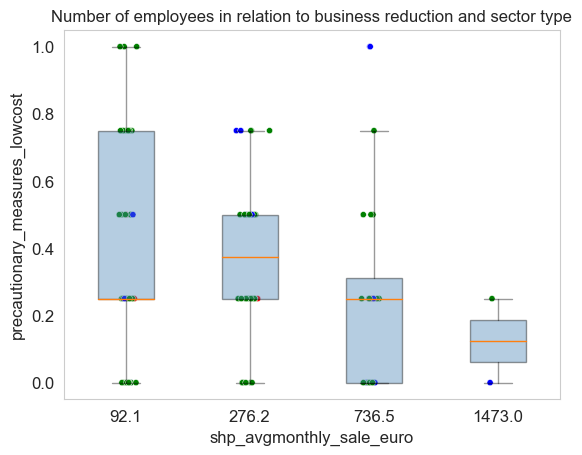

In [148]:
# ## DONE which shops have highest sale rates, are these services or specialized businesses ?
# all_input.boxplot(column="shp_avgmonthly_sale_euro", by=["shp_sector"])

# # 1: shop/retialer [289], 2: service [65], 3: production [n=25]
# all_input.shp_sector.value_counts()

from matplotlib import cm

all_input_p = all_input#.copy()

## select only shops with content damages - only those show this concrete pattern (high sale rates - less precaution) using all cases (inl zeroloss : no pattern visible) 
# all_input_p = all_input_p.loc[all_input_p["Target_contentloss_euro"] > 0.0, :]
all_input_p = all_input_p.loc[all_input_p["Target_relative_contentloss_euro"] > 0.0, :]
# all_input_p = all_input_p.loc[all_input_p["Target_businessreduction"] > 0.0, :]

all_input_p = all_input_p.loc[ ~all_input_p["shp_sector"].isna(), :]

print(all_input_p.shp_sector.value_counts())

# def plot_boxplot_scatterplot(x_column=group, y_column=column, scatterpoints=):
"""
"""
group = "shp_employees"
# group = "shp_sector"
group = "shp_avgmonthly_sale_euro"
# column = "precautionary_measures_expensive"
column = "precautionary_measures_lowcost"
# column = "Target_businessreduction"
# column = "Target_relative_contentloss_euro"
# column = "Target_contentloss_euro"
# column = "shp_content_value_euro"
# column = "emergency_measures"
scatterpoints="shp_sector"

grouped = all_input_p.groupby(group)
categories = np.unique(all_input_p[scatterpoints])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  
all_input_p[scatterpoints] = all_input_p[scatterpoints].apply(lambda x: colordict[x])


names, vals, xs, colrs = [], [] ,[], []

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
    colrs.append(subdf[scatterpoints].tolist())

fig = plt.figure()
ax = fig.add_subplot(111)

p = ax.boxplot(
    vals, labels=names,
    # width=.5,
    showfliers=False,
    patch_artist=True,
    #boxprops={"facecolor":(1,0,0,.2), "edgecolor":"k"}
    boxprops={"facecolor":"steelblue", "alpha":0.4},
    whiskerprops={"color":"k", "alpha":0.4},
    capprops={"color":"k", "alpha":0.4},
    )
for patch, color in zip(p["boxes"], colors):
        # patch.set_facecolor("steelblue",)
        patch.set_edgecolor("black")

ngroup = len(vals)
# clevels = np.linspace(0., 1., ngroup)

for x, val, colr in zip(xs, vals, colrs):
    print(len(colr))
    sns.scatterplot(
        x=x, y=val, 
        hue=colr, edgecolors=colr,
        marker="o", s=20, lw=0,
        legend=False, palette=["green", "blue", "red"]
    )
plt.xlabel(f"{group}")
# plt.ylim(0, 10000)
# plt.xlabel("monhtly sale rates [€]")
plt.ylabel(f"{column}")
plt.title("Number of employees in relation to business reduction and sector type")

# plt.ylabel("fraction of implemented non-structural measures")
#plt.ylabel("fraction of implemented emergency measures")


In [149]:
## check ratio of non struc between the 3 sectors for the lowest sales group
all_input_p = all_input#.copy()
all_input_p = all_input_p.loc[all_input_p[group] < 300.0, :]  # n = 126 businesses

all_input_p = all_input_p.loc[all_input_p["Target_relative_contentloss_euro"] > 0.0, :]
# print("on avg. implemented non-struc. meausres for  the 3 sectors in the group of the lowest sales:\n" , 
all_input_p.groupby("shp_sector")["precautionary_measures_lowcost"].mean(), "number: ", all_input_p.groupby("shp_sector")["precautionary_measures_lowcost"].count()

(shp_sector
 1.0000   0.3782
 2.0000   0.3958
 3.0000   0.3500
 Name: precautionary_measures_lowcost, dtype: float64,
 'number: ',
 shp_sector
 1.0000    78
 2.0000    12
 3.0000     5
 Name: precautionary_measures_lowcost, dtype: int64)

In [150]:
tt = all_input_p.groupby("shp_employees")["shp_sector"].apply(list)
# tt = list(all_input.groupby("shp_employees")["shp_sector"].apply(list))
# 1 empy = 14 services to 44 shps
# 2 empy = 1 services to 41 shps
# 3 empy = 1 services to 6 shps and 2 production sites
# 4 empy = 4 services to 3 shps


For all busiensses which experiecned damage on cotnent:
-- > the highest losses are found for shops and retailors, however also some businesses in this secotr had very small damage ratios 
    so the avg. loss ratio for shops and retailors is similar high as for the other sector types 
--> highest abs closs have shops with higher sale rates, but also here outliers
--> businesses with higher sales also experienced more severe damages on their inventory (only damage cases)
    , while for bred no clear pattern also due that sample sizes for businesses with higher sales are quite small
    but it highest bus. reductions (excl zero-reduction) are only experienced by retailors and shops- giving a hint that shps an retialors are more vulnerable to floods than services and productions sites (still uncertainty due to quite different sample sizes 156 - 37 - 8) 
    - smae als o for degree of loss: highest degree of loss are experienced by retials and shops
--> most businesses with one or two employees are usually shops or retailers    


In [151]:
all_input_p.loc[all_input_p.shp_sector == .0, :].describe()  # check for services - mean of cheap precuation (0.3625+-0.329)
 
print(all_input_p.shp_avgmonthly_sale_euro[all_input_p.shp_sector == .0].describe() )
print(all_input_p.shp_avgmonthly_sale_euro[all_input_p.shp_sector == .5].describe() )
print(all_input_p.shp_avgmonthly_sale_euro[all_input_p.shp_sector == 1.].describe() )

# -->shops with low sale rates tend to impl more emegerncy meausres than serivces or production sites

count   0.0000
mean       NaN
std        NaN
min        NaN
25%        NaN
50%        NaN
75%        NaN
max        NaN
Name: shp_avgmonthly_sale_euro, dtype: float64
count   0.0000
mean       NaN
std        NaN
min        NaN
25%        NaN
50%        NaN
75%        NaN
max        NaN
Name: shp_avgmonthly_sale_euro, dtype: float64
count    78.0000
mean    191.2308
std      92.3713
min      92.1000
25%      92.1000
50%     276.2000
75%     276.2000
max     276.2000
Name: shp_avgmonthly_sale_euro, dtype: float64


**WD ~ FV ~ degree of rcloss and bred**
--> there is no clear connection between fv -> target or wd --> targets 
--> only wd and fv are usually correlated (as seen already in spearman rank)

<Axes: title={'center': 'Target_businessreduction'}, xlabel='[wd_categ]'>

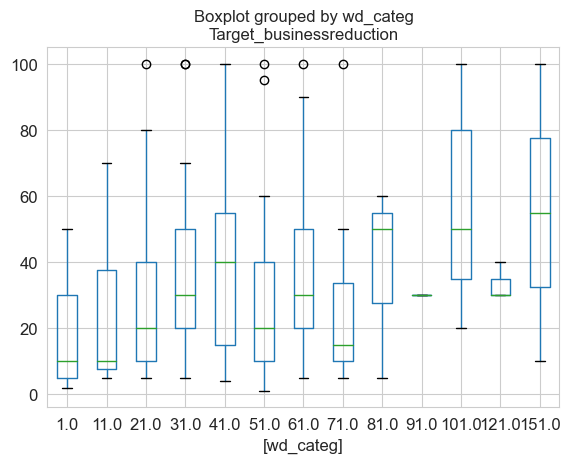

In [152]:
# print(all_input_p.flowvelocity.value_counts())

all_input_p = all_input#.copy()

target = ["Target_relative_contentloss_euro", "Target_businessreduction"][1]
## select only shops with content damages - only those show this concrete pattern (high sale rates - less precaution) using all cases (inl zeroloss : no pattern visible) 
# all_input_p = all_input_p.loc[all_input_p["Target_contentloss_euro"] > 0.0, :]
all_input_p = all_input_p.loc[all_input_p[target] > 0.0, :]

all_input_p["wd_categ"] = [ i//10*10+1 for i in all_input_p["water_depth_cm"]]  # apply modulo operator and multiply by 10
all_input_p.boxplot(column=target, by=["wd_categ"])
# all_input_p.boxplot(column=target, by=["flowvelocity"])

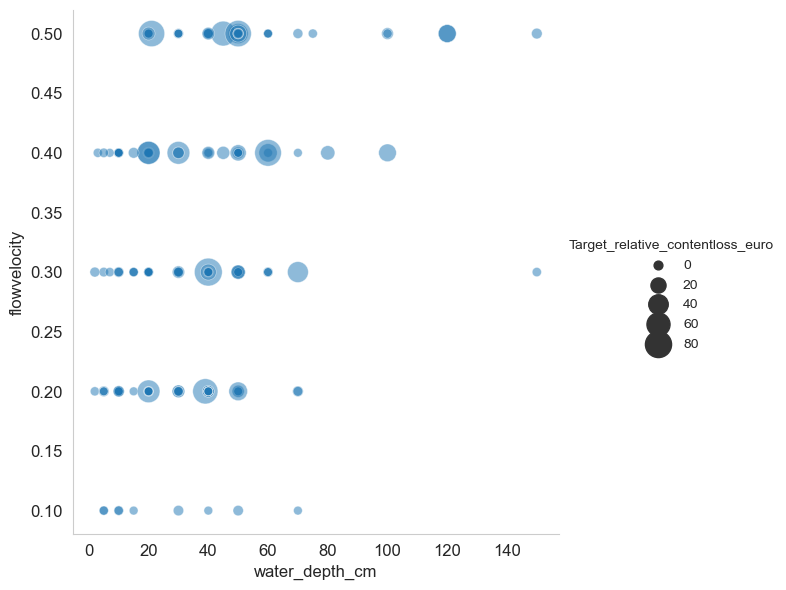

In [153]:

sns.relplot(
        data=all_input_p, x="water_depth_cm", y="flowvelocity", 
        #hue="origin", 
        #size="Target_businessreduction",
        size="Target_relative_contentloss_euro",
        sizes=(40, 400), alpha=.5, palette="muted",
        height=6)

## Explore outliers

In [154]:
all_input.columns
all_input.insert(1, "Target_contentloss_euro", all_input.pop("Target_contentloss_euro"))
all_input.insert(2, "Target_relative_contentloss_euro", all_input.pop("Target_relative_contentloss_euro"))

all_input_degree = all_input.drop([
    "flood_type.1", "flood_type.2", "flood_type.3", 
    "geometry","shp_sector", "overall_problem_house", "floors",
    "Target_contentloss_euro", "Target_businessreduction"
    ], axis=1)
all_input_degree = all_input_degree.loc[all_input_degree["Target_relative_contentloss_euro"] > 0.0 , :]

# f.plot_correlations(all_input.drop("geometry", axis=1) , outfile=f"../figures/combi_scatter_correlation.png")
# f.plot_correlations(all_input_degree , outfile=f"../figures/combi_scatter_correlation_degree.png")

Drop unneeded columns and features sort by parent categories

In [155]:
all_input = all_input.drop([
    # "floors",  # remove in outliers removal for larger buildings
    "flood_type.1", "flood_type.2","flood_type.3",
    #"Target_contentloss_euro" ## keep for BN modelling to compare abs losses
    ], axis=1)


In [156]:

all_input.insert(0, "Target_relative_contentloss_euro", all_input.pop("Target_relative_contentloss_euro"))  
all_input.insert(5, "contaminations", all_input.pop("contaminations"))  
all_input.insert(6, "overall_problem_house", all_input.pop("overall_problem_house"))  
all_input.insert(17, "shp_employees", all_input.pop("shp_employees"))  
all_input.insert(16, "hh_monthly_income_euro", all_input.pop("hh_monthly_income_euro"))  
# all_input.insert(18, "shp_sector", all_input.pop("shp_sector"))  

all_input.columns


Index(['Target_relative_contentloss_euro', 'Target_businessreduction',
       'Target_contentloss_euro', 'inundation_duration_h', 'water_depth_cm',
       'contaminations', 'overall_problem_house', 'flowvelocity',
       'flood_experience', 'bage', 'b_area', 'geometry', 'floors',
       'shp_business_limitation', 'shp_sector', 'geometry',
       'hh_monthly_income_euro', 'emergency_measures', 'shp_employees',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'resilience', 'shp_content_value_euro', 'shp_registered_capital_euro',
       'shp_avgmonthly_sale_euro'],
      dtype='object')

#### remove outliers

**Inundation duration**
One case exists with inundation duration of 600 hours, which is in repsect to the experiecned business reduction of 10% durign the flood month and a degree of loss of 5% probably not reasonable, all other maximum durations are 170 or 240 hours long

In [157]:
print(f"Case for which inundation duration is more than 300 hours\n")
all_input.loc[all_input.inundation_duration_h >150]
all_input.loc[all_input.inundation_duration_h > 500, "inundation_duration_h"] = np.nan


Case for which inundation duration is more than 300 hours



**Shops in large buildings**

Remove busineses which are located in buidligns with more than 3 floors, due that approximation is getting less exact due to small sample size.

In [158]:
print(all_input.shape)
print(f"Remove {all_input[all_input['floors'] > 3.0].shape[0]} records which have shops located in larger buildings")
all_input = all_input[ ~(all_input["floors"] > 3.0)]

## drop floors from final feature space
all_input.drop("floors", axis=1, inplace=True)

(397, 25)
Remove 0 records which have shops located in larger buildings


In [159]:
all_input[["inundation_duration_h", "b_area", "hh_monthly_income_euro", 
                            "shp_registered_capital_euro", "shp_avgmonthly_sale_euro"]].describe()

inundation_duration_h    b_area  hh_monthly_income_euro   
count               387.0000  395.0000                373.0000  \
mean                 11.7964   89.1025                437.8635   
std                  29.7831   97.8995                411.7081   
min                   0.2000   12.0000                 18.4000   
25%                   2.0000   42.0000                294.6000   
50%                   3.0000   74.0000                294.6000   
75%                   6.5000  100.0000                552.4000   
max                 240.0000 1000.0000               3314.3000   

       shp_registered_capital_euro  shp_avgmonthly_sale_euro  
count                     350.0000                  397.0000  
mean                     5365.9709                  377.1741  
std                     38688.6183                  449.3612  
min                        36.8000                   92.1000  
25%                       368.3000                   92.1000  
50%                      1104.8000                  276.2000  
75%                      2485.7250                  276.2000  
max                    699687.0000                 2761.9000

In [160]:
# f.plot_correlations(all_input , outfile=f"../figures/combi_scatter_correlations_before_removal.png")

**Xplore outliers**
Visualize outliers which represent unusal but true cases

359 cases with less than 2 days inundation
19 cases with more than 2 days inundation


<Axes: >

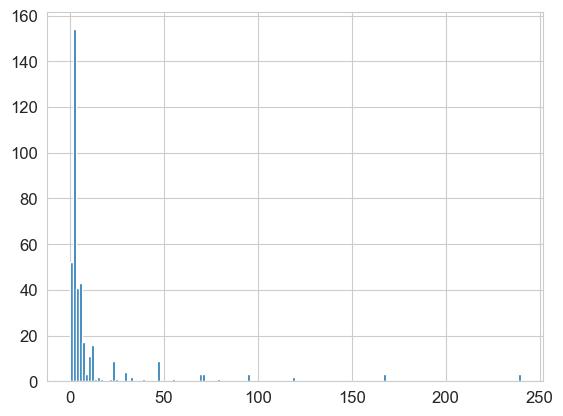

In [161]:
print(all_input.loc[all_input["inundation_duration_h"] < 48,:].shape[0], "cases with less than 2 days inundation")
print(all_input.loc[all_input["inundation_duration_h"] > 48,:].shape[0], "cases with more than 2 days inundation")
all_input["inundation_duration_h"].hist(bins=150, alpha=1.)


--> inundation duration has few cases of very long flood duration, the majority is by less than 24 hours

### Coefficient of variation
access relative volatility between both targets and for predictors
Maybe it explians why some predcitors are seen as more important as others in feautre-extraction 

In [162]:
## coef. of variation

#def calc_coef_of_vairation(x):
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
#    return cv

#calculate CV for each column in data frame
print(all_input.drop("geometry", axis=1).apply(cv).sort_values())
# calc_coef_of_vairation


resilience                           39.9454
contaminations                       41.4228
flowvelocity                         41.9455
shp_sector                           45.2892
overall_problem_house                59.8193
emergency_measures                   64.2231
flood_experience                     66.0439
bage                                 70.9522
water_depth_cm                       75.4840
precautionary_measures_lowcost       80.3406
hh_monthly_income_euro               94.0266
shp_employees                       105.2978
shp_content_value_euro              109.0637
b_area                              109.8729
shp_avgmonthly_sale_euro            119.1390
precautionary_measures_expensive    122.0709
Target_businessreduction            136.6218
inundation_duration_h               252.4769
Target_relative_contentloss_euro    288.7429
shp_business_limitation             414.8567
shp_registered_capital_euro         720.9994
Target_contentloss_euro            1273.4143
dtype: flo

In [163]:
print(all_input.drop("geometry", axis=1).apply(cv).sort_values())


resilience                           39.9454
contaminations                       41.4228
flowvelocity                         41.9455
shp_sector                           45.2892
overall_problem_house                59.8193
emergency_measures                   64.2231
flood_experience                     66.0439
bage                                 70.9522
water_depth_cm                       75.4840
precautionary_measures_lowcost       80.3406
hh_monthly_income_euro               94.0266
shp_employees                       105.2978
shp_content_value_euro              109.0637
b_area                              109.8729
shp_avgmonthly_sale_euro            119.1390
precautionary_measures_expensive    122.0709
Target_businessreduction            136.6218
inundation_duration_h               252.4769
Target_relative_contentloss_euro    288.7429
shp_business_limitation             414.8567
shp_registered_capital_euro         720.9994
Target_contentloss_euro            1273.4143
dtype: flo

## Single datasets for each target variable
Select candiate predictors in respect to the response variables: Split dataset into two parts, one with candidate predictors for content losses and one dataset with candidate predictors for business reduction. This means non relevant candidate predictors fo the respective response are moved.

In [164]:
all_input.drop(["overall_problem_house",  "geometry",
    "shp_sector",
    "shp_registered_capital_euro"], axis=1).describe()

Target_relative_contentloss_euro  Target_businessreduction   
count                          317.0000                  361.0000  \
mean                             4.7956                   18.4654   
std                             13.8468                   25.2277   
min                              0.0000                    0.0000   
25%                              0.0000                    0.0000   
50%                              0.0000                   10.0000   
75%                              2.3004                   30.0000   
max                             91.6723                  100.0000   

       Target_contentloss_euro  inundation_duration_h  water_depth_cm   
count                 382.0000               387.0000        396.0000  \
mean                  915.5353                11.7964         34.3359   
std                 11658.5576                29.7831         25.9181   
min                     0.0000                 0.2000          1.0000   
25%                     0.0000                 2.0000         15.0000   
50%                     0.0000                 3.0000         30.0000   
75%                    77.8500                 6.5000         50.0000   
max                223813.4000               240.0000        150.0000   

       contaminations  flowvelocity  flood_experience     bage    b_area   
count        397.0000      397.0000          397.0000 370.0000  395.0000  \
mean           0.9849        0.3028           81.5416  19.7351   89.1025   
std            0.4080        0.1270           53.8533  14.0025   97.8995   
min            0.0000        0.1000            3.0000   0.0000   12.0000   
25%            1.0000        0.2000           36.0000  11.0000   42.0000   
50%            1.0000        0.3000           76.0000  18.0000   74.0000   
75%            1.0000        0.4000          151.0000  24.0000  100.0000   
max            2.0000        0.5000          151.0000 100.0000 1000.0000   

       shp_business_limitation  hh_monthly_income_euro  emergency_measures   
count                 397.0000                373.0000            397.0000  \
mean                    4.9698                437.8635              0.4043   
std                    20.6174                411.7081              0.2596   
min                     0.0000                 18.4000              0.0000   
25%                     0.0000                294.6000              0.1667   
50%                     0.0000                294.6000              0.5000   
75%                     3.0000                552.4000              0.5000   
max                   365.0000               3314.3000              1.0000   

       shp_employees  precautionary_measures_lowcost   
count       397.0000                        397.0000  \
mean          1.9370                          0.3621   
std           2.0396                          0.2909   
min           1.0000                          0.0000   
25%           1.0000                          0.2500   
50%           2.0000                          0.2500   
75%           2.0000                          0.5000   
max          34.0000                          1.0000   

       precautionary_measures_expensive  resilience  shp_content_value_euro   
count                          397.0000    397.0000                335.0000  \
mean                             0.2217      2.5806               4252.7516   
std                              0.2706      1.0308               4638.2084   
min                              0.0000      0.0000                257.8000   
25%                              0.0000      1.7500               1841.3000   
50%                              0.0000      2.5000               3203.8000   
75%                              0.5000      3.2500               4603.2000   
max                              1.0000      5.0000              50635.2000   

       shp_avgmonthly_sale_euro  
count                  397.0000  
mean                   377.1741  
std                 

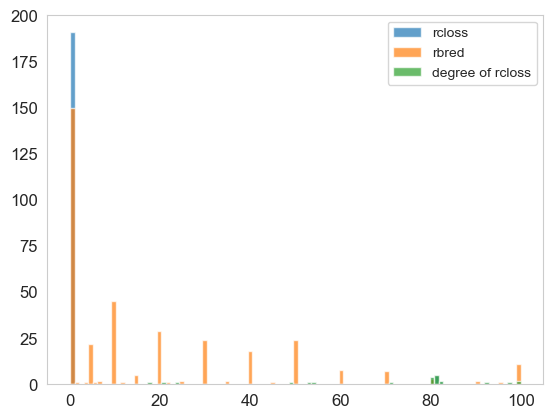

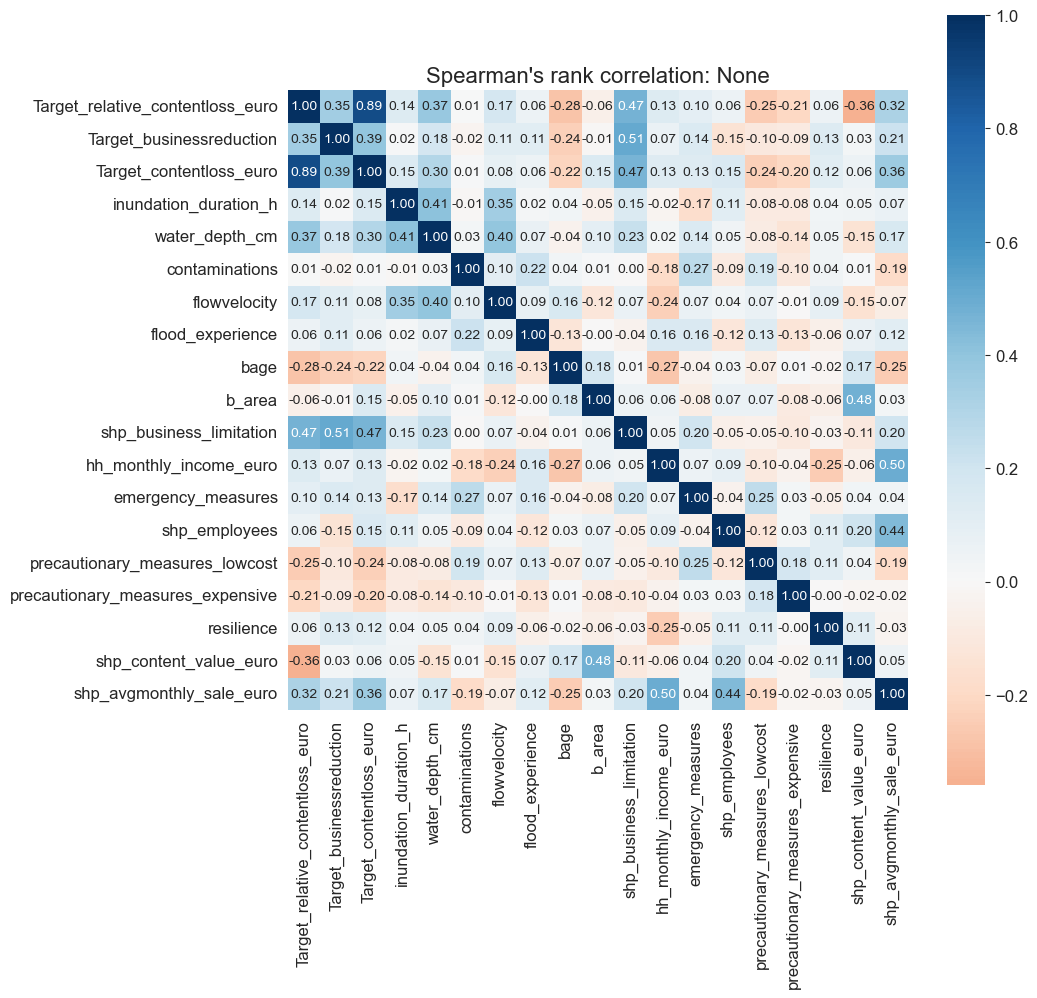

In [165]:
all_input_degree = all_input.loc[all_input.Target_relative_contentloss_euro > 0.0, :]
# all_input_bred = all_input.loc[all_input.Target_relative_contentloss_euro > 0.0, :]

all_input_plot = all_input_degree

all_input_plot = all_input_plot.drop(
    [#"Target_businessreduction", 
        "overall_problem_house",  "geometry",
        "shp_sector", 
        "shp_registered_capital_euro"], axis=1)


bins = np.linspace(0, 100, 100)

plt.hist(all_input.Target_relative_contentloss_euro*100, bins, alpha=0.7, label="rcloss")
plt.hist(all_input.Target_businessreduction, bins, alpha=0.7, label="rbred")
plt.hist(all_input_degree.Target_relative_contentloss_euro*100, bins, alpha=0.7, label="degree of rcloss")
plt.legend(loc="upper right")
plt.show()

# all_input.Target_relative_contentloss_euro.describe()

## --> only 25% of rcloss have losses higher than 2% of their inventory value




plt.figure(figsize=(10,10))
f.plot_spearman_rank(all_input_plot, min_periods=50, signif=False, psig=0.05)

## --> degree of loss (rcloss without zerolosses)  has stronger correlations than bred (incl zero cases) (NOTE shp_contentvalue is not used in rcloss ds)

#### Plot spearate correlation plots with feature spaces for degree of rcloss and bred

Degree of loss (rcloss without zerolosses)  has stronger correlations than bred (incl zero cases)  ? (NOTE shp_contentvalue is not used in rcloss ds)

In [166]:
all_input_degree = all_input.loc[all_input.Target_relative_contentloss_euro > 0.0, :]
all_input_chance = all_input.copy(deep=True)  # remove link between both instances
all_input_chance.loc[all_input_chance["Target_relative_contentloss_euro"] > 0, "Target_relative_contentloss_euro"] = 1
all_input_bred = all_input


all_input_chance = all_input_chance.drop(
    ["Target_businessreduction", "shp_business_limitation",
     "Target_contentloss_euro", "shp_content_value_euro",
        "overall_problem_house",  "geometry",
    "shp_sector", "shp_registered_capital_euro"], axis=1)

all_input_degree = all_input_degree.drop(
    ["Target_businessreduction", "shp_business_limitation",
     "Target_contentloss_euro", "shp_content_value_euro",
        "overall_problem_house",  "geometry",
    "shp_sector", "shp_registered_capital_euro"], axis=1)

all_input_bred = all_input_bred.drop(
    ["Target_relative_contentloss_euro", "shp_business_limitation",
     "Target_contentloss_euro", "shp_content_value_euro",
        "overall_problem_house",  "geometry",
    "shp_sector", "shp_registered_capital_euro"], axis=1)


all_input_degree.rename(columns=s.feature_names_plot, inplace=True)
# all_input_degree.rename(columns={"rcloss":"degree of rcloss"}, inplace=True)
all_input_bred.rename(columns=s.feature_names_plot, inplace=True)

In [167]:
from sklearn.metrics import confusion_matrix, mean_absolute_error as mae
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from matplotlib.cbook import boxplot_stats  
from matplotlib.colors import to_rgba
import seaborn as sns

# import evaluation_src as eu
import settings as s
import feature_selection as fs


def plot_spearman_rank(df_corr, min_periods=100, signif=True, psig=0.05, target=None):
    """
    ## Code snippet modified: https://stackoverflow.com/questions/69900363/colour-statistically-non-significant-values-in-seaborn-heatmap-with-a-different

    df_corr (dataframe): dataframe with variables to plot
    min_periods (int): Minimum number of observations required per pair of columns to have a valid result
    signif (boolean): should non significant be masked
    psig (float): signifcance level
    return: Figure for Spearman Correlation 
    """ 
    ## get the p value for spearman coefficient, subtract 1 on the diagonal
    pvals = df_corr.corr(
        method=lambda x, y: stats.spearmanr(x, y)[1], min_periods=min_periods
        ) - np.eye(*df_corr.corr(method="spearman", min_periods=min_periods).shape)  # np.eye(): diagonal= ones, elsewere=zeros

    #  main plot
    sns.heatmap(
        df_corr.corr(method="spearman", min_periods=min_periods), 
        annot=True, square=True, 
        center=0, cmap="RdBu", 
        fmt=".2f", zorder=1,
        annot_kws={'size': 10})
    plt.title(f"Spearman's rank correlation: {target}", fontsize=16)

    # signifcance mask
    if signif:
        ## add another heatmap with colouring the non-significant cells
        sns.heatmap(df_corr.corr(method="spearman", min_periods=min_periods)[pvals>=psig], 
            annot=False, square=True, cbar=False,
            ## add-ons
            cmap=sns.color_palette("Greys", n_colors=1, desat=1),  
            zorder = 2) # put the map above the heatmap
        ## add a label for the colour
        colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
        texts = [f"not significant (at {psig})"]
        patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
        plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')



ModuleNotFoundError: No module named 'settings'

In [ ]:
all_input_degree.rename(columns={"rcloss":"degree of rcloss"}, inplace=True)

In [ ]:
plt.figure(figsize=(15,15))
# all_input_degree.rename(columns={"rcloss":"degree of rcloss"}, inplace=True)
plot_spearman_rank(all_input_degree, min_periods=50, signif=False, psig=0.05, target="degree of rcloss")

In [ ]:
plt.figure(figsize=(15,15))
f.plot_spearman_rank(all_input_bred, min_periods=50, signif=False, psig=0.05, target="rbred")

**correlations with binary chance of rcloss and predictors**

In [ ]:
import scipy.stats as stats

corr_list = [] 
all_input_chance = all_input_chance.dropna()

#calculate biserial correlation
for column in all_input_chance:
    x = all_input_chance[column]
    corr = stats.pointbiserialr(list(x), list(all_input_chance.Target_relative_contentloss_euro))
    corr_list.append(corr[0])
print(corr_list)

# 2: 16 (wd), 4:18 (fv)

In [ ]:
all_input.describe()

**Drop unneded columns**

In [ ]:
all_input = all_input.select_dtypes(exclude=["geometry"])
all_input.info()

In [ ]:
all_input_contentloss = all_input
all_input_contentloss = all_input_contentloss.drop(
    [
    "Target_businessreduction",
    #"shp_content_value_euro",  # keep inside to calc obs and predicted abs loss returned from BN
    "overall_problem_house",  # no logical impact on closs, but might impact bred
    # "shp_sector",
    "shp_registered_capital_euro", # same - circular 
 
    ]
    , axis=1)
print(all_input_contentloss.shape)
all_input_contentloss.columns


In [ ]:
all_input_business_reduction = all_input
all_input_business_reduction = all_input_business_reduction.drop(
    [
    "Target_relative_contentloss_euro",
      "Target_contentloss_euro", 
      "overall_problem_house",  #rm due that it is circular / captured by other variables
      "shp_registered_capital_euro", # same - circular, corr with monhtly_sale
      # "shp_sector",
      #"hh_monthly_income_euro", "shp_content_value_euro",  # corr with monhtly_sale
    ],
    axis=1)

print(all_input_business_reduction.shape)
all_input_business_reduction.columns


## Tests of feature space modification

### Test feature importance of business sector via one-hot-encoding

In [ ]:
# all_input_contentloss = pd.get_dummies(all_input_contentloss, columns=["shp_sector"]) # 3 sector types
# all_input_contentloss.tail(3)

## Geolocations

In [ ]:
# df["geometry"][1].is_
# " ".join([is_digit()])

In [ ]:
# geo_df = gpd.GeoDataFrame(df,  
#             geometry=gpd.points_from_xy( 
#                     df["geometry"].str.split(",").str[1], # lon
#                     df["geometry"].str.split(",").str[0],  # lat
#             )
#         )

Geolocations from the survey of the two largest businesses was compared with their actual location done by an internet search. It could be seen that the geolocations mentioned in the survey at least for the two largest businesses ahave potentially a high uncertainty range which is at least for the two examined businesses more than 200 m (beeline). The usage of spatial variables would be highly imprecise. Furthermore deriving the content value from building height is similar imprecise.


### Quality assessment: check OSM building information
Check if enough commercial/business-related building information exist in OSM to use it for extrapolation of content loss 
test for certain streets / small AIO with many shophouses exists from Tübing ds
- verify OSM information with geolocation of shophouses from Tübing ds 
- if enough valid information exists get OSM information from 2020
- if enough valid information adapt attributes by shop sectors from HCMC dataset
- if enough valid information get boundaries of AOI  :-)


In [ ]:
# # import requests
# # URL = "https://api.ohsome.org/v1/elements/count"
# # data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006",  "format": "json", 
# #         "time": "2023-09-01", 
# #         # buildings total end 2023 : ~ 64 800 
# #         #"filter": "building=* and builing!=no and shop=*"}  # ~153 results 
# #         # "filter": "shop=* or building=commercial or building=industrial or building=kiosk or building=retail or amenity=bar or amenity=cafe or amenity=fast_food or amenity=restaurant or landuse=retail or landuse=commercial"} # 6424 reuslts
# #         # "filter": "shop=* or building=commercial or building=industrial or building=kiosk or building=retail or amenity=bar or amenity=cafe or amenity=fast_food or amenity=restaurant"} # 6288.0 reuslts
# #         "filter": "building=commercial or building=kiosk or building=retail or amenity=bar or amenity=cafe or  amenity=fast_food or amenity=restaurant"} # 2925.0 reuslts
# # # and type:way"}
# # response = requests.post(URL, data=data)
# # print(response.json())

# # import requests
# # #from ohsome import OhsomeClient
# # URL = "https://api.ohsome.org/v1/elements/count"
# # data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006", "format": "json", "filter": "building=* and builing!=no and building:levels=* or level=* or building:level=* or stories=* or levels=* or building:part:levels=*"}
# # response = requests.post(URL, data=data)
# # print(response.json())
# # ## --> building tagged in HCMC 64495.0, from those have around 2746 information about stories --> ~ <5% stories information

# import requests
# URL = "https://api.ohsome.org/v1/elements/geometry"
# #URL = "https://api.ohsome.org/v1/elements/length/ratio"
#         #"filter": "highway=living_street and type:way", "filter2": "highway=living_street and oneway=yes and type:way"}
# data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006", "properties": "tags,metadata",
#         "time": "2023-09-01", 
#         "filter": "building=commercial or building=kiosk or building=retail or amenity=bar or amenity=cafe or  amenity=fast_food or amenity=restaurant"} 
#         # TODO include shop: (florist, supermarket, clothes, bag, houseware, books, seafood, beauty, mobile_phone, military_surplus, 
#         # wedding, convenience, yes, electronics , tailor, jewelry, funeral_directors ...) # = yes e.g. Spectacles shop, Clothing
# response = requests.post(URL, data=data)
# print(response.json())


In [ ]:
# t = response.json()


In [ ]:
# import os, sys
# import json
# import pandas as pd
# import geopandas as gpd
# from ohsome import OhsomeClient
# import requests

# sys.path.append("../../")
# # sys.path.append( os.getcwd()+ "/..")
# from modules.download import download_features, build_ohsome_filters
# from modules.src import load_config, init_logger



In [ ]:
# config_layers = "../modules/config_tags_hcmc.json"
# config_tags = load_config(config_layers)

# client = OhsomeClient()
# timestamp=None
# out_dir = "."
# output_dir = "../modules"
# aoi = "106.503238,10.6071085,106.7740687,10.8401006" #t.to_frame(name="geometry")

# # for layer in config_tags["get_all_info"]:
# # for layer in config_tags["get_commerce_info"]:
# for layer in config_tags["get_residential_info"]:
# # for layer in config_tags["get_buildingheight_info"]:
#     ohsome_filter_str = build_ohsome_filters(layer)
#     print(ohsome_filter_str)
#     response = client.elements.geometry.post(
#         bboxes=aoi,
#         # bboxes="106.593238,10.6971085,106.7740687,10.8401006",
#         #bpolys=aoi, 
#         time=timestamp, filter=ohsome_filter_str, properties="metadata,tags"
#     )
#     response.to_json(os.path.join(output_dir, f"{layer["name"]}.geojson"))  
#     # output_dir = os.path.join(out_dir, "test")
# os.makedirs(output_dir, exist_ok=True)

### Get spatial distirbution of certain variables
E.g. examine spatial variation of reported flowvelocity, water depth, business size, floor number etc.

In [ ]:
# raw_data["geometry"].str.findall(r"(\d+\.\d+)")

df_geom = all_input

df_geom["geometry"] = pd.Series(raw_data["geometry"])#.astype(str).str.findall(r"(\d+\.\d+)")
df_geom = gpd.GeoDataFrame(df_geom)

print(df_geom.shape)
df_geom.tail(2)
# df_geom.info()


In [ ]:
df_geom = df_geom[~ df_geom.is_empty] # drop empty geoms
print(df_geom.shape)


In [ ]:
# all_input_contentloss.bage.hist(bins=100)
all_input_business_reduction.bage.hist(bins=100)

In [ ]:
# # glimpse =  df[~ df.is_empty] 
# # #glimpse = glimpse[glimpse.flowvelocity]
# # glimpse.geometry.explore() 


# ## preparation for folium plot
# ## drop timestamp columns due not usable in folium plot
# df = df_geom[["flood_experience", "inundation_duration_h", "water_depth_cm", "flowvelocity", "shp_content_value_mVND", 
#          "Target_contentloss_mVND", "Target_businessreduction", "bage",
#          "geometry"
#          ]]
# ## imporve plot visualization
# # df = df.loc[df.Target_contentloss_mVND < 10, :]
# df = df.loc[df.Target_contentloss_mVND < 500, :]
# df = df.loc[df.inundation_duration_h < 500, :]

# print(df.shape)

# ## visual check of SMEs locations
# import folium

# glimpse = df[~ df.is_empty]   # drop emtpy geoms
# glimpse_geolocations = df[~ df.is_empty]   # drop emtpy geoms
# m = glimpse.geometry.explore(name="survey ds", color="red", k=10)  
# m = glimpse_geolocations.explode(ignore_index=True).explore(
#     m=m, 
#     column="Target_businessreduction",
#     # column="flood_experience",
#     #name="flowvelocity",
#     #column="flowvelocity", 
#     popup=True, 
#     #tooltip="Nr_Floors", 
#     cmap="viridis",
#     #cmap="Reds"
# )    # 

# folium.LayerControl().add_to(m)
# m

# ############### spatial distirbutions explored   ##################
# ## 0.1 = calm velocity, 0.5 = turbulent velocity
# ## no spatial relationship between veloctiy strength and distance to canal or waterway visible 
# ## --> seems like flow velocity is infleunced by further flood sources like overwhelmed drainage systems

# ## abs loss
# #     column="Target_contentloss_mVND",
# ## only slight spatial agglomeration of damage-case

# ### CV
# # ## only slight spatial agglomeration
 
#  ## water depth
#  ## cluster(s) of higher wd might exists e.g. South-east next to highway

# ## inundation duration
# ## clusters of longer (multiple clusters) and shorter (one cluster) inundation durations exist

# ## flood experience
# ## cluster at least in south-east and one in the center exists, rest is quite mixed

# ## bage

**employees by sector**

In [ ]:
# ## TODO are employess or b_area and sector correlated with cv 

# from sklearn import linear_model

# X = all_input[["shp_sector", "shp_employees"]]  # "b_area"
# y = all_input["shp_content_value_euro"]
# regr = linear_model.LinearRegression()
# regr.fit(X, y)

In [ ]:

print(all_input.shp_sector.value_counts())  # number o businesses per sector


tt = list(all_input.groupby("shp_sector")["shp_employees"].apply(list))
print(Counter(tt[0]))  # count shps grouped by employee number in sector 1
print(Counter(tt[1]))  # count shps grouped by employee number in sector 2
print(Counter(tt[2]))  # count shps grouped by employee number in sector 3

# print(pd.Series(tt[0]).describe())
# print(pd.Series(tt[1]).describe())
# print(pd.Series(tt[2]).describe())

# # ## --> all sectors have usually 1 or 2 employees
# all_input.shp_sector

In [ ]:
# ## does cv correlates with setor type ?

# print(all_input.shp_sector.value_counts())
# tt = list(all_input.groupby("shp_sector")["shp_content_value_euro"].apply(list))

# # print(Counter(tt[0]))  # count shps grouped by employee number in sector 1
# # print(Counter(tt[1]))  # count shps grouped by employee number in sector 2
# # print(Counter(tt[2]))  # count shps grouped by employee number in sector 3

# print(pd.Series(tt[0]).describe())
# print(pd.Series(tt[1]).describe())
# print(pd.Series(tt[2]).describe())

# ## --> secotr 3 haas usaully the most expensive content value (<- it is production sector), 
# ##    however sample size is quite small with 26 flood-cases from production sector


### Test Spatial Autocorrelation

In [ ]:
# import libpysal as lps
# import pysal as ps
# import esda

In [ ]:
# df_geom = all_input_incl_geometry

# df_geom["geometry"] = raw_data["geometry"].str.findall(r"(\d+\.\d+)").astype(str)
# geom_col = df_geom["geometry"].str.split(" ", n=1, expand=True)
# geom_col

# df_geom.geometry
# df_geom = gpd.GeoDataFrame(df_geom,  
#            geometry=gpd.points_from_xy(
#                geom_col[0].str.extract(r"(\d+\.\d+)")[0],
#                geom_col[1].str.extract(r"(\d+\.\d+)")[0],
#     ))
# df_geom = df_geom.set_crs(4326) 

# # dff = df_geom
# # dff = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df["geometry"]))

# # target = "Target_businessreduction"
# # target = "rcloss" #
# target = "Target_contentloss_mVND"
# #target = "shp_content_value_mVND"

In [ ]:
# ## use survey data points for weights creation - using KNN or DistanceBand neighborhodd definition

# dff = df_geom
# dff[target] = dff[target].apply(pd.to_numeric)
# # dff[["shp_content_value_mVND", "Target_contentloss_mVND"]] = dff[["shp_content_value_mVND", "Target_contentloss_mVND"]].apply(pd.to_numeric)
# # dff["rcloss"] = dff.shp_content_value_mVND / dff.Target_contentloss_mVND
# dff = dff[dff[target].notna()]
# # dff = dff.loc[dff[target] <=1.00, :]
# dff = dff.loc[dff[target] >0.00, :]
# #dff[target].fillna((dff[target].median()), inplace=True)
# dff =  dff[~ dff.is_empty] # NOTE: mandatory for spatial analysis drop missing geolocations
# print(dff[target].describe())

# # wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=0.6, geom_col="geometry")  # def -1.0
# # wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=0.06, alpha=-1.0, binary=False)  # def -1.0
# # wq =  lps.weights.Queen.from_dataframe(dff)
# # wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=01.2,binary=False)  
# # wq =  lps.weights.Queen.from_dataframe(dff)
# wq =  lps.weights.DistanceBand.from_dataframe(dff, threshold=0.6, binary=False)  #  inverse distance weighting

# # wq.transform = "r"  # continous case , "b" binary case

# ## use voronoi polygons for weights creation - using Queens neighborhodd defnition
# # wq = lps.weights.contiguity.Queen.from_dataframe(df_geom)
# #.lib.weights.Queen.from_dataframe(df)

# wq.transform = "r"

# print(f"Median of {target}", dff[target].median())# Target_businessreduction

# ## Moran’s I is a test for global autocorrelation for a continuous attribute:
# #np.random.seed(12345)
# mi = esda.moran.Moran(dff[target], wq)

# sns.kdeplot(mi.sim, shade=True)
# plt.vlines(mi.I, 0, 5, color="r")
# plt.vlines(mi.EI, 0,5)
# plt.xlabel("Moran"s I")

# print("Moran"s I", mi.I)  # = red == observed value

# print("p-value:", mi.p_sim)  # significant <=0.05
# print("z-score :")  #  statement with a given level of confidence about whether or not we reject or accept the null hypothesis.

### Test Local Morans I

In [ ]:
# f.plot_correlations(
#     all_input.drop(
#         ["overall_problem_house", "geometry", "shp_sector" , 
#             "hh_monthly_income_euro", "shp_content_value_euro",	"shp_registered_capital_euro"],
#             axis=1), 
#      impute_na=True
# )
# all_input_contentloss.columns

In [ ]:
# df_vif = fs.vif_score(all_input.drop("""geometry", axis=1).dropna())
# print(df_vif.sort_values("vif_scores", ascending=False)  )
all_input_business_reduction.loc[all_input_business_reduction.Target_businessreduction==0.0, :].describe()

# Write to disk

In [ ]:
print(all_input_contentloss.drop("geometry", axis=1).apply(cv).sort_values())
print(all_input_business_reduction.drop("geometry", axis=1).apply(cv).sort_values())


In [ ]:
all_input_contentloss.loc[all_input_contentloss.Target_relative_contentloss_euro > 0.0, :].describe()
# Target_contentloss_euro, shp_content_value_euro
all_input_contentloss.describe()

In [ ]:
## move targets to beginning
all_input_contentloss.insert(0, "Target_relative_contentloss_euro", all_input_contentloss.pop("Target_relative_contentloss_euro"))
all_input_business_reduction.insert(0, "Target_businessreduction", all_input_business_reduction.pop("Target_businessreduction"))


In [ ]:

## drop cases with missing loss information 
print(f"Dropping {all_input_contentloss.Target_relative_contentloss_euro.isna().sum()}")
all_input_contentloss = all_input_contentloss[ ~all_input_contentloss["Target_relative_contentloss_euro"].isna()]
print(all_input_contentloss.shape)

## drop cases with missing reduction information 
print(f"Dropping {all_input_business_reduction.Target_businessreduction.isna().sum()}")
all_input_business_reduction = all_input_business_reduction[ ~all_input_business_reduction["Target_businessreduction"].isna()]
print(all_input_business_reduction.shape)



In [ ]:
all_input_business_reduction.info()
# pp.percentage_of_nan(all_input_business_reduction)  # cv has 14% ming NA -maybe remove therefore


In [ ]:
plt.figure(figsize=(18,18))
f.plot_spearman_rank(all_input_business_reduction.drop("geometry", axis=1), min_periods=50, signif=True, psig=0.05)


In [ ]:
## check VIP score for final set of potential predictors

df_vif = all_input_business_reduction.drop(
    ["geometry", "Target_businessreduction"],
    axis=1).dropna()

# df_vif = all_input_contentloss.drop(
#     ["geometry", "Target_relative_contentloss_euro", "Target_contentloss_euro", "shp_content_value_euro"],
#     axis=1).dropna()
df_vif = fs.vif_score(df_vif)

print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )

In [ ]:
print(all_input_contentloss.loc[all_input_contentloss["Target_relative_contentloss_euro"]>0.00,:].shape[0], "damage cases")
print(all_input_contentloss.loc[all_input_contentloss["Target_relative_contentloss_euro"]==0.00,:].shape[0], "zero damage cases")

In [ ]:
# all_input_contentloss[ (all_input_contentloss.bage<50) & (all_input_contentloss.bage > 20)].Target_relative_contentloss_euro.describe()
# # 75%       0.0316 # buis odler than 50 years (10 cases)
# all_input_contentloss.bage.hist(bins=100)

f.plot_spearman_rank(all_input_business_reduction.drop("geometry", axis=1), signif=0.00)

In [ ]:
## save to disk
all_input_contentloss.to_excel("../input_survey_data/input_data_contentloss_tueb.xlsx", index=False)
all_input_business_reduction.to_excel("../input_survey_data/input_data_businessreduction_tueb.xlsx", index=False)


##  save all_input for comparison with cantho distrbutions
all_input.to_excel("../input_survey_data/input_data_bothtargets_tueb.xlsx", index=False)


In [ ]:
print("Relative content loss dataset")
print("Number of candidate predictors ", all_input_contentloss.shape[1])
print("Number of cases ", all_input_contentloss.shape[0])

print("\nBusiness reduction dataset")
print("Number of candidate predictors ", all_input_business_reduction.shape[1])
print("Number of cases ", all_input_business_reduction.shape[0])

In [ ]:
all_input_contentloss.columns

In [ ]:
all_input.Target_relative_contentloss_euro.hist(bins=50)

In [ ]:
## export distribution statistics 

tbl = all_input.describe().T
tbl.to_excel("../input_survey_data/input_data_business_distrib_tueb.xlsx", index=True)
tbl

## Compare rlosses of older buildings with newer buidlings
Theory that older buildings have less losses due that they are located in historical areas of the city
--> problem only 10 buildins are older than 50 year accoridng to interviewee reports

##### check performance with income for rcloss, and income + cv for bred

In [ ]:
all_input_contentloss.columns # s = all_input_contentloss.drop("Target_contentloss_euro", axis=1)
# all_input_contentloss = all_input_contentloss.drop(["shp_content_value_euro"], axis=1)

# all_input_business_reduction = all_input_business_reduction.drop("Target_relative_contentloss_euro", axis=1)
# #all_input_business_reduction = all_input_business_reduction.drop(["shp_sector" ,"flood_type.1", "flood_type.2","flood_type.3"], axis=1)

all_input_contentloss.hh_monthly_income_euro.describe()

In [ ]:
all_input_business_reduction.columns
#all_input_business_reduction.precautionary_measures.value_counts()

In [ ]:
# # check freq of pluvial/fluvial and riverine flood types
# all_input["hh_monthly_income"].describe()  # recent

# ## records total : 393
# # 1 : tidal 306 records 
# # 2 : pluvial 286 records --> prolonged or high-intensity can led to overwhelmed drainage systems / waterways (Leitpold 2021)
# # 3 : riverine 38 records 

# ## many compound floodings are reported - in line with Leitpold 2021 for manufactoring firms (two or more flood sources simultainously or in subsequently in short time)

In [ ]:
all_input_contentloss.describe()